In [1]:
import os
import math
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from torch import optim
import torchvision.utils as torch_utils
import matplotlib.pyplot as plt
import matplotlib.animation as animation

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Generator and Discriminator Utilities
class WSConv2d(nn.Module):
    def __init__(
        self, in_channels, out_channels, kernel_size=3, stride=1, padding=1
    ):
        super(WSConv2d, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.scale = (2 / (in_channels * (kernel_size ** 2))) ** 0.5
        self.bias = self.conv.bias
        self.conv.bias = None

        # initialize conv layer
        nn.init.normal_(self.conv.weight)
        nn.init.zeros_(self.bias)

    def forward(self, x):
        return self.conv(x * self.scale) + self.bias.view(1, self.bias.shape[0], 1, 1)
    

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.conv1 = WSConv2d(in_channels, out_channels)
        self.conv2 = WSConv2d(out_channels, out_channels)
        self.leaky = nn.LeakyReLU(0.2)

    def forward(self, x):
        x = self.leaky(self.conv1(x))
        x = self.leaky(self.conv2(x))
        return x
    
def target_to_oh_shoe(target):
    NUM_CLASS = 3
    one_hot = torch.eye(NUM_CLASS)[target]
    return one_hot


# Train and Eval utilities
def generate_examples(gen, steps, z_dim, n=100):
    gen.eval()
    alpha = 1.0
    for i in range(n):
        with torch.no_grad():
            noise = torch.randn(1, z_dim).to(device)
            img = gen(noise, alpha, steps)
            if not os.path.exists(f'saved_examples/step{steps}'):
                os.makedirs(f'saved_examples/step{steps}')
            save_image(img*0.5+0.5, f"saved_examples/step{steps}/img_{i}.png")
    gen.train()

  
def gradient_penalty(critic, labels, real, fake, alpha, train_step, device="cpu"):
    BATCH_SIZE, C, H, W = real.shape
    beta = torch.rand((BATCH_SIZE, 1, 1, 1)).repeat(1, C, H, W).to(device)
    interpolated_images = real * beta + fake.detach() * (1 - beta)
    interpolated_images.requires_grad_(True)

    # Calculate critic scores
    mixed_scores = critic(interpolated_images, labels, alpha, train_step)
 
    # Take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
    return gradient_penalty

def get_loader(image_size):
    transform = transforms.Compose(
        [transforms.Resize((image_size, image_size)),
         transforms.ToTensor(),
         transforms.RandomHorizontalFlip(p=0.5),
         transforms.Normalize(
            [0.5 for _ in range(channels_img)],
            [0.5 for _ in range(channels_img)],
         )
        ]
    )
    batch_size = batch_sizes[int(math.log2(image_size/4))]
    dataset = datasets.ImageFolder(root=dataset_dir, transform=transform, target_transform = target_to_oh_shoe)
    loader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True
    )
    return loader, dataset

def check_loader():
    loader, _ = get_loader(128)
    cloth, _  = next(iter(loader))
    _, ax     = plt.subplots(3,3,figsize=(8,8))
    plt.suptitle('Some real samples')
    ind = 0
    for k in range(3):
        for kk in range(3):
            ax[k][kk].imshow((cloth[ind].permute(1,2,0)+1)/2)
            ind +=1

In [2]:
image_factors = [1, 1, 1, 1, 1 / 2, 1 / 4, 1 / 8, 1 / 16, 1 / 32]

# Same as ProGAN Discriminator
class Discriminator(nn.Module):
    def __init__(self, in_channels, img_channels=3, classes=3):
        super(Discriminator, self).__init__()
        self.embedding = nn.Linear(classes, 1*4*4)

        self.prog_blocks, self.rgb_layers = nn.ModuleList([]), nn.ModuleList([])
        self.leaky = nn.LeakyReLU(0.2)

        # here we work back ways from factors because the discriminator
        # should be mirrored from the generator. So the first prog_block and
        # rgb layer we append will work for input size 1024x1024, then 512->256-> etc
        for i in range(len(image_factors) - 1, 0, -1):
            conv_in = int(in_channels * image_factors[i])
            conv_out = int(in_channels * image_factors[i - 1])
            self.prog_blocks.append(ConvBlock(conv_in, conv_out))
            self.rgb_layers.append(
                WSConv2d(img_channels, conv_in, kernel_size=1, stride=1, padding=0)
            )

        # perhaps confusing name "initial_rgb" this is just the RGB layer for 4x4 input size
        # did this to "mirror" the generator initial_rgb
        self.initial_rgb = WSConv2d(
            img_channels, in_channels, kernel_size=1, stride=1, padding=0
        )
        self.rgb_layers.append(self.initial_rgb)
        self.avg_pool = nn.AvgPool2d(
            kernel_size=2, stride=2
        )  # down sampling using avg pool

        # this is the block for 4x4 input size
        self.final_block = nn.Sequential(
            # +1 to in_channels because we concatenate from MiniBatch std
            WSConv2d(in_channels + 1, in_channels, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2),
            WSConv2d(in_channels, in_channels, kernel_size=4, padding=0, stride=1),
            nn.LeakyReLU(0.2),
            WSConv2d(
                in_channels, 1, kernel_size=1, padding=0, stride=1
            ),  # we use this instead of linear layer
        )

    def fade_in(self, alpha, downscaled, out):
        """Used to fade in downscaled using avg pooling and output from CNN"""
        # alpha should be scalar within [0, 1], and upscale.shape == generated.shape
        return alpha * out + (1 - alpha) * downscaled

    def minibatch_std(self, x):
        batch_statistics = (
            torch.std(x, dim=0).mean().repeat(x.shape[0], 1, x.shape[2], x.shape[3])
        )
        # we take the std for each example (across all channels, and pixels) then we repeat it
        # for a single channel and concatenate it with the image. In this way the discriminator
        # will get information about the variation in the batch/image
        return torch.cat([x, batch_statistics], dim=1)

    def forward(self, x, label, alpha, steps):
        label_embedding = self.embedding(label).view(-1, 1, 4, 4)
        factor = x.shape[-1]//label_embedding.shape[-1]
        a, b, c, d = label_embedding.shape
        label_embedding = label_embedding.view(a, b, c, 1, d, 1)
        label_embedding = label_embedding.repeat(1, 1, 1, factor, 1, factor)
        label_embedding = label_embedding.reshape(a, b, x.shape[-1], x.shape[-1])
#         x = torch.concat((x, label_embedding), dim=1)
        x = x + label_embedding
        # where we should start in the list of prog_blocks, maybe a bit confusing but
        # the last is for the 4x4. So example let's say steps=1, then we should start
        # at the second to last because input_size will be 8x8. If steps==0 we just
        # use the final block
        cur_step = len(self.prog_blocks) - steps

        # convert from rgb as initial step, this will depend on
        # the image size (each will have it's on rgb layer)
        out = self.leaky(self.rgb_layers[cur_step](x))

        if steps == 0:  # i.e, image is 4x4
            out = self.minibatch_std(out)
            return self.final_block(out).view(out.shape[0], -1)

        # because prog_blocks might change the channels, for down scale we use rgb_layer
        # from previous/smaller size which in our case correlates to +1 in the indexing
        downscaled = self.leaky(self.rgb_layers[cur_step + 1](self.avg_pool(x)))
        out = self.avg_pool(self.prog_blocks[cur_step](out))

        # the fade_in is done first between the downscaled and the input
        # this is opposite from the generator
        out = self.fade_in(alpha, downscaled, out)

        for step in range(cur_step + 1, len(self.prog_blocks)):
            out = self.prog_blocks[step](out)
            out = self.avg_pool(out)

        out = self.minibatch_std(out)
        return self.final_block(out).view(out.shape[0], -1)

In [3]:
image_factors = [1, 1, 1, 1, 1 / 2, 1 / 4, 1 / 8, 1 / 16, 1 / 32]

# Normalization on every element of input vector
# Adapted from StyleGAN original Implementation
class PixelNorm(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return x / torch.sqrt(torch.mean(x ** 2, dim=1, keepdim=True) + 1e-8)
    
# Implementing the Noise Mapping Network
class WSLinear(nn.Module):
    def __init__(
        self, in_features, out_features,
    ):
        super().__init__()
        self.linear = nn.Linear(in_features, out_features)
        self.scale = (2 / in_features)**0.5
        self.bias = self.linear.bias
        self.linear.bias = None

        # initialize linear layer
        nn.init.normal_(self.linear.weight)
        nn.init.zeros_(self.bias)

    def forward(self, x):
        return self.linear(x * self.scale) + self.bias
    

class NoiseMappingNetwork(nn.Module):
    def __init__(self, z_dim, w_dim):
        super().__init__()
        self.noise_mapping = nn.Sequential(
            PixelNorm(),
            WSLinear(z_dim, w_dim),
            nn.ReLU(),
            WSLinear(w_dim, w_dim),
            nn.ReLU(),
            WSLinear(w_dim, w_dim),
            nn.ReLU(),
            WSLinear(w_dim, w_dim),
            nn.ReLU(),
            WSLinear(w_dim, w_dim),
            nn.ReLU(),
            WSLinear(w_dim, w_dim),
            nn.ReLU(),
            WSLinear(w_dim, w_dim),
            nn.ReLU(),
            WSLinear(w_dim, w_dim),
        )

    def forward(self, x):
        return self.noise_mapping(x)
    

# Adaptive Instance Normalization (AdaIn)
class AdaIN(nn.Module):
    def __init__(self, channels, w_dim):
        super().__init__()
        self.instance_norm = nn.InstanceNorm2d(channels)
        self.style_scale = WSLinear(w_dim, channels)
        self.style_bias = WSLinear(w_dim, channels)

    def forward(self, x, w):
        x = self.instance_norm(x)
        style_scale = self.style_scale(w).unsqueeze(2).unsqueeze(3)
        style_bias = self.style_bias(w).unsqueeze(2).unsqueeze(3)
        return style_scale * x + style_bias
    

class NoiseInjectNet(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.weight = nn.Parameter(torch.zeros(1, channels, 1, 1))

    def forward(self, x):
        noise = torch.randn((x.shape[0], 1, x.shape[2], x.shape[3]), device=x.device)
        return x + self.weight * noise

class GenBlock(nn.Module):
    def __init__(self, in_channels, out_channels, w_dim):
        super(GenBlock, self).__init__()
        self.conv1 = WSConv2d(in_channels, out_channels)
        self.conv2 = WSConv2d(out_channels, out_channels)
        self.leaky = nn.LeakyReLU(0.2, inplace=True)
        self.inject_noise1 = NoiseInjectNet(out_channels)
        self.inject_noise2 = NoiseInjectNet(out_channels)
        self.adain1 = AdaIN(out_channels, w_dim)
        self.adain2 = AdaIN(out_channels, w_dim)

    def forward(self, x, w):
        x = self.adain1(self.leaky(self.inject_noise1(self.conv1(x))), w)
        x = self.adain2(self.leaky(self.inject_noise2(self.conv2(x))), w)
        return x

class Generator(nn.Module):
    def __init__(self, z_dim, w_dim, in_channels, img_channels=3, classes=3):
        super(Generator, self).__init__()
        self.embedding = nn.Linear(classes, 4*4)

        self.starting_constant = nn.Parameter(torch.ones((1, in_channels, 4, 4)))
        self.map = NoiseMappingNetwork(z_dim, w_dim)
        self.initial_adain1 = AdaIN(in_channels, w_dim)
        self.initial_adain2 = AdaIN(in_channels, w_dim)
        self.initial_noise1 = NoiseInjectNet(in_channels)
        self.initial_noise2 = NoiseInjectNet(in_channels)
        self.initial_conv = nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1)
        self.leaky = nn.LeakyReLU(0.2, inplace=True)

        self.initial_rgb = WSConv2d(
            in_channels, img_channels, kernel_size=1, stride=1, padding=0
        )
        self.prog_blocks, self.rgb_layers = (
            nn.ModuleList([]),
            nn.ModuleList([self.initial_rgb]),
        )

        for i in range(len(image_factors) - 1):  # -1 to prevent index error because of factors[i+1]
            conv_in_c = int(in_channels * image_factors[i])
            conv_out_c = int(in_channels * image_factors[i + 1])
            self.prog_blocks.append(GenBlock(conv_in_c, conv_out_c, w_dim))
            self.rgb_layers.append(
                WSConv2d(conv_out_c, img_channels, kernel_size=1, stride=1, padding=0)
            )

    def fade_in(self, alpha, upscaled, generated):
        # alpha should be scalar within [0, 1], and upscale.shape == generated.shape
        return torch.tanh(alpha * generated + (1 - alpha) * upscaled)

    def forward(self, noise, label, alpha, steps):
#         print(label.shape)
        w = self.map(noise)
        x = self.initial_adain1(self.initial_noise1(self.starting_constant), w)
        label_embedding = self.embedding(label).view(-1, 1, 4, 4)
        factor = x.shape[-1]//label_embedding.shape[-1]
        a, b, c, d = label_embedding.shape
        label_embedding = label_embedding.view(a, b, c, 1, d, 1)
        label_embedding = label_embedding.repeat(1, 1, 1, factor, 1, factor)
        label_embedding = label_embedding.reshape(a, b, x.shape[-1], x.shape[-1])
#         print(x.shape, label_embedding.shape)
#         x = torch.concat((x, label_embedding), dim = 1)
        x = x + label_embedding
        x = self.initial_conv(x)
        out = self.initial_adain2(self.leaky(self.initial_noise2(x)), w)

        if steps == 0:
            return self.initial_rgb(x)

        for step in range(steps):
            upscaled = F.interpolate(out, scale_factor=2, mode="bilinear")
            out = self.prog_blocks[step](upscaled, w)

        # The number of channels in upscale will stay the same, while
        # out which has moved through prog_blocks might change. To ensure
        # we can convert both to rgb we use different rgb_layers
        # (steps-1) and steps for upscaled, out respectively
        final_upscaled = self.rgb_layers[steps - 1](upscaled)
        final_out = self.rgb_layers[steps](out)
        return self.fade_in(alpha, final_upscaled, final_out)



Curent image size: 4


  2%|▏         | 1/59 [00:03<03:11,  3.30s/it, disc_loss=1.78, grad_penalty=0.123]

[0/30][0/59]	Loss_D: 1.7786628007888794	Loss_G: 3.330801248550415


 86%|████████▋ | 51/59 [01:27<00:14,  1.76s/it, disc_loss=-88.8, grad_penalty=5.43]

[0/30][50/59]	Loss_D: -88.8192367553711	Loss_G: 158.60174560546875


  2%|▏         | 1/59 [00:00<00:21,  2.65it/s, disc_loss=-59, grad_penalty=5.3]

[1/30][0/59]	Loss_D: -59.01251220703125	Loss_G: 123.43238830566406


 86%|████████▋ | 51/59 [00:19<00:03,  2.66it/s, disc_loss=-24.6, grad_penalty=1.97]

[1/30][50/59]	Loss_D: -24.613964080810547	Loss_G: 49.527320861816406


  2%|▏         | 1/59 [00:00<00:21,  2.69it/s, disc_loss=-22, grad_penalty=1.69]

[2/30][0/59]	Loss_D: -21.985883712768555	Loss_G: 43.77510070800781


 86%|████████▋ | 51/59 [00:19<00:03,  2.56it/s, disc_loss=-18.9, grad_penalty=0.942]

[2/30][50/59]	Loss_D: -18.916955947875977	Loss_G: 31.70838165283203


  2%|▏         | 1/59 [00:00<00:22,  2.53it/s, disc_loss=-18.5, grad_penalty=1.01]

[3/30][0/59]	Loss_D: -18.47554588317871	Loss_G: 31.569934844970703


 86%|████████▋ | 51/59 [00:19<00:02,  2.70it/s, disc_loss=-16.1, grad_penalty=0.753]

[3/30][50/59]	Loss_D: -16.14570426940918	Loss_G: 25.50952911376953


  2%|▏         | 1/59 [00:00<00:21,  2.69it/s, disc_loss=-18.8, grad_penalty=0.778]

[4/30][0/59]	Loss_D: -18.814239501953125	Loss_G: 28.376110076904297


 86%|████████▋ | 51/59 [00:18<00:02,  2.69it/s, disc_loss=-19.6, grad_penalty=0.725]

[4/30][50/59]	Loss_D: -19.609966278076172	Loss_G: 27.829465866088867


  2%|▏         | 1/59 [00:00<00:21,  2.64it/s, disc_loss=-19.1, grad_penalty=0.694]

[5/30][0/59]	Loss_D: -19.145042419433594	Loss_G: 26.848796844482422


 86%|████████▋ | 51/59 [00:19<00:03,  2.47it/s, disc_loss=-18.4, grad_penalty=0.706]

[5/30][50/59]	Loss_D: -18.353187561035156	Loss_G: 25.564048767089844


  2%|▏         | 1/59 [00:00<00:22,  2.53it/s, disc_loss=-20.6, grad_penalty=0.652]

[6/30][0/59]	Loss_D: -20.564790725708008	Loss_G: 27.2644100189209


 86%|████████▋ | 51/59 [00:19<00:02,  2.71it/s, disc_loss=-15.7, grad_penalty=0.61]

[6/30][50/59]	Loss_D: -15.744805335998535	Loss_G: 21.249629974365234


  2%|▏         | 1/59 [00:00<00:21,  2.74it/s, disc_loss=-23.1, grad_penalty=0.598]

[7/30][0/59]	Loss_D: -23.116676330566406	Loss_G: 29.92572784423828


 86%|████████▋ | 51/59 [00:19<00:03,  2.62it/s, disc_loss=2.31, grad_penalty=11.4]

[7/30][50/59]	Loss_D: 2.308504581451416	Loss_G: 105.85498046875


  2%|▏         | 1/59 [00:00<00:21,  2.68it/s, disc_loss=-6.92, grad_penalty=2.75]

[8/30][0/59]	Loss_D: -6.920198440551758	Loss_G: 33.91055679321289


 86%|████████▋ | 51/59 [00:19<00:03,  2.64it/s, disc_loss=-12.5, grad_penalty=0.351]

[8/30][50/59]	Loss_D: -12.526094436645508	Loss_G: 14.288389205932617


  2%|▏         | 1/59 [00:00<00:21,  2.75it/s, disc_loss=-19.5, grad_penalty=0.429]

[9/30][0/59]	Loss_D: -19.454069137573242	Loss_G: 22.982196807861328


 86%|████████▋ | 51/59 [00:18<00:02,  2.70it/s, disc_loss=-15.4, grad_penalty=0.53]

[9/30][50/59]	Loss_D: -15.353653907775879	Loss_G: 18.99853515625


  2%|▏         | 1/59 [00:00<00:21,  2.66it/s, disc_loss=-19, grad_penalty=0.513]

[10/30][0/59]	Loss_D: -19.03192901611328	Loss_G: 22.714534759521484


 86%|████████▋ | 51/59 [00:19<00:03,  2.55it/s, disc_loss=-14.4, grad_penalty=0.555]

[10/30][50/59]	Loss_D: -14.391229629516602	Loss_G: 17.524459838867188


  2%|▏         | 1/59 [00:00<00:21,  2.69it/s, disc_loss=-21.8, grad_penalty=0.56]

[11/30][0/59]	Loss_D: -21.78893280029297	Loss_G: 26.881080627441406


 86%|████████▋ | 51/59 [00:19<00:03,  2.55it/s, disc_loss=-13, grad_penalty=0.402]

[11/30][50/59]	Loss_D: -12.988021850585938	Loss_G: 14.936980247497559


  2%|▏         | 1/59 [00:00<00:21,  2.71it/s, disc_loss=-21.1, grad_penalty=0.507]

[12/30][0/59]	Loss_D: -21.05038070678711	Loss_G: 26.042585372924805


 86%|████████▋ | 51/59 [00:19<00:03,  2.65it/s, disc_loss=-20.5, grad_penalty=0.756]

[12/30][50/59]	Loss_D: -20.519075393676758	Loss_G: 26.790287017822266


  2%|▏         | 1/59 [00:00<00:21,  2.66it/s, disc_loss=-27.4, grad_penalty=0.711]

[13/30][0/59]	Loss_D: -27.3763427734375	Loss_G: 36.56380844116211


 86%|████████▋ | 51/59 [00:20<00:03,  2.47it/s, disc_loss=-19.6, grad_penalty=0.508]

[13/30][50/59]	Loss_D: -19.600053787231445	Loss_G: 24.223163604736328


  2%|▏         | 1/59 [00:00<00:23,  2.49it/s, disc_loss=-23.3, grad_penalty=0.567]

[14/30][0/59]	Loss_D: -23.339813232421875	Loss_G: 29.889877319335938


 86%|████████▋ | 51/59 [00:19<00:03,  2.65it/s, disc_loss=-18.4, grad_penalty=0.547]

[14/30][50/59]	Loss_D: -18.42725944519043	Loss_G: 23.016231536865234


  2%|▏         | 1/59 [00:00<00:21,  2.74it/s, disc_loss=-21.1, grad_penalty=0.656]

[15/30][0/59]	Loss_D: -21.08715057373047	Loss_G: 27.111549377441406


 86%|████████▋ | 51/59 [00:19<00:03,  2.64it/s, disc_loss=-14.3, grad_penalty=0.352]

[15/30][50/59]	Loss_D: -14.28109073638916	Loss_G: 17.80875015258789


  2%|▏         | 1/59 [00:00<00:22,  2.57it/s, disc_loss=-17.2, grad_penalty=0.376]

[16/30][0/59]	Loss_D: -17.175687789916992	Loss_G: 22.335824966430664


 86%|████████▋ | 51/59 [00:20<00:02,  2.67it/s, disc_loss=-9.56, grad_penalty=0.324]

[16/30][50/59]	Loss_D: -9.558506965637207	Loss_G: 11.263808250427246


  2%|▏         | 1/59 [00:00<00:21,  2.67it/s, disc_loss=-14.8, grad_penalty=0.316]

[17/30][0/59]	Loss_D: -14.809152603149414	Loss_G: 18.873306274414062


 86%|████████▋ | 51/59 [00:19<00:03,  2.43it/s, disc_loss=-13.3, grad_penalty=0.265]

[17/30][50/59]	Loss_D: -13.339900970458984	Loss_G: 16.922672271728516


  2%|▏         | 1/59 [00:00<00:22,  2.56it/s, disc_loss=-15.7, grad_penalty=0.299]

[18/30][0/59]	Loss_D: -15.727359771728516	Loss_G: 20.42974281311035


 86%|████████▋ | 51/59 [00:19<00:03,  2.56it/s, disc_loss=-10.3, grad_penalty=0.216]

[18/30][50/59]	Loss_D: -10.28598403930664	Loss_G: 11.635791778564453


  2%|▏         | 1/59 [00:00<00:23,  2.50it/s, disc_loss=-10.1, grad_penalty=0.24]

[19/30][0/59]	Loss_D: -10.122566223144531	Loss_G: 12.355022430419922


 86%|████████▋ | 51/59 [00:20<00:03,  2.63it/s, disc_loss=-12.9, grad_penalty=0.284]

[19/30][50/59]	Loss_D: -12.926076889038086	Loss_G: 18.208839416503906


  2%|▏         | 1/59 [00:00<00:22,  2.59it/s, disc_loss=-18.4, grad_penalty=0.248]

[20/30][0/59]	Loss_D: -18.400970458984375	Loss_G: 34.308013916015625


 86%|████████▋ | 51/59 [00:21<00:03,  2.66it/s, disc_loss=-4.79, grad_penalty=0.0598]

[20/30][50/59]	Loss_D: -4.793922424316406	Loss_G: 6.203060626983643


  2%|▏         | 1/59 [00:00<00:22,  2.63it/s, disc_loss=-5.83, grad_penalty=0.0875]

[21/30][0/59]	Loss_D: -5.826910018920898	Loss_G: 7.36244535446167


 86%|████████▋ | 51/59 [00:20<00:03,  2.57it/s, disc_loss=-6.5, grad_penalty=0.107]

[21/30][50/59]	Loss_D: -6.503350257873535	Loss_G: 7.412461757659912


  2%|▏         | 1/59 [00:00<00:22,  2.54it/s, disc_loss=-6.36, grad_penalty=0.11]

[22/30][0/59]	Loss_D: -6.355281829833984	Loss_G: 7.19728946685791


 86%|████████▋ | 51/59 [00:19<00:03,  2.54it/s, disc_loss=-7.79, grad_penalty=0.161]

[22/30][50/59]	Loss_D: -7.785921573638916	Loss_G: 9.026437759399414


  2%|▏         | 1/59 [00:00<00:22,  2.58it/s, disc_loss=-8.89, grad_penalty=0.171]

[23/30][0/59]	Loss_D: -8.88757610321045	Loss_G: 10.302574157714844


 86%|████████▋ | 51/59 [00:20<00:03,  2.47it/s, disc_loss=-7.09, grad_penalty=0.167]

[23/30][50/59]	Loss_D: -7.08869743347168	Loss_G: 8.122055053710938


  2%|▏         | 1/59 [00:00<00:25,  2.25it/s, disc_loss=-9.25, grad_penalty=0.166]

[24/30][0/59]	Loss_D: -9.247579574584961	Loss_G: 10.648653030395508


 86%|████████▋ | 51/59 [00:19<00:02,  2.71it/s, disc_loss=-7.37, grad_penalty=0.159]

[24/30][50/59]	Loss_D: -7.372066020965576	Loss_G: 8.335672378540039


  2%|▏         | 1/59 [00:00<00:21,  2.71it/s, disc_loss=-11.1, grad_penalty=0.179]

[25/30][0/59]	Loss_D: -11.111114501953125	Loss_G: 13.488426208496094


 86%|████████▋ | 51/59 [00:19<00:03,  2.65it/s, disc_loss=-9.01, grad_penalty=0.19]

[25/30][50/59]	Loss_D: -9.0147123336792	Loss_G: 10.873795509338379


  2%|▏         | 1/59 [00:00<00:21,  2.65it/s, disc_loss=-9.39, grad_penalty=0.169]

[26/30][0/59]	Loss_D: -9.387460708618164	Loss_G: 11.523889541625977


 86%|████████▋ | 51/59 [00:19<00:03,  2.52it/s, disc_loss=-7.11, grad_penalty=0.154]

[26/30][50/59]	Loss_D: -7.113337516784668	Loss_G: 8.710434913635254


  2%|▏         | 1/59 [00:00<00:23,  2.50it/s, disc_loss=-9.09, grad_penalty=0.134]

[27/30][0/59]	Loss_D: -9.092000007629395	Loss_G: 11.97057056427002


 86%|████████▋ | 51/59 [00:19<00:02,  2.69it/s, disc_loss=-7.12, grad_penalty=0.142]

[27/30][50/59]	Loss_D: -7.121840476989746	Loss_G: 8.686980247497559


  2%|▏         | 1/59 [00:00<00:21,  2.64it/s, disc_loss=-7.13, grad_penalty=0.113]

[28/30][0/59]	Loss_D: -7.134066581726074	Loss_G: 8.676773071289062


 86%|████████▋ | 51/59 [00:19<00:03,  2.57it/s, disc_loss=-9.67, grad_penalty=0.187]

[28/30][50/59]	Loss_D: -9.673827171325684	Loss_G: 12.343438148498535


  2%|▏         | 1/59 [00:00<00:22,  2.62it/s, disc_loss=-9.95, grad_penalty=0.216]

[29/30][0/59]	Loss_D: -9.952051162719727	Loss_G: 12.109114646911621


 86%|████████▋ | 51/59 [00:20<00:03,  2.63it/s, disc_loss=-6.49, grad_penalty=0.0924]

[29/30][50/59]	Loss_D: -6.493788242340088	Loss_G: 7.167043685913086


100%|██████████| 59/59 [00:23<00:00,  2.55it/s, disc_loss=-6.24, grad_penalty=0.115]


Curent image size: 8


  1%|          | 1/118 [00:00<00:50,  2.33it/s, disc_loss=-1.9, grad_penalty=0.239]

[0/30][0/118]	Loss_D: -1.9024380445480347	Loss_G: 13.884872436523438


 43%|████▎     | 51/118 [00:20<00:27,  2.41it/s, disc_loss=-2.32, grad_penalty=0.0269]

[0/30][50/118]	Loss_D: -2.322598695755005	Loss_G: 6.297528266906738


 86%|████████▌ | 101/118 [00:42<00:07,  2.30it/s, disc_loss=-1.35, grad_penalty=0.0375]

[0/30][100/118]	Loss_D: -1.3465040922164917	Loss_G: 2.921715259552002


  1%|          | 1/118 [00:00<00:48,  2.39it/s, disc_loss=-1.7, grad_penalty=0.0359]

[1/30][0/118]	Loss_D: -1.7027883529663086	Loss_G: 1.8088613748550415


 43%|████▎     | 51/118 [00:21<00:27,  2.42it/s, disc_loss=-1.43, grad_penalty=0.0149]

[1/30][50/118]	Loss_D: -1.429884433746338	Loss_G: 2.1929869651794434


 86%|████████▌ | 101/118 [00:41<00:07,  2.38it/s, disc_loss=-1.03, grad_penalty=0.0202]

[1/30][100/118]	Loss_D: -1.0297908782958984	Loss_G: 0.9911743402481079


  1%|          | 1/118 [00:00<00:47,  2.48it/s, disc_loss=-0.218, grad_penalty=0.0186]

[2/30][0/118]	Loss_D: -0.21802407503128052	Loss_G: 1.2012619972229004


 43%|████▎     | 51/118 [00:23<00:27,  2.42it/s, disc_loss=-1.34, grad_penalty=0.0142]

[2/30][50/118]	Loss_D: -1.3397321701049805	Loss_G: 1.0914981365203857


 86%|████████▌ | 101/118 [00:43<00:07,  2.42it/s, disc_loss=-0.787, grad_penalty=0.012]

[2/30][100/118]	Loss_D: -0.7868192791938782	Loss_G: 1.1202685832977295


  1%|          | 1/118 [00:00<00:48,  2.42it/s, disc_loss=-0.872, grad_penalty=0.0132]

[3/30][0/118]	Loss_D: -0.8721721172332764	Loss_G: 0.8274914622306824


 43%|████▎     | 51/118 [00:21<00:28,  2.35it/s, disc_loss=-0.926, grad_penalty=0.0154]

[3/30][50/118]	Loss_D: -0.9256340861320496	Loss_G: 0.7180243730545044


 86%|████████▌ | 101/118 [00:42<00:06,  2.45it/s, disc_loss=-0.42, grad_penalty=0.0257]

[3/30][100/118]	Loss_D: -0.42031118273735046	Loss_G: 1.0193281173706055


  1%|          | 1/118 [00:00<00:47,  2.45it/s, disc_loss=0.134, grad_penalty=0.049]

[4/30][0/118]	Loss_D: 0.1344510316848755	Loss_G: 1.68031907081604


 43%|████▎     | 51/118 [00:20<00:27,  2.41it/s, disc_loss=-1.11, grad_penalty=0.0156]

[4/30][50/118]	Loss_D: -1.1090214252471924	Loss_G: 1.0802781581878662


 86%|████████▌ | 101/118 [00:41<00:07,  2.43it/s, disc_loss=-0.523, grad_penalty=0.0192]

[4/30][100/118]	Loss_D: -0.5228902697563171	Loss_G: 1.2173686027526855


  1%|          | 1/118 [00:00<00:48,  2.41it/s, disc_loss=-1.11, grad_penalty=0.0113]

[5/30][0/118]	Loss_D: -1.1056594848632812	Loss_G: 1.334322214126587


 43%|████▎     | 51/118 [00:21<00:28,  2.31it/s, disc_loss=-1.1, grad_penalty=0.0154]

[5/30][50/118]	Loss_D: -1.0980757474899292	Loss_G: 0.9359027147293091


 86%|████████▌ | 101/118 [00:42<00:07,  2.31it/s, disc_loss=-1.18, grad_penalty=0.00891]

[5/30][100/118]	Loss_D: -1.1797008514404297	Loss_G: 2.0109105110168457


  1%|          | 1/118 [00:00<00:50,  2.33it/s, disc_loss=-1.07, grad_penalty=0.0121]

[6/30][0/118]	Loss_D: -1.0695856809616089	Loss_G: 1.5824906826019287


 43%|████▎     | 51/118 [00:21<00:27,  2.42it/s, disc_loss=-0.889, grad_penalty=0.00818]

[6/30][50/118]	Loss_D: -0.8894976377487183	Loss_G: 2.0765843391418457


 86%|████████▌ | 101/118 [00:41<00:06,  2.46it/s, disc_loss=-1.15, grad_penalty=0.0172]

[6/30][100/118]	Loss_D: -1.1475030183792114	Loss_G: 0.9176487922668457


  1%|          | 1/118 [00:00<00:48,  2.43it/s, disc_loss=-1.46, grad_penalty=0.0102]

[7/30][0/118]	Loss_D: -1.460714340209961	Loss_G: 2.9229860305786133


 43%|████▎     | 51/118 [00:21<00:27,  2.46it/s, disc_loss=-0.931, grad_penalty=0.0197]

[7/30][50/118]	Loss_D: -0.9306044578552246	Loss_G: 1.0570685863494873


 86%|████████▌ | 101/118 [00:41<00:06,  2.44it/s, disc_loss=-1.12, grad_penalty=0.012]

[7/30][100/118]	Loss_D: -1.1150245666503906	Loss_G: 1.573162317276001


  1%|          | 1/118 [00:00<00:48,  2.43it/s, disc_loss=-0.979, grad_penalty=0.0108]

[8/30][0/118]	Loss_D: -0.9789068698883057	Loss_G: 2.5463547706604004


 43%|████▎     | 51/118 [00:21<00:27,  2.41it/s, disc_loss=-1.28, grad_penalty=0.0133]

[8/30][50/118]	Loss_D: -1.2835108041763306	Loss_G: 1.3751232624053955


 86%|████████▌ | 101/118 [00:41<00:06,  2.46it/s, disc_loss=-1.36, grad_penalty=0.0367]

[8/30][100/118]	Loss_D: -1.3601149320602417	Loss_G: 0.7918969392776489


  1%|          | 1/118 [00:00<00:47,  2.45it/s, disc_loss=-1.03, grad_penalty=0.0108]

[9/30][0/118]	Loss_D: -1.0305026769638062	Loss_G: 1.8776390552520752


 43%|████▎     | 51/118 [00:20<00:27,  2.44it/s, disc_loss=-0.91, grad_penalty=0.0182]

[9/30][50/118]	Loss_D: -0.9095157384872437	Loss_G: 0.5589091777801514


 86%|████████▌ | 101/118 [00:41<00:06,  2.46it/s, disc_loss=-1.29, grad_penalty=0.0228]

[9/30][100/118]	Loss_D: -1.2934565544128418	Loss_G: 1.5195070505142212


  1%|          | 1/118 [00:00<00:47,  2.48it/s, disc_loss=-1.28, grad_penalty=0.0284]

[10/30][0/118]	Loss_D: -1.2797883749008179	Loss_G: 1.1081969738006592


 43%|████▎     | 51/118 [00:20<00:27,  2.40it/s, disc_loss=-0.921, grad_penalty=0.0374]

[10/30][50/118]	Loss_D: -0.9213693737983704	Loss_G: -0.11938906461000443


 86%|████████▌ | 101/118 [00:41<00:07,  2.37it/s, disc_loss=-1.35, grad_penalty=0.0179]

[10/30][100/118]	Loss_D: -1.3460911512374878	Loss_G: 2.620022773742676


  1%|          | 1/118 [00:00<00:47,  2.47it/s, disc_loss=-0.993, grad_penalty=0.0179]

[11/30][0/118]	Loss_D: -0.9927724599838257	Loss_G: 2.0416998863220215


 43%|████▎     | 51/118 [00:20<00:27,  2.46it/s, disc_loss=-1.29, grad_penalty=0.0353]

[11/30][50/118]	Loss_D: -1.2936131954193115	Loss_G: 0.697974443435669


 86%|████████▌ | 101/118 [00:41<00:06,  2.43it/s, disc_loss=-1.44, grad_penalty=0.0187]

[11/30][100/118]	Loss_D: -1.4447073936462402	Loss_G: 1.6384422779083252


  1%|          | 1/118 [00:00<00:47,  2.46it/s, disc_loss=-1.14, grad_penalty=0.0191]

[12/30][0/118]	Loss_D: -1.1385396718978882	Loss_G: 1.1871894598007202


 43%|████▎     | 51/118 [00:21<00:27,  2.42it/s, disc_loss=-1.31, grad_penalty=0.0211]

[12/30][50/118]	Loss_D: -1.3064978122711182	Loss_G: 2.079845905303955


 86%|████████▌ | 101/118 [00:42<00:07,  2.36it/s, disc_loss=-1.19, grad_penalty=0.0133]

[12/30][100/118]	Loss_D: -1.1887154579162598	Loss_G: 1.4866365194320679


  1%|          | 1/118 [00:00<00:47,  2.47it/s, disc_loss=-1.09, grad_penalty=0.0423]

[13/30][0/118]	Loss_D: -1.0871410369873047	Loss_G: 0.10087359696626663


 43%|████▎     | 51/118 [00:21<00:28,  2.38it/s, disc_loss=-1.28, grad_penalty=0.0188]

[13/30][50/118]	Loss_D: -1.2754181623458862	Loss_G: 1.9903545379638672


 86%|████████▌ | 101/118 [00:42<00:07,  2.40it/s, disc_loss=-1.32, grad_penalty=0.0262]

[13/30][100/118]	Loss_D: -1.3201981782913208	Loss_G: 1.906322717666626


  1%|          | 1/118 [00:00<00:49,  2.36it/s, disc_loss=-1.04, grad_penalty=0.0396]

[14/30][0/118]	Loss_D: -1.037384033203125	Loss_G: 0.8259586691856384


 43%|████▎     | 51/118 [00:21<00:28,  2.38it/s, disc_loss=-1.29, grad_penalty=0.0153]

[14/30][50/118]	Loss_D: -1.2938817739486694	Loss_G: 2.1350860595703125


 86%|████████▌ | 101/118 [00:42<00:06,  2.45it/s, disc_loss=-1.39, grad_penalty=0.0197]

[14/30][100/118]	Loss_D: -1.389941692352295	Loss_G: 1.8934047222137451


  1%|          | 1/118 [00:00<00:47,  2.45it/s, disc_loss=-1.04, grad_penalty=0.0162]

[15/30][0/118]	Loss_D: -1.0438374280929565	Loss_G: 1.499725580215454


 43%|████▎     | 51/118 [00:21<00:28,  2.39it/s, disc_loss=-1.08, grad_penalty=0.0132]

[15/30][50/118]	Loss_D: -1.0822912454605103	Loss_G: 1.9648381471633911


 86%|████████▌ | 101/118 [00:42<00:07,  2.39it/s, disc_loss=-1.13, grad_penalty=0.0237]

[15/30][100/118]	Loss_D: -1.1304343938827515	Loss_G: 1.0003798007965088


  1%|          | 1/118 [00:00<00:48,  2.43it/s, disc_loss=-0.574, grad_penalty=0.021]

[16/30][0/118]	Loss_D: -0.5740376710891724	Loss_G: 0.612744927406311


 43%|████▎     | 51/118 [00:21<00:28,  2.39it/s, disc_loss=-1.15, grad_penalty=0.0258]

[16/30][50/118]	Loss_D: -1.1482447385787964	Loss_G: 1.1879403591156006


 86%|████████▌ | 101/118 [00:41<00:07,  2.36it/s, disc_loss=-0.591, grad_penalty=0.0242]

[16/30][100/118]	Loss_D: -0.5911734700202942	Loss_G: 0.6435643434524536


  1%|          | 1/118 [00:00<00:48,  2.41it/s, disc_loss=-0.766, grad_penalty=0.0146]

[17/30][0/118]	Loss_D: -0.7661800980567932	Loss_G: 0.833264172077179


 43%|████▎     | 51/118 [00:21<00:27,  2.45it/s, disc_loss=-0.825, grad_penalty=0.0125]

[17/30][50/118]	Loss_D: -0.8245765566825867	Loss_G: 1.1955766677856445


 86%|████████▌ | 101/118 [00:41<00:07,  2.42it/s, disc_loss=-1.07, grad_penalty=0.0239]

[17/30][100/118]	Loss_D: -1.0669841766357422	Loss_G: 0.8940224647521973


  1%|          | 1/118 [00:00<00:48,  2.43it/s, disc_loss=-1.26, grad_penalty=0.0191]

[18/30][0/118]	Loss_D: -1.2584455013275146	Loss_G: 2.088670253753662


 43%|████▎     | 51/118 [00:21<00:27,  2.45it/s, disc_loss=-1.25, grad_penalty=0.0492]

[18/30][50/118]	Loss_D: -1.2479783296585083	Loss_G: 1.15631902217865


 86%|████████▌ | 101/118 [00:41<00:07,  2.40it/s, disc_loss=-0.439, grad_penalty=0.0428]

[18/30][100/118]	Loss_D: -0.43926048278808594	Loss_G: 1.1921420097351074


  1%|          | 1/118 [00:00<00:50,  2.34it/s, disc_loss=-1.63, grad_penalty=0.0169]

[19/30][0/118]	Loss_D: -1.6324974298477173	Loss_G: 3.1670007705688477


 43%|████▎     | 51/118 [00:21<00:28,  2.36it/s, disc_loss=-0.888, grad_penalty=0.0594]

[19/30][50/118]	Loss_D: -0.8882949352264404	Loss_G: 0.261665403842926


 86%|████████▌ | 101/118 [00:42<00:06,  2.43it/s, disc_loss=-1.21, grad_penalty=0.0161]

[19/30][100/118]	Loss_D: -1.2143158912658691	Loss_G: 1.7659566402435303


  1%|          | 1/118 [00:00<00:48,  2.41it/s, disc_loss=-0.645, grad_penalty=0.0128]

[20/30][0/118]	Loss_D: -0.6454300880432129	Loss_G: 0.2897864580154419


 43%|████▎     | 51/118 [00:21<00:27,  2.41it/s, disc_loss=-0.608, grad_penalty=0.0134]

[20/30][50/118]	Loss_D: -0.6079788208007812	Loss_G: 0.7761549949645996


 86%|████████▌ | 101/118 [00:42<00:06,  2.43it/s, disc_loss=-1.35, grad_penalty=0.0101]

[20/30][100/118]	Loss_D: -1.350713849067688	Loss_G: 2.1975035667419434


  1%|          | 1/118 [00:00<00:47,  2.46it/s, disc_loss=-0.925, grad_penalty=0.0123]

[21/30][0/118]	Loss_D: -0.9252320528030396	Loss_G: 1.7950818538665771


 43%|████▎     | 51/118 [00:21<00:28,  2.38it/s, disc_loss=-0.804, grad_penalty=0.00715]

[21/30][50/118]	Loss_D: -0.8038533329963684	Loss_G: 2.0753297805786133


 86%|████████▌ | 101/118 [00:42<00:07,  2.33it/s, disc_loss=-1.21, grad_penalty=0.0102]

[21/30][100/118]	Loss_D: -1.2115615606307983	Loss_G: 2.26739501953125


  1%|          | 1/118 [00:00<00:47,  2.44it/s, disc_loss=-1.11, grad_penalty=0.0131]

[22/30][0/118]	Loss_D: -1.1135133504867554	Loss_G: 1.7674758434295654


 43%|████▎     | 51/118 [00:21<00:28,  2.39it/s, disc_loss=-0.684, grad_penalty=0.0151]

[22/30][50/118]	Loss_D: -0.6838883757591248	Loss_G: 1.206498384475708


 86%|████████▌ | 101/118 [00:41<00:07,  2.41it/s, disc_loss=-0.634, grad_penalty=0.0213]

[22/30][100/118]	Loss_D: -0.6337384581565857	Loss_G: 0.594334602355957


  1%|          | 1/118 [00:00<00:47,  2.46it/s, disc_loss=-0.738, grad_penalty=0.0113]

[23/30][0/118]	Loss_D: -0.738108217716217	Loss_G: 1.5977468490600586


 43%|████▎     | 51/118 [00:21<00:27,  2.46it/s, disc_loss=-0.779, grad_penalty=0.0117]

[23/30][50/118]	Loss_D: -0.7786833047866821	Loss_G: 1.0235934257507324


 86%|████████▌ | 101/118 [00:41<00:07,  2.43it/s, disc_loss=-0.745, grad_penalty=0.0277]

[23/30][100/118]	Loss_D: -0.7445240616798401	Loss_G: 1.373011589050293


  1%|          | 1/118 [00:00<00:47,  2.44it/s, disc_loss=-0.858, grad_penalty=0.0105]

[24/30][0/118]	Loss_D: -0.8581400513648987	Loss_G: 2.7475783824920654


 43%|████▎     | 51/118 [00:21<00:28,  2.35it/s, disc_loss=-0.478, grad_penalty=0.0234]

[24/30][50/118]	Loss_D: -0.47817176580429077	Loss_G: 0.35122552514076233


 86%|████████▌ | 101/118 [00:42<00:07,  2.41it/s, disc_loss=-0.196, grad_penalty=0.0434]

[24/30][100/118]	Loss_D: -0.19649192690849304	Loss_G: 0.46612638235092163


  1%|          | 1/118 [00:00<00:50,  2.33it/s, disc_loss=-0.668, grad_penalty=0.00804]

[25/30][0/118]	Loss_D: -0.6682518720626831	Loss_G: 1.861572504043579


 43%|████▎     | 51/118 [00:21<00:28,  2.34it/s, disc_loss=-0.72, grad_penalty=0.0137]

[25/30][50/118]	Loss_D: -0.7198007702827454	Loss_G: 1.2964287996292114


 86%|████████▌ | 101/118 [00:42<00:06,  2.44it/s, disc_loss=-0.528, grad_penalty=0.011]

[25/30][100/118]	Loss_D: -0.5284463763237	Loss_G: 1.2508329153060913


  1%|          | 1/118 [00:00<00:48,  2.42it/s, disc_loss=-0.614, grad_penalty=0.0189]

[26/30][0/118]	Loss_D: -0.6136202216148376	Loss_G: 1.9789528846740723


 43%|████▎     | 51/118 [00:21<00:27,  2.43it/s, disc_loss=-0.712, grad_penalty=0.0135]

[26/30][50/118]	Loss_D: -0.7120465040206909	Loss_G: 0.6344423294067383


 86%|████████▌ | 101/118 [00:42<00:07,  2.31it/s, disc_loss=-0.804, grad_penalty=0.00852]

[26/30][100/118]	Loss_D: -0.8037940263748169	Loss_G: 0.9994325637817383


  1%|          | 1/118 [00:00<00:48,  2.39it/s, disc_loss=-0.571, grad_penalty=0.0172]

[27/30][0/118]	Loss_D: -0.5706146359443665	Loss_G: 0.5176643133163452


 43%|████▎     | 51/118 [00:21<00:28,  2.38it/s, disc_loss=-0.35, grad_penalty=0.0114]

[27/30][50/118]	Loss_D: -0.34995025396347046	Loss_G: 0.954401433467865


 86%|████████▌ | 101/118 [00:41<00:07,  2.42it/s, disc_loss=-0.397, grad_penalty=0.0107]

[27/30][100/118]	Loss_D: -0.3966040015220642	Loss_G: 0.5519763231277466


  1%|          | 1/118 [00:00<00:49,  2.38it/s, disc_loss=-0.676, grad_penalty=0.0104]

[28/30][0/118]	Loss_D: -0.6760619282722473	Loss_G: 1.421698808670044


 43%|████▎     | 51/118 [00:21<00:27,  2.44it/s, disc_loss=-0.497, grad_penalty=0.0209]

[28/30][50/118]	Loss_D: -0.4965254068374634	Loss_G: 1.1778721809387207


 86%|████████▌ | 101/118 [00:41<00:07,  2.40it/s, disc_loss=-0.525, grad_penalty=0.0132]

[28/30][100/118]	Loss_D: -0.5251992344856262	Loss_G: 1.2931503057479858


  1%|          | 1/118 [00:00<00:47,  2.45it/s, disc_loss=-0.856, grad_penalty=0.0208]

[29/30][0/118]	Loss_D: -0.8556923270225525	Loss_G: 1.015186071395874


 43%|████▎     | 51/118 [00:21<00:27,  2.42it/s, disc_loss=-0.769, grad_penalty=0.0114]

[29/30][50/118]	Loss_D: -0.7688380479812622	Loss_G: 0.9520946741104126


 86%|████████▌ | 101/118 [00:42<00:06,  2.44it/s, disc_loss=-0.489, grad_penalty=0.0161]

[29/30][100/118]	Loss_D: -0.48900216817855835	Loss_G: 0.716273844242096


100%|██████████| 118/118 [00:48<00:00,  2.42it/s, disc_loss=-0.471, grad_penalty=0.0104]


Curent image size: 16


  0%|          | 1/235 [00:00<01:24,  2.78it/s, disc_loss=0.872, grad_penalty=0.193]

[0/30][0/235]	Loss_D: 0.8720896244049072	Loss_G: 2.539818048477173


 22%|██▏       | 51/235 [00:18<01:08,  2.70it/s, disc_loss=-1.55, grad_penalty=0.0168]

[0/30][50/235]	Loss_D: -1.5474400520324707	Loss_G: 1.8415712118148804


 43%|████▎     | 101/235 [00:36<00:48,  2.78it/s, disc_loss=-1.24, grad_penalty=0.0484]

[0/30][100/235]	Loss_D: -1.2409201860427856	Loss_G: 1.884096384048462


 64%|██████▍   | 151/235 [00:54<00:30,  2.80it/s, disc_loss=-0.429, grad_penalty=0.0287]

[0/30][150/235]	Loss_D: -0.4286225438117981	Loss_G: -0.02875719778239727


 86%|████████▌ | 201/235 [01:12<00:12,  2.79it/s, disc_loss=-0.95, grad_penalty=0.0229]

[0/30][200/235]	Loss_D: -0.9501841068267822	Loss_G: 2.2877142429351807


  0%|          | 1/235 [00:00<01:26,  2.70it/s, disc_loss=-0.91, grad_penalty=0.0465]

[1/30][0/235]	Loss_D: -0.9104015827178955	Loss_G: 2.0033514499664307


 22%|██▏       | 51/235 [00:18<01:06,  2.78it/s, disc_loss=-1.12, grad_penalty=0.0097]

[1/30][50/235]	Loss_D: -1.116562843322754	Loss_G: 1.7566797733306885


 43%|████▎     | 101/235 [00:36<00:48,  2.75it/s, disc_loss=-0.987, grad_penalty=0.0179]

[1/30][100/235]	Loss_D: -0.9866639971733093	Loss_G: 2.1270546913146973


 64%|██████▍   | 151/235 [00:54<00:30,  2.76it/s, disc_loss=-0.697, grad_penalty=0.036]

[1/30][150/235]	Loss_D: -0.6973191499710083	Loss_G: 0.3782406449317932


 86%|████████▌ | 201/235 [01:12<00:12,  2.77it/s, disc_loss=-0.962, grad_penalty=0.0237]

[1/30][200/235]	Loss_D: -0.9623303413391113	Loss_G: 1.192507028579712


  0%|          | 1/235 [00:00<01:24,  2.78it/s, disc_loss=-1.51, grad_penalty=0.0241]

[2/30][0/235]	Loss_D: -1.5051878690719604	Loss_G: 2.5970795154571533


 22%|██▏       | 51/235 [00:18<01:06,  2.76it/s, disc_loss=-0.641, grad_penalty=0.0259]

[2/30][50/235]	Loss_D: -0.6409533619880676	Loss_G: 1.7810077667236328


 43%|████▎     | 101/235 [00:36<00:49,  2.71it/s, disc_loss=-0.436, grad_penalty=0.0309]

[2/30][100/235]	Loss_D: -0.4364234507083893	Loss_G: 0.9659137725830078


 64%|██████▍   | 151/235 [00:54<00:30,  2.78it/s, disc_loss=-1.1, grad_penalty=0.0181]

[2/30][150/235]	Loss_D: -1.0975723266601562	Loss_G: 4.3610053062438965


 86%|████████▌ | 201/235 [01:12<00:12,  2.77it/s, disc_loss=-0.581, grad_penalty=0.0384]

[2/30][200/235]	Loss_D: -0.5811628699302673	Loss_G: 0.06975354999303818


  0%|          | 1/235 [00:00<01:25,  2.74it/s, disc_loss=-0.57, grad_penalty=0.0183]

[3/30][0/235]	Loss_D: -0.5701287984848022	Loss_G: 1.338032603263855


 22%|██▏       | 51/235 [00:18<01:06,  2.77it/s, disc_loss=-1.07, grad_penalty=0.0235]

[3/30][50/235]	Loss_D: -1.0704619884490967	Loss_G: 2.5244412422180176


 43%|████▎     | 101/235 [00:36<00:48,  2.74it/s, disc_loss=-1.37, grad_penalty=0.0302]

[3/30][100/235]	Loss_D: -1.3689199686050415	Loss_G: 2.1017861366271973


 64%|██████▍   | 151/235 [00:54<00:30,  2.78it/s, disc_loss=-1.3, grad_penalty=0.0266]

[3/30][150/235]	Loss_D: -1.3046880960464478	Loss_G: 2.6658730506896973


 86%|████████▌ | 201/235 [01:12<00:12,  2.69it/s, disc_loss=-0.662, grad_penalty=0.0198]

[3/30][200/235]	Loss_D: -0.6620522737503052	Loss_G: 1.325136423110962


  0%|          | 1/235 [00:00<01:24,  2.77it/s, disc_loss=-1.2, grad_penalty=0.0677]

[4/30][0/235]	Loss_D: -1.2049720287322998	Loss_G: 1.4138529300689697


 22%|██▏       | 51/235 [00:18<01:06,  2.78it/s, disc_loss=-0.55, grad_penalty=0.0117]

[4/30][50/235]	Loss_D: -0.5501481890678406	Loss_G: 0.8089770078659058


 43%|████▎     | 101/235 [00:36<00:48,  2.75it/s, disc_loss=-0.612, grad_penalty=0.032]

[4/30][100/235]	Loss_D: -0.6119739413261414	Loss_G: 1.4896390438079834


 64%|██████▍   | 151/235 [00:54<00:30,  2.76it/s, disc_loss=-1.13, grad_penalty=0.0259]

[4/30][150/235]	Loss_D: -1.1316646337509155	Loss_G: 2.621933937072754


 86%|████████▌ | 201/235 [01:12<00:12,  2.78it/s, disc_loss=-0.464, grad_penalty=0.0126]

[4/30][200/235]	Loss_D: -0.46392837166786194	Loss_G: 1.2788572311401367


  0%|          | 1/235 [00:00<01:26,  2.70it/s, disc_loss=-0.672, grad_penalty=0.0215]

[5/30][0/235]	Loss_D: -0.6722586750984192	Loss_G: 0.713201105594635


 22%|██▏       | 51/235 [00:18<01:08,  2.69it/s, disc_loss=-1.03, grad_penalty=0.0349]

[5/30][50/235]	Loss_D: -1.0258796215057373	Loss_G: 2.7858917713165283


 43%|████▎     | 101/235 [00:36<00:49,  2.72it/s, disc_loss=-1.1, grad_penalty=0.0329]

[5/30][100/235]	Loss_D: -1.1040871143341064	Loss_G: 1.3439693450927734


 64%|██████▍   | 151/235 [00:55<00:31,  2.71it/s, disc_loss=-1.06, grad_penalty=0.0138]

[5/30][150/235]	Loss_D: -1.0578784942626953	Loss_G: 3.1469264030456543


 86%|████████▌ | 201/235 [01:13<00:13,  2.61it/s, disc_loss=-1.05, grad_penalty=0.0167]

[5/30][200/235]	Loss_D: -1.0458881855010986	Loss_G: 1.291036605834961


  0%|          | 1/235 [00:00<01:27,  2.68it/s, disc_loss=-0.421, grad_penalty=0.018]

[6/30][0/235]	Loss_D: -0.4209957420825958	Loss_G: 1.3079311847686768


 22%|██▏       | 51/235 [00:18<01:08,  2.70it/s, disc_loss=-1.21, grad_penalty=0.0249]

[6/30][50/235]	Loss_D: -1.2141512632369995	Loss_G: 2.192533016204834


 43%|████▎     | 101/235 [00:37<00:49,  2.71it/s, disc_loss=-1.23, grad_penalty=0.0336]

[6/30][100/235]	Loss_D: -1.2341883182525635	Loss_G: 1.7123370170593262


 64%|██████▍   | 151/235 [00:56<00:31,  2.66it/s, disc_loss=-1.09, grad_penalty=0.0378]

[6/30][150/235]	Loss_D: -1.0906286239624023	Loss_G: 1.917422890663147


 86%|████████▌ | 201/235 [01:14<00:12,  2.69it/s, disc_loss=-1.19, grad_penalty=0.0462]

[6/30][200/235]	Loss_D: -1.192420482635498	Loss_G: 1.5596812963485718


  0%|          | 1/235 [00:00<01:27,  2.69it/s, disc_loss=-1.38, grad_penalty=0.0259]

[7/30][0/235]	Loss_D: -1.3790770769119263	Loss_G: 3.3242154121398926


 22%|██▏       | 51/235 [00:19<01:11,  2.58it/s, disc_loss=-0.782, grad_penalty=0.0212]

[7/30][50/235]	Loss_D: -0.782324492931366	Loss_G: 1.40289306640625


 43%|████▎     | 101/235 [00:37<00:50,  2.65it/s, disc_loss=-0.987, grad_penalty=0.0244]

[7/30][100/235]	Loss_D: -0.9865689873695374	Loss_G: 1.4343225955963135


 64%|██████▍   | 151/235 [00:56<00:30,  2.72it/s, disc_loss=-0.828, grad_penalty=0.0372]

[7/30][150/235]	Loss_D: -0.8281452059745789	Loss_G: 0.9708980321884155


 86%|████████▌ | 201/235 [01:14<00:12,  2.66it/s, disc_loss=-0.835, grad_penalty=0.0303]

[7/30][200/235]	Loss_D: -0.8353614807128906	Loss_G: 1.7883530855178833


  0%|          | 1/235 [00:00<01:31,  2.55it/s, disc_loss=-0.527, grad_penalty=0.0199]

[8/30][0/235]	Loss_D: -0.5274024605751038	Loss_G: 1.5044026374816895


 22%|██▏       | 51/235 [00:18<01:07,  2.71it/s, disc_loss=-0.135, grad_penalty=0.0663]

[8/30][50/235]	Loss_D: -0.1345614641904831	Loss_G: 0.6279957294464111


 43%|████▎     | 101/235 [00:37<00:49,  2.71it/s, disc_loss=-0.933, grad_penalty=0.0248]

[8/30][100/235]	Loss_D: -0.9328049421310425	Loss_G: 2.025379180908203


 64%|██████▍   | 151/235 [00:56<00:31,  2.70it/s, disc_loss=-0.606, grad_penalty=0.0298]

[8/30][150/235]	Loss_D: -0.6056227087974548	Loss_G: 1.615649938583374


 86%|████████▌ | 201/235 [01:14<00:12,  2.69it/s, disc_loss=-0.794, grad_penalty=0.0348]

[8/30][200/235]	Loss_D: -0.7942114472389221	Loss_G: 1.5033979415893555


  0%|          | 1/235 [00:00<01:24,  2.76it/s, disc_loss=-0.507, grad_penalty=0.0207]

[9/30][0/235]	Loss_D: -0.5074021816253662	Loss_G: 1.7339012622833252


 22%|██▏       | 51/235 [00:18<01:09,  2.64it/s, disc_loss=-0.787, grad_penalty=0.0284]

[9/30][50/235]	Loss_D: -0.7868701219558716	Loss_G: 1.6210803985595703


 43%|████▎     | 101/235 [00:37<00:51,  2.61it/s, disc_loss=-0.363, grad_penalty=0.0319]

[9/30][100/235]	Loss_D: -0.3627839684486389	Loss_G: 0.34296783804893494


 64%|██████▍   | 151/235 [00:56<00:31,  2.68it/s, disc_loss=-1.22, grad_penalty=0.0171]

[9/30][150/235]	Loss_D: -1.2195855379104614	Loss_G: 3.7867777347564697


 86%|████████▌ | 201/235 [01:14<00:12,  2.70it/s, disc_loss=-0.921, grad_penalty=0.0246]

[9/30][200/235]	Loss_D: -0.9210745692253113	Loss_G: 1.5480000972747803


  0%|          | 1/235 [00:00<01:24,  2.78it/s, disc_loss=-0.668, grad_penalty=0.0303]

[10/30][0/235]	Loss_D: -0.6677368879318237	Loss_G: 0.9663749933242798


 22%|██▏       | 51/235 [00:19<01:07,  2.72it/s, disc_loss=-0.648, grad_penalty=0.0157]

[10/30][50/235]	Loss_D: -0.6482869386672974	Loss_G: 0.7272501587867737


 43%|████▎     | 101/235 [00:37<00:50,  2.64it/s, disc_loss=-1.08, grad_penalty=0.0321]

[10/30][100/235]	Loss_D: -1.0846588611602783	Loss_G: 1.7087575197219849


 64%|██████▍   | 151/235 [00:56<00:31,  2.68it/s, disc_loss=-0.568, grad_penalty=0.0169]

[10/30][150/235]	Loss_D: -0.5684502124786377	Loss_G: 1.4997090101242065


 86%|████████▌ | 201/235 [01:15<00:12,  2.71it/s, disc_loss=-0.601, grad_penalty=0.014]

[10/30][200/235]	Loss_D: -0.6014537811279297	Loss_G: 1.9268481731414795


  0%|          | 1/235 [00:00<01:28,  2.65it/s, disc_loss=-0.376, grad_penalty=0.0344]

[11/30][0/235]	Loss_D: -0.3762304484844208	Loss_G: 1.1560869216918945


 22%|██▏       | 51/235 [00:18<01:09,  2.64it/s, disc_loss=-0.871, grad_penalty=0.0361]

[11/30][50/235]	Loss_D: -0.8710780143737793	Loss_G: 1.106737732887268


 43%|████▎     | 101/235 [00:37<00:51,  2.62it/s, disc_loss=-0.711, grad_penalty=0.0363]

[11/30][100/235]	Loss_D: -0.711220383644104	Loss_G: 1.0175515413284302


 64%|██████▍   | 151/235 [00:56<00:31,  2.66it/s, disc_loss=-0.453, grad_penalty=0.0197]

[11/30][150/235]	Loss_D: -0.45320460200309753	Loss_G: 0.585330605506897


 86%|████████▌ | 201/235 [01:15<00:12,  2.65it/s, disc_loss=-0.898, grad_penalty=0.0136]

[11/30][200/235]	Loss_D: -0.8984715342521667	Loss_G: 1.7422418594360352


  0%|          | 1/235 [00:00<01:26,  2.70it/s, disc_loss=-0.667, grad_penalty=0.0147]

[12/30][0/235]	Loss_D: -0.6665199995040894	Loss_G: 1.6760082244873047


 22%|██▏       | 51/235 [00:19<01:08,  2.70it/s, disc_loss=-0.888, grad_penalty=0.0183]

[12/30][50/235]	Loss_D: -0.8883257508277893	Loss_G: 1.0210392475128174


 43%|████▎     | 101/235 [00:37<00:50,  2.68it/s, disc_loss=-0.915, grad_penalty=0.0132]

[12/30][100/235]	Loss_D: -0.9152262806892395	Loss_G: 2.8135201930999756


 64%|██████▍   | 151/235 [00:56<00:30,  2.74it/s, disc_loss=-0.686, grad_penalty=0.0286]

[12/30][150/235]	Loss_D: -0.6856817007064819	Loss_G: 1.4707733392715454


 86%|████████▌ | 201/235 [01:15<00:12,  2.68it/s, disc_loss=-0.666, grad_penalty=0.0283]

[12/30][200/235]	Loss_D: -0.6657714247703552	Loss_G: 1.687964916229248


  0%|          | 1/235 [00:00<01:25,  2.74it/s, disc_loss=-0.287, grad_penalty=0.0154]

[13/30][0/235]	Loss_D: -0.28698432445526123	Loss_G: 0.9633499383926392


 22%|██▏       | 51/235 [00:18<01:08,  2.68it/s, disc_loss=-0.352, grad_penalty=0.0347]

[13/30][50/235]	Loss_D: -0.35177645087242126	Loss_G: 0.9732558131217957


 43%|████▎     | 101/235 [00:37<00:51,  2.62it/s, disc_loss=-0.787, grad_penalty=0.0185]

[13/30][100/235]	Loss_D: -0.7874674797058105	Loss_G: 1.4631918668746948


 64%|██████▍   | 151/235 [00:56<00:31,  2.70it/s, disc_loss=-0.936, grad_penalty=0.0589]

[13/30][150/235]	Loss_D: -0.935871958732605	Loss_G: 0.7191551327705383


 86%|████████▌ | 201/235 [01:14<00:12,  2.70it/s, disc_loss=-0.605, grad_penalty=0.00911]

[13/30][200/235]	Loss_D: -0.6053366661071777	Loss_G: 0.6894766688346863


  0%|          | 1/235 [00:00<01:26,  2.69it/s, disc_loss=-0.779, grad_penalty=0.0143]

[14/30][0/235]	Loss_D: -0.7790464162826538	Loss_G: 1.5604937076568604


 22%|██▏       | 51/235 [00:19<01:10,  2.63it/s, disc_loss=-0.955, grad_penalty=0.00849]

[14/30][50/235]	Loss_D: -0.9550997018814087	Loss_G: 2.1145856380462646


 43%|████▎     | 101/235 [00:37<00:49,  2.70it/s, disc_loss=-0.908, grad_penalty=0.0341]

[14/30][100/235]	Loss_D: -0.9078230261802673	Loss_G: 1.2595616579055786


 64%|██████▍   | 151/235 [00:56<00:31,  2.65it/s, disc_loss=-0.547, grad_penalty=0.0123]

[14/30][150/235]	Loss_D: -0.5469883680343628	Loss_G: 0.7049418687820435


 86%|████████▌ | 201/235 [01:15<00:12,  2.65it/s, disc_loss=-0.319, grad_penalty=0.0286]

[14/30][200/235]	Loss_D: -0.3193114995956421	Loss_G: 0.8545820713043213


  0%|          | 1/235 [00:00<01:29,  2.63it/s, disc_loss=-0.822, grad_penalty=0.0309]

[15/30][0/235]	Loss_D: -0.822239100933075	Loss_G: 1.4277122020721436


 22%|██▏       | 51/235 [00:18<01:08,  2.67it/s, disc_loss=-0.251, grad_penalty=0.0233]

[15/30][50/235]	Loss_D: -0.25050434470176697	Loss_G: 0.505008339881897


 43%|████▎     | 101/235 [00:37<00:49,  2.68it/s, disc_loss=-0.663, grad_penalty=0.0413]

[15/30][100/235]	Loss_D: -0.662575364112854	Loss_G: 0.22794625163078308


 64%|██████▍   | 151/235 [00:56<00:31,  2.70it/s, disc_loss=-0.758, grad_penalty=0.0117]

[15/30][150/235]	Loss_D: -0.757837176322937	Loss_G: 1.9601340293884277


 86%|████████▌ | 201/235 [01:14<00:12,  2.68it/s, disc_loss=-1.29, grad_penalty=0.0327]

[15/30][200/235]	Loss_D: -1.2897324562072754	Loss_G: 1.7716100215911865


  0%|          | 1/235 [00:00<01:24,  2.76it/s, disc_loss=-0.0665, grad_penalty=0.0443]

[16/30][0/235]	Loss_D: -0.06654325872659683	Loss_G: 1.3124127388000488


 22%|██▏       | 51/235 [00:19<01:08,  2.70it/s, disc_loss=-0.622, grad_penalty=0.0206]

[16/30][50/235]	Loss_D: -0.6223787665367126	Loss_G: 0.5829526782035828


 43%|████▎     | 101/235 [00:37<00:49,  2.69it/s, disc_loss=-1.03, grad_penalty=0.0344]

[16/30][100/235]	Loss_D: -1.0283989906311035	Loss_G: 1.891288161277771


 64%|██████▍   | 151/235 [00:56<00:31,  2.66it/s, disc_loss=-0.879, grad_penalty=0.0116]

[16/30][150/235]	Loss_D: -0.8787263631820679	Loss_G: 1.6385400295257568


 86%|████████▌ | 201/235 [01:14<00:12,  2.67it/s, disc_loss=-0.565, grad_penalty=0.022]

[16/30][200/235]	Loss_D: -0.5647284984588623	Loss_G: 1.1697540283203125


  0%|          | 1/235 [00:00<01:24,  2.78it/s, disc_loss=-0.467, grad_penalty=0.0112]

[17/30][0/235]	Loss_D: -0.4668036699295044	Loss_G: 0.7493477463722229


 22%|██▏       | 51/235 [00:18<01:07,  2.71it/s, disc_loss=-0.892, grad_penalty=0.0384]

[17/30][50/235]	Loss_D: -0.8921225070953369	Loss_G: 1.0832000970840454


 43%|████▎     | 101/235 [00:37<00:51,  2.62it/s, disc_loss=-0.355, grad_penalty=0.0516]

[17/30][100/235]	Loss_D: -0.35509032011032104	Loss_G: 0.2602725028991699


 64%|██████▍   | 151/235 [00:56<00:31,  2.69it/s, disc_loss=-0.604, grad_penalty=0.0557]

[17/30][150/235]	Loss_D: -0.6039677262306213	Loss_G: 0.6951459646224976


 86%|████████▌ | 201/235 [01:14<00:12,  2.69it/s, disc_loss=-0.732, grad_penalty=0.0176]

[17/30][200/235]	Loss_D: -0.732141375541687	Loss_G: 1.4042391777038574


  0%|          | 1/235 [00:00<01:25,  2.74it/s, disc_loss=-0.894, grad_penalty=0.0167]

[18/30][0/235]	Loss_D: -0.8943570852279663	Loss_G: 1.1257015466690063


 22%|██▏       | 51/235 [00:19<01:08,  2.68it/s, disc_loss=-0.811, grad_penalty=0.0275]

[18/30][50/235]	Loss_D: -0.8114264011383057	Loss_G: 1.3983006477355957


 43%|████▎     | 101/235 [00:37<00:50,  2.68it/s, disc_loss=-0.34, grad_penalty=0.00868]

[18/30][100/235]	Loss_D: -0.3401917815208435	Loss_G: 1.160400390625


 64%|██████▍   | 151/235 [00:56<00:31,  2.70it/s, disc_loss=-0.239, grad_penalty=0.0179]

[18/30][150/235]	Loss_D: -0.23878395557403564	Loss_G: 1.0661765336990356


 86%|████████▌ | 201/235 [01:15<00:12,  2.65it/s, disc_loss=-0.649, grad_penalty=0.0207]

[18/30][200/235]	Loss_D: -0.649009644985199	Loss_G: 1.7572404146194458


  0%|          | 1/235 [00:00<01:26,  2.71it/s, disc_loss=-0.437, grad_penalty=0.015]

[19/30][0/235]	Loss_D: -0.43717196583747864	Loss_G: 0.8202680349349976


 22%|██▏       | 51/235 [00:19<01:08,  2.69it/s, disc_loss=-0.548, grad_penalty=0.0299]

[19/30][50/235]	Loss_D: -0.5484887361526489	Loss_G: 0.582735538482666


 43%|████▎     | 101/235 [00:37<00:49,  2.70it/s, disc_loss=-0.312, grad_penalty=0.0217]

[19/30][100/235]	Loss_D: -0.31226590275764465	Loss_G: 0.2150629609823227


 64%|██████▍   | 151/235 [00:56<00:31,  2.68it/s, disc_loss=-0.573, grad_penalty=0.0124]

[19/30][150/235]	Loss_D: -0.572577178478241	Loss_G: 0.8193444013595581


 86%|████████▌ | 201/235 [01:15<00:12,  2.70it/s, disc_loss=-0.46, grad_penalty=0.0105]

[19/30][200/235]	Loss_D: -0.46014416217803955	Loss_G: 0.7246717214584351


  0%|          | 1/235 [00:00<01:24,  2.76it/s, disc_loss=-1.01, grad_penalty=0.00903]

[20/30][0/235]	Loss_D: -1.0053906440734863	Loss_G: 2.232603073120117


 22%|██▏       | 51/235 [00:18<01:08,  2.69it/s, disc_loss=-0.232, grad_penalty=0.0229]

[20/30][50/235]	Loss_D: -0.23162369430065155	Loss_G: 0.17004886269569397


 43%|████▎     | 101/235 [00:37<00:49,  2.69it/s, disc_loss=-0.803, grad_penalty=0.016]

[20/30][100/235]	Loss_D: -0.8033881187438965	Loss_G: 1.5383660793304443


 64%|██████▍   | 151/235 [00:55<00:31,  2.70it/s, disc_loss=-1.32, grad_penalty=0.0161]

[20/30][150/235]	Loss_D: -1.3200116157531738	Loss_G: 2.7722487449645996


 86%|████████▌ | 201/235 [01:14<00:12,  2.67it/s, disc_loss=-0.36, grad_penalty=0.0164]

[20/30][200/235]	Loss_D: -0.35960525274276733	Loss_G: 0.6833986639976501


  0%|          | 1/235 [00:00<01:25,  2.74it/s, disc_loss=-0.411, grad_penalty=0.0337]

[21/30][0/235]	Loss_D: -0.4110523462295532	Loss_G: 0.8135677576065063


 22%|██▏       | 51/235 [00:18<01:07,  2.73it/s, disc_loss=-0.5, grad_penalty=0.0192]

[21/30][50/235]	Loss_D: -0.5003684759140015	Loss_G: 0.930534303188324


 43%|████▎     | 101/235 [00:37<00:49,  2.68it/s, disc_loss=-0.828, grad_penalty=0.0167]

[21/30][100/235]	Loss_D: -0.8279783725738525	Loss_G: 2.3850016593933105


 64%|██████▍   | 151/235 [00:56<00:32,  2.59it/s, disc_loss=-0.562, grad_penalty=0.0116]

[21/30][150/235]	Loss_D: -0.5616164207458496	Loss_G: 1.8431904315948486


 86%|████████▌ | 201/235 [01:14<00:12,  2.68it/s, disc_loss=-0.353, grad_penalty=0.011]

[21/30][200/235]	Loss_D: -0.35314467549324036	Loss_G: 0.7016099095344543


  0%|          | 1/235 [00:00<01:27,  2.66it/s, disc_loss=-0.747, grad_penalty=0.0111]

[22/30][0/235]	Loss_D: -0.746820867061615	Loss_G: 1.8798890113830566


 22%|██▏       | 51/235 [00:19<01:09,  2.63it/s, disc_loss=-0.676, grad_penalty=0.0121]

[22/30][50/235]	Loss_D: -0.6759021878242493	Loss_G: 1.5037565231323242


 43%|████▎     | 101/235 [00:38<00:49,  2.69it/s, disc_loss=-0.374, grad_penalty=0.0288]

[22/30][100/235]	Loss_D: -0.3739539086818695	Loss_G: 0.682406485080719


 64%|██████▍   | 151/235 [00:57<00:31,  2.65it/s, disc_loss=-0.446, grad_penalty=0.00597]

[22/30][150/235]	Loss_D: -0.44617077708244324	Loss_G: 1.4722086191177368


 86%|████████▌ | 201/235 [01:16<00:13,  2.58it/s, disc_loss=-0.648, grad_penalty=0.0182]

[22/30][200/235]	Loss_D: -0.6484023332595825	Loss_G: 0.6829248666763306


  0%|          | 1/235 [00:00<01:31,  2.57it/s, disc_loss=-0.315, grad_penalty=0.016]

[23/30][0/235]	Loss_D: -0.31510356068611145	Loss_G: 0.27001193165779114


 22%|██▏       | 51/235 [00:19<01:08,  2.67it/s, disc_loss=-0.403, grad_penalty=0.0137]

[23/30][50/235]	Loss_D: -0.4028531610965729	Loss_G: 0.5772126913070679


 43%|████▎     | 101/235 [00:38<00:50,  2.63it/s, disc_loss=-0.0992, grad_penalty=0.0174]

[23/30][100/235]	Loss_D: -0.09922322630882263	Loss_G: 0.2171356976032257


 64%|██████▍   | 151/235 [00:57<00:32,  2.57it/s, disc_loss=-0.913, grad_penalty=0.0191]

[23/30][150/235]	Loss_D: -0.9134562015533447	Loss_G: 1.337148666381836


 86%|████████▌ | 201/235 [01:16<00:12,  2.71it/s, disc_loss=-0.486, grad_penalty=0.00721]

[23/30][200/235]	Loss_D: -0.4861847162246704	Loss_G: 1.0824177265167236


  0%|          | 1/235 [00:00<01:27,  2.68it/s, disc_loss=-0.323, grad_penalty=0.0278]

[24/30][0/235]	Loss_D: -0.32274219393730164	Loss_G: 0.573796808719635


 22%|██▏       | 51/235 [00:19<01:10,  2.61it/s, disc_loss=-0.295, grad_penalty=0.0141]

[24/30][50/235]	Loss_D: -0.29511427879333496	Loss_G: 0.45755210518836975


 43%|████▎     | 101/235 [00:38<00:49,  2.71it/s, disc_loss=-0.398, grad_penalty=0.0215]

[24/30][100/235]	Loss_D: -0.39753958582878113	Loss_G: 0.6670819520950317


 64%|██████▍   | 151/235 [00:56<00:31,  2.63it/s, disc_loss=-0.549, grad_penalty=0.00768]

[24/30][150/235]	Loss_D: -0.5489072203636169	Loss_G: 1.3022160530090332


 86%|████████▌ | 201/235 [01:15<00:12,  2.70it/s, disc_loss=-0.476, grad_penalty=0.0152]

[24/30][200/235]	Loss_D: -0.4756143093109131	Loss_G: 0.8963876962661743


  0%|          | 1/235 [00:00<01:28,  2.63it/s, disc_loss=-0.41, grad_penalty=0.00751]

[25/30][0/235]	Loss_D: -0.4097229540348053	Loss_G: 1.0951287746429443


 22%|██▏       | 51/235 [00:18<01:07,  2.73it/s, disc_loss=-0.329, grad_penalty=0.0125]

[25/30][50/235]	Loss_D: -0.32869845628738403	Loss_G: 1.1205649375915527


 43%|████▎     | 101/235 [00:37<00:49,  2.72it/s, disc_loss=-0.497, grad_penalty=0.0268]

[25/30][100/235]	Loss_D: -0.49700868129730225	Loss_G: 0.6100543737411499


 64%|██████▍   | 151/235 [00:56<00:32,  2.61it/s, disc_loss=-0.426, grad_penalty=0.0139]

[25/30][150/235]	Loss_D: -0.4264507591724396	Loss_G: 0.5566760897636414


 86%|████████▌ | 201/235 [01:15<00:12,  2.73it/s, disc_loss=-0.546, grad_penalty=0.0124]

[25/30][200/235]	Loss_D: -0.5462209582328796	Loss_G: 0.9178411364555359


  0%|          | 1/235 [00:00<01:29,  2.61it/s, disc_loss=-0.614, grad_penalty=0.00882]

[26/30][0/235]	Loss_D: -0.6144285798072815	Loss_G: 1.2150108814239502


 22%|██▏       | 51/235 [00:19<01:08,  2.68it/s, disc_loss=-0.153, grad_penalty=0.016]

[26/30][50/235]	Loss_D: -0.15296192467212677	Loss_G: 0.28493618965148926


 43%|████▎     | 101/235 [00:37<00:50,  2.66it/s, disc_loss=-0.371, grad_penalty=0.0139]

[26/30][100/235]	Loss_D: -0.37113356590270996	Loss_G: 0.4196408987045288


 64%|██████▍   | 151/235 [00:56<00:30,  2.73it/s, disc_loss=-0.574, grad_penalty=0.0105]

[26/30][150/235]	Loss_D: -0.574468195438385	Loss_G: 1.036940574645996


 86%|████████▌ | 201/235 [01:15<00:12,  2.69it/s, disc_loss=-0.736, grad_penalty=0.0108]

[26/30][200/235]	Loss_D: -0.7360212206840515	Loss_G: 1.619411587715149


  0%|          | 1/235 [00:00<01:32,  2.53it/s, disc_loss=0.19, grad_penalty=0.0447]

[27/30][0/235]	Loss_D: 0.18968424201011658	Loss_G: 0.14764830470085144


 22%|██▏       | 51/235 [00:19<01:07,  2.71it/s, disc_loss=-0.716, grad_penalty=0.0274]

[27/30][50/235]	Loss_D: -0.7160953879356384	Loss_G: 1.4517934322357178


 43%|████▎     | 101/235 [00:37<00:51,  2.59it/s, disc_loss=-0.286, grad_penalty=0.00626]

[27/30][100/235]	Loss_D: -0.28647929430007935	Loss_G: 0.6518034934997559


 64%|██████▍   | 151/235 [00:56<00:32,  2.59it/s, disc_loss=-0.477, grad_penalty=0.0155]

[27/30][150/235]	Loss_D: -0.4773063659667969	Loss_G: 1.0717568397521973


 86%|████████▌ | 201/235 [01:15<00:12,  2.71it/s, disc_loss=-0.224, grad_penalty=0.00767]

[27/30][200/235]	Loss_D: -0.22408652305603027	Loss_G: 0.5414383411407471


  0%|          | 1/235 [00:00<01:24,  2.76it/s, disc_loss=-0.0654, grad_penalty=0.0121]

[28/30][0/235]	Loss_D: -0.06536722183227539	Loss_G: 0.7808042168617249


 22%|██▏       | 51/235 [00:19<01:08,  2.67it/s, disc_loss=-0.47, grad_penalty=0.0136]

[28/30][50/235]	Loss_D: -0.47038504481315613	Loss_G: 0.7283471822738647


 43%|████▎     | 101/235 [00:37<00:50,  2.65it/s, disc_loss=-0.239, grad_penalty=0.0221]

[28/30][100/235]	Loss_D: -0.2386801391839981	Loss_G: 0.32023900747299194


 64%|██████▍   | 151/235 [00:56<00:31,  2.70it/s, disc_loss=-0.215, grad_penalty=0.0157]

[28/30][150/235]	Loss_D: -0.2149629145860672	Loss_G: 0.9040645360946655


 86%|████████▌ | 201/235 [01:15<00:13,  2.55it/s, disc_loss=-0.267, grad_penalty=0.0134]

[28/30][200/235]	Loss_D: -0.2673233151435852	Loss_G: 0.4003511965274811


  0%|          | 1/235 [00:00<01:34,  2.48it/s, disc_loss=-0.486, grad_penalty=0.0282]

[29/30][0/235]	Loss_D: -0.48585742712020874	Loss_G: 0.8177585005760193


 22%|██▏       | 51/235 [00:19<01:08,  2.68it/s, disc_loss=-0.171, grad_penalty=0.0175]

[29/30][50/235]	Loss_D: -0.17128832638263702	Loss_G: 0.5339099168777466


 43%|████▎     | 101/235 [00:37<00:50,  2.67it/s, disc_loss=-0.208, grad_penalty=0.0115]

[29/30][100/235]	Loss_D: -0.20822080969810486	Loss_G: 0.31668761372566223


 64%|██████▍   | 151/235 [00:56<00:31,  2.63it/s, disc_loss=-0.264, grad_penalty=0.00744]

[29/30][150/235]	Loss_D: -0.26412567496299744	Loss_G: 0.6764760613441467


 86%|████████▌ | 201/235 [01:15<00:12,  2.67it/s, disc_loss=-0.297, grad_penalty=0.00611]

[29/30][200/235]	Loss_D: -0.2973026931285858	Loss_G: 0.31959474086761475


100%|██████████| 235/235 [01:28<00:00,  2.67it/s, disc_loss=-0.36, grad_penalty=0.0142]


Curent image size: 32


  0%|          | 1/469 [00:00<04:53,  1.60it/s, disc_loss=2.43, grad_penalty=0.263]

[0/30][0/469]	Loss_D: 2.431093454360962	Loss_G: -0.08190138638019562


 11%|█         | 51/469 [00:32<04:23,  1.59it/s, disc_loss=-0.662, grad_penalty=0.0293]

[0/30][50/469]	Loss_D: -0.6620442867279053	Loss_G: 0.35871070623397827


 22%|██▏       | 101/469 [01:03<03:51,  1.59it/s, disc_loss=-1.07, grad_penalty=0.0083]

[0/30][100/469]	Loss_D: -1.074744701385498	Loss_G: 1.975540280342102


 32%|███▏      | 151/469 [01:35<03:23,  1.57it/s, disc_loss=-1.32, grad_penalty=0.0271]

[0/30][150/469]	Loss_D: -1.3175723552703857	Loss_G: 1.6023430824279785


 43%|████▎     | 201/469 [02:06<02:48,  1.59it/s, disc_loss=-1.56, grad_penalty=0.0196]

[0/30][200/469]	Loss_D: -1.5574373006820679	Loss_G: 1.7295467853546143


 54%|█████▎    | 251/469 [02:37<02:16,  1.59it/s, disc_loss=-1.19, grad_penalty=0.00988]

[0/30][250/469]	Loss_D: -1.190869688987732	Loss_G: 0.7673041224479675


 64%|██████▍   | 301/469 [03:09<01:44,  1.60it/s, disc_loss=-0.447, grad_penalty=0.0183]

[0/30][300/469]	Loss_D: -0.44705742597579956	Loss_G: 2.0564544200897217


 75%|███████▍  | 351/469 [03:40<01:13,  1.59it/s, disc_loss=-0.993, grad_penalty=0.0211]

[0/30][350/469]	Loss_D: -0.9927699565887451	Loss_G: 1.9146616458892822


 86%|████████▌ | 401/469 [04:11<00:42,  1.61it/s, disc_loss=-1.44, grad_penalty=0.0129]

[0/30][400/469]	Loss_D: -1.4367986917495728	Loss_G: 1.6763384342193604


 96%|█████████▌| 451/469 [04:42<00:11,  1.58it/s, disc_loss=-1.35, grad_penalty=0.00847]

[0/30][450/469]	Loss_D: -1.34526789188385	Loss_G: 2.1898815631866455


  0%|          | 1/469 [00:00<04:55,  1.58it/s, disc_loss=-1.32, grad_penalty=0.00784]

[1/30][0/469]	Loss_D: -1.3243318796157837	Loss_G: 2.124584197998047


 11%|█         | 51/469 [00:31<04:21,  1.60it/s, disc_loss=-0.593, grad_penalty=0.0127]

[1/30][50/469]	Loss_D: -0.5931112170219421	Loss_G: 1.9497802257537842


 22%|██▏       | 101/469 [01:03<03:49,  1.61it/s, disc_loss=-1.18, grad_penalty=0.0232]

[1/30][100/469]	Loss_D: -1.1774190664291382	Loss_G: 0.9799005389213562


 32%|███▏      | 151/469 [01:34<03:18,  1.60it/s, disc_loss=-0.96, grad_penalty=0.0284]

[1/30][150/469]	Loss_D: -0.9597997069358826	Loss_G: 1.925807237625122


 43%|████▎     | 201/469 [02:05<02:47,  1.60it/s, disc_loss=-0.82, grad_penalty=0.0276]

[1/30][200/469]	Loss_D: -0.820195198059082	Loss_G: 3.374459743499756


 54%|█████▎    | 251/469 [02:36<02:15,  1.61it/s, disc_loss=-1.23, grad_penalty=0.0215]

[1/30][250/469]	Loss_D: -1.2260602712631226	Loss_G: 1.6451878547668457


 64%|██████▍   | 301/469 [03:08<01:44,  1.61it/s, disc_loss=-0.326, grad_penalty=0.0119]

[1/30][300/469]	Loss_D: -0.3258471190929413	Loss_G: 0.05078592896461487


 75%|███████▍  | 351/469 [03:39<01:13,  1.60it/s, disc_loss=-0.643, grad_penalty=0.0154]

[1/30][350/469]	Loss_D: -0.6433446407318115	Loss_G: 1.1378687620162964


 86%|████████▌ | 401/469 [04:10<00:42,  1.60it/s, disc_loss=-0.762, grad_penalty=0.0214]

[1/30][400/469]	Loss_D: -0.7618629336357117	Loss_G: -0.41938531398773193


 96%|█████████▌| 451/469 [04:41<00:11,  1.58it/s, disc_loss=-0.683, grad_penalty=0.0157]

[1/30][450/469]	Loss_D: -0.6825115084648132	Loss_G: 1.876678228378296


  0%|          | 1/469 [00:00<04:55,  1.58it/s, disc_loss=-0.272, grad_penalty=0.0454]

[2/30][0/469]	Loss_D: -0.27193328738212585	Loss_G: 2.4117748737335205


 11%|█         | 51/469 [00:31<04:21,  1.60it/s, disc_loss=-0.375, grad_penalty=0.00883]

[2/30][50/469]	Loss_D: -0.37509673833847046	Loss_G: 1.2909934520721436


 22%|██▏       | 101/469 [01:03<03:49,  1.60it/s, disc_loss=-1.33, grad_penalty=0.0231]

[2/30][100/469]	Loss_D: -1.3258612155914307	Loss_G: 2.074601888656616


 32%|███▏      | 151/469 [01:34<03:19,  1.60it/s, disc_loss=-0.882, grad_penalty=0.127]

[2/30][150/469]	Loss_D: -0.8817951679229736	Loss_G: 0.19178174436092377


 43%|████▎     | 201/469 [02:05<02:48,  1.59it/s, disc_loss=-0.491, grad_penalty=0.0206]

[2/30][200/469]	Loss_D: -0.49133598804473877	Loss_G: 1.5166175365447998


 54%|█████▎    | 251/469 [02:36<02:16,  1.60it/s, disc_loss=-1.12, grad_penalty=0.00718]

[2/30][250/469]	Loss_D: -1.1243770122528076	Loss_G: 1.3216803073883057


 64%|██████▍   | 301/469 [03:08<01:44,  1.61it/s, disc_loss=-1.02, grad_penalty=0.0113]

[2/30][300/469]	Loss_D: -1.0222352743148804	Loss_G: 1.5616618394851685


 75%|███████▍  | 351/469 [03:39<01:13,  1.60it/s, disc_loss=-0.939, grad_penalty=0.0165]

[2/30][350/469]	Loss_D: -0.9390244483947754	Loss_G: 2.859917640686035


 86%|████████▌ | 401/469 [04:10<00:42,  1.60it/s, disc_loss=-1.59, grad_penalty=0.0172]

[2/30][400/469]	Loss_D: -1.589162826538086	Loss_G: 3.1915841102600098


 96%|█████████▌| 451/469 [04:41<00:11,  1.60it/s, disc_loss=-0.926, grad_penalty=0.0217]

[2/30][450/469]	Loss_D: -0.9260683655738831	Loss_G: 0.8990699052810669


  0%|          | 1/469 [00:00<04:57,  1.57it/s, disc_loss=-0.5, grad_penalty=0.0116]

[3/30][0/469]	Loss_D: -0.5002120137214661	Loss_G: 1.2135107517242432


 11%|█         | 51/469 [00:31<04:21,  1.60it/s, disc_loss=-0.911, grad_penalty=0.0137]

[3/30][50/469]	Loss_D: -0.9114571213722229	Loss_G: 2.836148262023926


 22%|██▏       | 101/469 [01:03<03:50,  1.59it/s, disc_loss=-0.798, grad_penalty=0.0109]

[3/30][100/469]	Loss_D: -0.7979534864425659	Loss_G: 0.9397327899932861


 32%|███▏      | 151/469 [01:34<03:18,  1.60it/s, disc_loss=-1.33, grad_penalty=0.0456]

[3/30][150/469]	Loss_D: -1.3349778652191162	Loss_G: 3.057805061340332


 43%|████▎     | 201/469 [02:05<02:47,  1.60it/s, disc_loss=-0.99, grad_penalty=0.00935]

[3/30][200/469]	Loss_D: -0.9899875521659851	Loss_G: 1.7524080276489258


 54%|█████▎    | 251/469 [02:36<02:15,  1.60it/s, disc_loss=-1.39, grad_penalty=0.0133]

[3/30][250/469]	Loss_D: -1.3859423398971558	Loss_G: 3.7798280715942383


 64%|██████▍   | 301/469 [03:08<01:44,  1.60it/s, disc_loss=-1.04, grad_penalty=0.042]

[3/30][300/469]	Loss_D: -1.035351037979126	Loss_G: 2.2350144386291504


 75%|███████▍  | 351/469 [03:39<01:13,  1.61it/s, disc_loss=0.178, grad_penalty=0.0139]

[3/30][350/469]	Loss_D: 0.17776170372962952	Loss_G: 2.690854787826538


 86%|████████▌ | 401/469 [04:10<00:42,  1.59it/s, disc_loss=-1.64, grad_penalty=0.0251]

[3/30][400/469]	Loss_D: -1.6414052248001099	Loss_G: 2.2904632091522217


 96%|█████████▌| 451/469 [04:41<00:11,  1.60it/s, disc_loss=-1.14, grad_penalty=0.0598]

[3/30][450/469]	Loss_D: -1.1391929388046265	Loss_G: 1.6276679039001465


  0%|          | 1/469 [00:00<04:57,  1.57it/s, disc_loss=-1.57, grad_penalty=0.0185]

[4/30][0/469]	Loss_D: -1.5718882083892822	Loss_G: 4.236250877380371


 11%|█         | 51/469 [00:31<04:19,  1.61it/s, disc_loss=-0.834, grad_penalty=0.0836]

[4/30][50/469]	Loss_D: -0.8344690203666687	Loss_G: 1.046736240386963


 22%|██▏       | 101/469 [01:03<03:50,  1.59it/s, disc_loss=-0.323, grad_penalty=0.0322]

[4/30][100/469]	Loss_D: -0.3228203058242798	Loss_G: 1.0764645338058472


 32%|███▏      | 151/469 [01:34<03:17,  1.61it/s, disc_loss=-1.38, grad_penalty=0.0147]

[4/30][150/469]	Loss_D: -1.3841934204101562	Loss_G: 2.851577043533325


 43%|████▎     | 201/469 [02:05<02:48,  1.59it/s, disc_loss=-0.632, grad_penalty=0.0516]

[4/30][200/469]	Loss_D: -0.6324980854988098	Loss_G: 0.9716898202896118


 54%|█████▎    | 251/469 [02:36<02:15,  1.60it/s, disc_loss=-0.858, grad_penalty=0.00998]

[4/30][250/469]	Loss_D: -0.8575091361999512	Loss_G: 2.782381534576416


 64%|██████▍   | 301/469 [03:08<01:45,  1.59it/s, disc_loss=-1.28, grad_penalty=0.0287]

[4/30][300/469]	Loss_D: -1.2846224308013916	Loss_G: 3.089240550994873


 75%|███████▍  | 351/469 [03:39<01:13,  1.60it/s, disc_loss=-0.517, grad_penalty=0.0462]

[4/30][350/469]	Loss_D: -0.5165011882781982	Loss_G: 1.856392502784729


 86%|████████▌ | 401/469 [04:10<00:42,  1.60it/s, disc_loss=-0.616, grad_penalty=0.0329]

[4/30][400/469]	Loss_D: -0.6156893968582153	Loss_G: 0.713606059551239


 96%|█████████▌| 451/469 [04:41<00:11,  1.59it/s, disc_loss=-1.03, grad_penalty=0.0323]

[4/30][450/469]	Loss_D: -1.026193618774414	Loss_G: 3.5988974571228027


  0%|          | 1/469 [00:00<04:51,  1.60it/s, disc_loss=-0.622, grad_penalty=0.015]

[5/30][0/469]	Loss_D: -0.6220967769622803	Loss_G: 1.8783732652664185


 11%|█         | 51/469 [00:31<04:20,  1.60it/s, disc_loss=-1.1, grad_penalty=0.0123]

[5/30][50/469]	Loss_D: -1.1011947393417358	Loss_G: 2.150089740753174


 22%|██▏       | 101/469 [01:03<03:50,  1.60it/s, disc_loss=-1.32, grad_penalty=0.00859]

[5/30][100/469]	Loss_D: -1.3152861595153809	Loss_G: 1.5505297183990479


 32%|███▏      | 151/469 [01:34<03:18,  1.60it/s, disc_loss=-0.933, grad_penalty=0.0202]

[5/30][150/469]	Loss_D: -0.9330467581748962	Loss_G: 2.8237645626068115


 43%|████▎     | 201/469 [02:05<02:47,  1.60it/s, disc_loss=-0.949, grad_penalty=0.0247]

[5/30][200/469]	Loss_D: -0.9485482573509216	Loss_G: 2.900585651397705


 54%|█████▎    | 251/469 [02:36<02:15,  1.61it/s, disc_loss=-0.943, grad_penalty=0.0222]

[5/30][250/469]	Loss_D: -0.9429858326911926	Loss_G: 2.5961737632751465


 64%|██████▍   | 301/469 [03:08<01:45,  1.59it/s, disc_loss=-1.13, grad_penalty=0.0346]

[5/30][300/469]	Loss_D: -1.1292401552200317	Loss_G: 2.9821724891662598


 75%|███████▍  | 351/469 [03:39<01:13,  1.60it/s, disc_loss=-0.718, grad_penalty=0.0135]

[5/30][350/469]	Loss_D: -0.7178921103477478	Loss_G: 0.9749855995178223


 86%|████████▌ | 401/469 [04:10<00:42,  1.60it/s, disc_loss=-0.835, grad_penalty=0.031]

[5/30][400/469]	Loss_D: -0.834712564945221	Loss_G: 1.3918063640594482


 96%|█████████▌| 451/469 [04:41<00:11,  1.61it/s, disc_loss=0.35, grad_penalty=0.0251]

[5/30][450/469]	Loss_D: 0.3499124050140381	Loss_G: 3.5329864025115967


  0%|          | 1/469 [00:00<04:51,  1.61it/s, disc_loss=-1.07, grad_penalty=0.022]

[6/30][0/469]	Loss_D: -1.0654131174087524	Loss_G: 0.5738239288330078


 11%|█         | 51/469 [00:31<04:20,  1.60it/s, disc_loss=-0.845, grad_penalty=0.0175]

[6/30][50/469]	Loss_D: -0.8447743654251099	Loss_G: -0.8909060955047607


 22%|██▏       | 101/469 [01:03<03:49,  1.60it/s, disc_loss=-1.22, grad_penalty=0.0134]

[6/30][100/469]	Loss_D: -1.2177808284759521	Loss_G: 2.804582357406616


 32%|███▏      | 151/469 [01:34<03:18,  1.60it/s, disc_loss=-0.984, grad_penalty=0.0196]

[6/30][150/469]	Loss_D: -0.9836941361427307	Loss_G: 2.5171096324920654


 43%|████▎     | 201/469 [02:05<02:47,  1.60it/s, disc_loss=-1.5, grad_penalty=0.0267]

[6/30][200/469]	Loss_D: -1.5008825063705444	Loss_G: 4.024200439453125


 54%|█████▎    | 251/469 [02:36<02:15,  1.61it/s, disc_loss=-0.406, grad_penalty=0.0167]

[6/30][250/469]	Loss_D: -0.40595242381095886	Loss_G: 0.3032211363315582


 64%|██████▍   | 301/469 [03:08<01:44,  1.60it/s, disc_loss=-0.753, grad_penalty=0.0193]

[6/30][300/469]	Loss_D: -0.7527447938919067	Loss_G: 0.8944262862205505


 75%|███████▍  | 351/469 [03:39<01:14,  1.58it/s, disc_loss=-0.879, grad_penalty=0.0206]

[6/30][350/469]	Loss_D: -0.8790135979652405	Loss_G: 2.8473927974700928


 86%|████████▌ | 401/469 [04:10<00:42,  1.60it/s, disc_loss=-0.773, grad_penalty=0.0121]

[6/30][400/469]	Loss_D: -0.7734246253967285	Loss_G: 2.9162378311157227


 96%|█████████▌| 451/469 [04:42<00:11,  1.61it/s, disc_loss=-0.584, grad_penalty=0.0494]

[6/30][450/469]	Loss_D: -0.5835525393486023	Loss_G: 0.5332036018371582


  0%|          | 1/469 [00:00<04:50,  1.61it/s, disc_loss=-0.242, grad_penalty=0.0375]

[7/30][0/469]	Loss_D: -0.24211977422237396	Loss_G: 2.253446578979492


 11%|█         | 51/469 [00:31<04:23,  1.59it/s, disc_loss=-0.293, grad_penalty=0.0166]

[7/30][50/469]	Loss_D: -0.2926161289215088	Loss_G: 1.4750957489013672


 22%|██▏       | 101/469 [01:03<03:49,  1.60it/s, disc_loss=-0.426, grad_penalty=0.0979]

[7/30][100/469]	Loss_D: -0.42582616209983826	Loss_G: -0.44379717111587524


 32%|███▏      | 151/469 [01:34<03:17,  1.61it/s, disc_loss=-0.785, grad_penalty=0.0116]

[7/30][150/469]	Loss_D: -0.7850213646888733	Loss_G: 2.494215965270996


 43%|████▎     | 201/469 [02:05<02:46,  1.61it/s, disc_loss=-1.41, grad_penalty=0.0172]

[7/30][200/469]	Loss_D: -1.4122438430786133	Loss_G: 3.697082281112671


 54%|█████▎    | 251/469 [02:36<02:16,  1.60it/s, disc_loss=-0.455, grad_penalty=0.0372]

[7/30][250/469]	Loss_D: -0.4547249674797058	Loss_G: 1.3904964923858643


 64%|██████▍   | 301/469 [03:07<01:44,  1.61it/s, disc_loss=-0.536, grad_penalty=0.0146]

[7/30][300/469]	Loss_D: -0.5361078977584839	Loss_G: 1.009286880493164


 75%|███████▍  | 351/469 [03:39<01:13,  1.60it/s, disc_loss=-0.597, grad_penalty=0.0593]

[7/30][350/469]	Loss_D: -0.5967837572097778	Loss_G: 4.484668731689453


 86%|████████▌ | 401/469 [04:10<00:42,  1.60it/s, disc_loss=-0.756, grad_penalty=0.0331]

[7/30][400/469]	Loss_D: -0.7563473582267761	Loss_G: 1.0939958095550537


 96%|█████████▌| 451/469 [04:41<00:11,  1.61it/s, disc_loss=-0.972, grad_penalty=0.0171]

[7/30][450/469]	Loss_D: -0.9722521901130676	Loss_G: 3.540130853652954


  0%|          | 1/469 [00:00<04:52,  1.60it/s, disc_loss=-0.217, grad_penalty=0.00939]

[8/30][0/469]	Loss_D: -0.21689291298389435	Loss_G: 1.0579726696014404


 11%|█         | 51/469 [00:31<04:22,  1.60it/s, disc_loss=-0.584, grad_penalty=0.0733]

[8/30][50/469]	Loss_D: -0.5836957097053528	Loss_G: 0.460041880607605


 22%|██▏       | 101/469 [01:03<03:49,  1.61it/s, disc_loss=-0.935, grad_penalty=0.0315]

[8/30][100/469]	Loss_D: -0.9345194697380066	Loss_G: 1.1897931098937988


 32%|███▏      | 151/469 [01:34<03:20,  1.58it/s, disc_loss=-1.91, grad_penalty=0.0176]

[8/30][150/469]	Loss_D: -1.9081356525421143	Loss_G: 4.94745397567749


 43%|████▎     | 201/469 [02:05<02:47,  1.60it/s, disc_loss=-1.21, grad_penalty=0.0168]

[8/30][200/469]	Loss_D: -1.214441180229187	Loss_G: 2.909620523452759


 54%|█████▎    | 251/469 [02:37<02:17,  1.58it/s, disc_loss=-0.478, grad_penalty=0.00875]

[8/30][250/469]	Loss_D: -0.4781840145587921	Loss_G: 3.1275429725646973


 64%|██████▍   | 301/469 [03:08<01:45,  1.59it/s, disc_loss=-0.573, grad_penalty=0.0143]

[8/30][300/469]	Loss_D: -0.5726927518844604	Loss_G: 2.226071834564209


 75%|███████▍  | 351/469 [03:39<01:14,  1.58it/s, disc_loss=-1.41, grad_penalty=0.0379]

[8/30][350/469]	Loss_D: -1.4144225120544434	Loss_G: 2.4275503158569336


 86%|████████▌ | 401/469 [04:10<00:42,  1.59it/s, disc_loss=-0.79, grad_penalty=0.0255]

[8/30][400/469]	Loss_D: -0.7901169657707214	Loss_G: 2.081146717071533


 96%|█████████▌| 451/469 [04:42<00:11,  1.59it/s, disc_loss=-0.89, grad_penalty=0.0284]

[8/30][450/469]	Loss_D: -0.8898888230323792	Loss_G: 0.9597001671791077


  0%|          | 1/469 [00:00<04:52,  1.60it/s, disc_loss=-0.256, grad_penalty=0.0862]

[9/30][0/469]	Loss_D: -0.25573986768722534	Loss_G: 1.0897786617279053


 11%|█         | 51/469 [00:31<04:22,  1.59it/s, disc_loss=-0.682, grad_penalty=0.105]

[9/30][50/469]	Loss_D: -0.6823588013648987	Loss_G: -1.6849780082702637


 22%|██▏       | 101/469 [01:03<03:49,  1.60it/s, disc_loss=-0.753, grad_penalty=0.0188]

[9/30][100/469]	Loss_D: -0.7525154948234558	Loss_G: 2.906554698944092


 32%|███▏      | 151/469 [01:34<03:18,  1.60it/s, disc_loss=-1.13, grad_penalty=0.0119]

[9/30][150/469]	Loss_D: -1.1287833452224731	Loss_G: 4.4661054611206055


 43%|████▎     | 201/469 [02:05<02:47,  1.60it/s, disc_loss=-0.285, grad_penalty=0.00883]

[9/30][200/469]	Loss_D: -0.28548663854599	Loss_G: 2.0812578201293945


 54%|█████▎    | 251/469 [02:37<02:16,  1.60it/s, disc_loss=-0.715, grad_penalty=0.0205]

[9/30][250/469]	Loss_D: -0.7146744132041931	Loss_G: 2.358929395675659


 64%|██████▍   | 301/469 [03:08<01:45,  1.60it/s, disc_loss=-0.715, grad_penalty=0.0147]

[9/30][300/469]	Loss_D: -0.7148123383522034	Loss_G: 1.9120978116989136


 75%|███████▍  | 351/469 [03:39<01:13,  1.60it/s, disc_loss=-0.239, grad_penalty=0.0145]

[9/30][350/469]	Loss_D: -0.2389030158519745	Loss_G: 0.668028712272644


 86%|████████▌ | 401/469 [04:10<00:42,  1.60it/s, disc_loss=-0.78, grad_penalty=0.00656]

[9/30][400/469]	Loss_D: -0.7801812291145325	Loss_G: 1.800537109375


 96%|█████████▌| 451/469 [04:42<00:11,  1.60it/s, disc_loss=-0.562, grad_penalty=0.01]

[9/30][450/469]	Loss_D: -0.5617988705635071	Loss_G: 1.7084691524505615


  0%|          | 1/469 [00:00<04:52,  1.60it/s, disc_loss=-0.613, grad_penalty=0.0206]

[10/30][0/469]	Loss_D: -0.6128087043762207	Loss_G: 2.579369068145752


 11%|█         | 51/469 [00:31<04:21,  1.60it/s, disc_loss=-0.684, grad_penalty=0.0106]

[10/30][50/469]	Loss_D: -0.6837331056594849	Loss_G: 5.0094780921936035


 22%|██▏       | 101/469 [01:03<03:49,  1.61it/s, disc_loss=-0.985, grad_penalty=0.0212]

[10/30][100/469]	Loss_D: -0.9848835468292236	Loss_G: 1.0553441047668457


 32%|███▏      | 151/469 [01:34<03:18,  1.60it/s, disc_loss=0.232, grad_penalty=0.0151]

[10/30][150/469]	Loss_D: 0.23175351321697235	Loss_G: 0.4946381449699402


 43%|████▎     | 201/469 [02:05<02:47,  1.60it/s, disc_loss=-0.531, grad_penalty=0.0153]

[10/30][200/469]	Loss_D: -0.5309140086174011	Loss_G: 0.6398769021034241


 54%|█████▎    | 251/469 [02:36<02:16,  1.60it/s, disc_loss=-0.81, grad_penalty=0.014]

[10/30][250/469]	Loss_D: -0.8096379637718201	Loss_G: 1.3443474769592285


 64%|██████▍   | 301/469 [03:08<01:44,  1.61it/s, disc_loss=-0.9, grad_penalty=0.0317]

[10/30][300/469]	Loss_D: -0.8995078206062317	Loss_G: 0.3517953157424927


 75%|███████▍  | 351/469 [03:39<01:13,  1.60it/s, disc_loss=-1.21, grad_penalty=0.024]

[10/30][350/469]	Loss_D: -1.2126190662384033	Loss_G: 3.094240188598633


 86%|████████▌ | 401/469 [04:10<00:42,  1.60it/s, disc_loss=-0.978, grad_penalty=0.00906]

[10/30][400/469]	Loss_D: -0.9780356884002686	Loss_G: 2.552243709564209


 96%|█████████▌| 451/469 [04:42<00:11,  1.55it/s, disc_loss=0.0584, grad_penalty=0.0243]

[10/30][450/469]	Loss_D: 0.058414340019226074	Loss_G: 1.501908540725708


  0%|          | 1/469 [00:00<04:51,  1.60it/s, disc_loss=-0.648, grad_penalty=0.0134]

[11/30][0/469]	Loss_D: -0.6475595235824585	Loss_G: 3.1641316413879395


 11%|█         | 51/469 [00:31<04:22,  1.59it/s, disc_loss=-1.09, grad_penalty=0.02]

[11/30][50/469]	Loss_D: -1.089235544204712	Loss_G: -1.243564486503601


 22%|██▏       | 101/469 [01:03<03:49,  1.60it/s, disc_loss=-1.2, grad_penalty=0.0151]

[11/30][100/469]	Loss_D: -1.1999887228012085	Loss_G: 3.912348747253418


 32%|███▏      | 151/469 [01:34<03:19,  1.59it/s, disc_loss=-0.556, grad_penalty=0.0108]

[11/30][150/469]	Loss_D: -0.5556355118751526	Loss_G: 1.6681231260299683


 43%|████▎     | 201/469 [02:05<02:47,  1.60it/s, disc_loss=-0.399, grad_penalty=0.00907]

[11/30][200/469]	Loss_D: -0.39879125356674194	Loss_G: 0.9434685707092285


 54%|█████▎    | 251/469 [02:36<02:16,  1.60it/s, disc_loss=-0.327, grad_penalty=0.0205]

[11/30][250/469]	Loss_D: -0.32660481333732605	Loss_G: -0.17280852794647217


 64%|██████▍   | 301/469 [03:08<01:45,  1.59it/s, disc_loss=-0.268, grad_penalty=0.065]

[11/30][300/469]	Loss_D: -0.26836106181144714	Loss_G: 0.6068018078804016


 75%|███████▍  | 351/469 [03:39<01:14,  1.59it/s, disc_loss=-0.609, grad_penalty=0.0143]

[11/30][350/469]	Loss_D: -0.6094679236412048	Loss_G: 0.8240532875061035


 86%|████████▌ | 401/469 [04:10<00:42,  1.60it/s, disc_loss=-0.754, grad_penalty=0.013]

[11/30][400/469]	Loss_D: -0.7538120150566101	Loss_G: 1.869923710823059


 96%|█████████▌| 451/469 [04:42<00:11,  1.60it/s, disc_loss=-1.29, grad_penalty=0.0135]

[11/30][450/469]	Loss_D: -1.292888879776001	Loss_G: 2.012763261795044


  0%|          | 1/469 [00:00<04:51,  1.61it/s, disc_loss=-1.21, grad_penalty=0.0162]

[12/30][0/469]	Loss_D: -1.2115923166275024	Loss_G: 1.2188725471496582


 11%|█         | 51/469 [00:31<04:20,  1.61it/s, disc_loss=-2.5, grad_penalty=0.0381]

[12/30][50/469]	Loss_D: -2.4967777729034424	Loss_G: 5.229759693145752


 22%|██▏       | 101/469 [01:03<03:50,  1.59it/s, disc_loss=-0.738, grad_penalty=0.0112]

[12/30][100/469]	Loss_D: -0.7375918626785278	Loss_G: 1.355035424232483


 32%|███▏      | 151/469 [01:34<03:19,  1.60it/s, disc_loss=-0.825, grad_penalty=0.0171]

[12/30][150/469]	Loss_D: -0.8253751397132874	Loss_G: 2.6277151107788086


 43%|████▎     | 201/469 [02:05<02:48,  1.59it/s, disc_loss=-0.733, grad_penalty=0.00806]

[12/30][200/469]	Loss_D: -0.7332223057746887	Loss_G: -0.1409544050693512


 54%|█████▎    | 251/469 [02:36<02:16,  1.60it/s, disc_loss=-1.19, grad_penalty=0.0657]

[12/30][250/469]	Loss_D: -1.1879181861877441	Loss_G: -0.8059171438217163


 64%|██████▍   | 301/469 [03:08<01:44,  1.61it/s, disc_loss=-0.89, grad_penalty=0.0359]

[12/30][300/469]	Loss_D: -0.8902432322502136	Loss_G: 1.0797499418258667


 75%|███████▍  | 351/469 [03:39<01:13,  1.60it/s, disc_loss=-1.05, grad_penalty=0.00755]

[12/30][350/469]	Loss_D: -1.054099440574646	Loss_G: 2.112365484237671


 86%|████████▌ | 401/469 [04:10<00:42,  1.60it/s, disc_loss=-0.855, grad_penalty=0.0359]

[12/30][400/469]	Loss_D: -0.855405330657959	Loss_G: 1.1935441493988037


 96%|█████████▌| 451/469 [04:41<00:11,  1.60it/s, disc_loss=-0.847, grad_penalty=0.00941]

[12/30][450/469]	Loss_D: -0.8472002148628235	Loss_G: 1.0071403980255127


  0%|          | 1/469 [00:00<04:50,  1.61it/s, disc_loss=-1.07, grad_penalty=0.0144]

[13/30][0/469]	Loss_D: -1.065940022468567	Loss_G: 2.00343918800354


 11%|█         | 51/469 [00:31<04:20,  1.61it/s, disc_loss=-0.482, grad_penalty=0.0197]

[13/30][50/469]	Loss_D: -0.48236483335494995	Loss_G: 2.4408068656921387


 22%|██▏       | 101/469 [01:03<03:52,  1.58it/s, disc_loss=-1.2, grad_penalty=0.00929]

[13/30][100/469]	Loss_D: -1.1993342638015747	Loss_G: 2.299471378326416


 32%|███▏      | 151/469 [01:34<03:18,  1.60it/s, disc_loss=-0.8, grad_penalty=0.01]

[13/30][150/469]	Loss_D: -0.7999735474586487	Loss_G: 3.4043073654174805


 43%|████▎     | 201/469 [02:05<02:47,  1.60it/s, disc_loss=-0.94, grad_penalty=0.0251]

[13/30][200/469]	Loss_D: -0.9395434856414795	Loss_G: 1.6398108005523682


 54%|█████▎    | 251/469 [02:36<02:15,  1.61it/s, disc_loss=-1.54, grad_penalty=0.0119]

[13/30][250/469]	Loss_D: -1.5420151948928833	Loss_G: 5.109431266784668


 64%|██████▍   | 301/469 [03:08<01:45,  1.59it/s, disc_loss=-1.13, grad_penalty=0.0154]

[13/30][300/469]	Loss_D: -1.1277028322219849	Loss_G: 0.22289948165416718


 75%|███████▍  | 351/469 [03:39<01:13,  1.60it/s, disc_loss=-1.19, grad_penalty=0.0105]

[13/30][350/469]	Loss_D: -1.1931064128875732	Loss_G: 0.049262769520282745


 86%|████████▌ | 401/469 [04:10<00:42,  1.59it/s, disc_loss=-0.677, grad_penalty=0.05]

[13/30][400/469]	Loss_D: -0.6766266822814941	Loss_G: 1.9000310897827148


 96%|█████████▌| 451/469 [04:42<00:11,  1.60it/s, disc_loss=-1.14, grad_penalty=0.0246]

[13/30][450/469]	Loss_D: -1.139011025428772	Loss_G: 2.071211099624634


  0%|          | 1/469 [00:00<04:52,  1.60it/s, disc_loss=-0.499, grad_penalty=0.0174]

[14/30][0/469]	Loss_D: -0.4993196129798889	Loss_G: 3.5898680686950684


 11%|█         | 51/469 [00:31<04:20,  1.60it/s, disc_loss=-0.741, grad_penalty=0.0245]

[14/30][50/469]	Loss_D: -0.7410494685173035	Loss_G: 3.802917957305908


 22%|██▏       | 101/469 [01:03<03:50,  1.60it/s, disc_loss=-0.468, grad_penalty=0.00552]

[14/30][100/469]	Loss_D: -0.4676581919193268	Loss_G: -0.16818800568580627


 32%|███▏      | 151/469 [01:34<03:21,  1.58it/s, disc_loss=-0.415, grad_penalty=0.0222]

[14/30][150/469]	Loss_D: -0.4149780869483948	Loss_G: 2.722716808319092


 43%|████▎     | 201/469 [02:05<02:48,  1.59it/s, disc_loss=-0.615, grad_penalty=0.0108]

[14/30][200/469]	Loss_D: -0.6147027611732483	Loss_G: 2.4866976737976074


 54%|█████▎    | 251/469 [02:37<02:16,  1.60it/s, disc_loss=-0.955, grad_penalty=0.0237]

[14/30][250/469]	Loss_D: -0.954680323600769	Loss_G: 4.923233985900879


 64%|██████▍   | 301/469 [03:08<01:45,  1.60it/s, disc_loss=-0.525, grad_penalty=0.0463]

[14/30][300/469]	Loss_D: -0.5246368050575256	Loss_G: 3.5127694606781006


 75%|███████▍  | 351/469 [03:39<01:13,  1.60it/s, disc_loss=-0.401, grad_penalty=0.0863]

[14/30][350/469]	Loss_D: -0.40128108859062195	Loss_G: -0.5272770524024963


 86%|████████▌ | 401/469 [04:10<00:42,  1.59it/s, disc_loss=-1.19, grad_penalty=0.0221]

[14/30][400/469]	Loss_D: -1.1944165229797363	Loss_G: 2.928626775741577


 96%|█████████▌| 451/469 [04:42<00:11,  1.59it/s, disc_loss=-0.368, grad_penalty=0.0125]

[14/30][450/469]	Loss_D: -0.3678880035877228	Loss_G: 1.1020464897155762


  0%|          | 1/469 [00:00<04:50,  1.61it/s, disc_loss=-0.842, grad_penalty=0.0773]

[15/30][0/469]	Loss_D: -0.8415237069129944	Loss_G: 0.7335654497146606


 11%|█         | 51/469 [00:31<04:21,  1.60it/s, disc_loss=-0.877, grad_penalty=0.0106]

[15/30][50/469]	Loss_D: -0.8765966296195984	Loss_G: 3.9823715686798096


 22%|██▏       | 101/469 [01:03<03:49,  1.60it/s, disc_loss=-0.197, grad_penalty=0.0259]

[15/30][100/469]	Loss_D: -0.1969856470823288	Loss_G: 1.4897993803024292


 32%|███▏      | 151/469 [01:34<03:18,  1.60it/s, disc_loss=-1.59, grad_penalty=0.0188]

[15/30][150/469]	Loss_D: -1.587956190109253	Loss_G: 6.224678993225098


 43%|████▎     | 201/469 [02:05<02:47,  1.60it/s, disc_loss=-1.05, grad_penalty=0.0134]

[15/30][200/469]	Loss_D: -1.0499142408370972	Loss_G: 4.780227184295654


 54%|█████▎    | 251/469 [02:37<02:15,  1.61it/s, disc_loss=-1.23, grad_penalty=0.0104]

[15/30][250/469]	Loss_D: -1.2313134670257568	Loss_G: 3.682896137237549


 64%|██████▍   | 301/469 [03:08<01:45,  1.60it/s, disc_loss=-1.04, grad_penalty=0.0201]

[15/30][300/469]	Loss_D: -1.0378327369689941	Loss_G: 3.3505358695983887


 75%|███████▍  | 351/469 [03:39<01:13,  1.60it/s, disc_loss=-1.03, grad_penalty=0.0397]

[15/30][350/469]	Loss_D: -1.0333596467971802	Loss_G: 1.8207288980484009


 86%|████████▌ | 401/469 [04:11<00:42,  1.60it/s, disc_loss=-1.47, grad_penalty=0.0125]

[15/30][400/469]	Loss_D: -1.4713692665100098	Loss_G: 2.5808372497558594


 96%|█████████▌| 451/469 [04:42<00:11,  1.60it/s, disc_loss=-0.84, grad_penalty=0.0108]

[15/30][450/469]	Loss_D: -0.8403142094612122	Loss_G: 0.21995308995246887


  0%|          | 1/469 [00:00<04:53,  1.59it/s, disc_loss=-1.9, grad_penalty=0.0175]

[16/30][0/469]	Loss_D: -1.8997801542282104	Loss_G: 5.787927627563477


 11%|█         | 51/469 [00:31<04:21,  1.60it/s, disc_loss=-1.1, grad_penalty=0.0237]

[16/30][50/469]	Loss_D: -1.0959103107452393	Loss_G: 2.4518349170684814


 22%|██▏       | 101/469 [01:03<03:49,  1.60it/s, disc_loss=-1.17, grad_penalty=0.0194]

[16/30][100/469]	Loss_D: -1.1694037914276123	Loss_G: 1.6831107139587402


 32%|███▏      | 151/469 [01:34<03:18,  1.60it/s, disc_loss=0.584, grad_penalty=0.03]

[16/30][150/469]	Loss_D: 0.584418535232544	Loss_G: 1.877447247505188


 43%|████▎     | 201/469 [02:12<02:48,  1.59it/s, disc_loss=-0.727, grad_penalty=0.026]

[16/30][200/469]	Loss_D: -0.7272893786430359	Loss_G: -1.0857889652252197


 54%|█████▎    | 251/469 [02:43<02:16,  1.60it/s, disc_loss=-0.343, grad_penalty=0.00946]

[16/30][250/469]	Loss_D: -0.34318867325782776	Loss_G: 2.656083345413208


 64%|██████▍   | 301/469 [03:15<01:44,  1.60it/s, disc_loss=-0.58, grad_penalty=0.0133]

[16/30][300/469]	Loss_D: -0.5803360342979431	Loss_G: 2.0244126319885254


 75%|███████▍  | 351/469 [03:46<01:13,  1.61it/s, disc_loss=-0.726, grad_penalty=0.0307]

[16/30][350/469]	Loss_D: -0.7264167070388794	Loss_G: 0.1786775141954422


 86%|████████▌ | 401/469 [04:17<00:42,  1.60it/s, disc_loss=-0.274, grad_penalty=0.0368]

[16/30][400/469]	Loss_D: -0.27406227588653564	Loss_G: 0.08938151597976685


 96%|█████████▌| 451/469 [04:48<00:11,  1.60it/s, disc_loss=-0.538, grad_penalty=0.0105]

[16/30][450/469]	Loss_D: -0.5383846163749695	Loss_G: 5.611898422241211


  0%|          | 1/469 [00:00<04:54,  1.59it/s, disc_loss=-1.43, grad_penalty=0.0278]

[17/30][0/469]	Loss_D: -1.4297789335250854	Loss_G: 3.986870288848877


 11%|█         | 51/469 [00:31<04:21,  1.60it/s, disc_loss=-0.811, grad_penalty=0.0131]

[17/30][50/469]	Loss_D: -0.8109784126281738	Loss_G: 2.7171764373779297


 22%|██▏       | 101/469 [01:03<03:50,  1.60it/s, disc_loss=-0.33, grad_penalty=0.0143]

[17/30][100/469]	Loss_D: -0.33002787828445435	Loss_G: -0.013895153999328613


 32%|███▏      | 151/469 [01:34<03:21,  1.58it/s, disc_loss=-0.606, grad_penalty=0.0319]

[17/30][150/469]	Loss_D: -0.6061689853668213	Loss_G: 0.7888739109039307


 43%|████▎     | 201/469 [02:05<02:47,  1.60it/s, disc_loss=-1.1, grad_penalty=0.0184]

[17/30][200/469]	Loss_D: -1.0983548164367676	Loss_G: 0.12349560856819153


 54%|█████▎    | 251/469 [02:37<02:16,  1.60it/s, disc_loss=-0.353, grad_penalty=0.00851]

[17/30][250/469]	Loss_D: -0.3525453507900238	Loss_G: -0.8734449148178101


 64%|██████▍   | 301/469 [03:08<01:45,  1.59it/s, disc_loss=-1.18, grad_penalty=0.00936]

[17/30][300/469]	Loss_D: -1.1760483980178833	Loss_G: 3.4996232986450195


 75%|███████▍  | 351/469 [03:39<01:13,  1.60it/s, disc_loss=-0.604, grad_penalty=0.0792]

[17/30][350/469]	Loss_D: -0.6041942238807678	Loss_G: 0.7705000638961792


 86%|████████▌ | 401/469 [04:10<00:42,  1.60it/s, disc_loss=-1.16, grad_penalty=0.0194]

[17/30][400/469]	Loss_D: -1.1609776020050049	Loss_G: 3.175245523452759


 96%|█████████▌| 451/469 [04:42<00:11,  1.60it/s, disc_loss=-0.965, grad_penalty=0.0184]

[17/30][450/469]	Loss_D: -0.9652854204177856	Loss_G: 3.7273430824279785


  0%|          | 1/469 [00:00<04:51,  1.61it/s, disc_loss=-1.16, grad_penalty=0.00831]

[18/30][0/469]	Loss_D: -1.1620017290115356	Loss_G: 2.662855386734009


 11%|█         | 51/469 [00:31<04:22,  1.59it/s, disc_loss=-1.7, grad_penalty=0.0208]

[18/30][50/469]	Loss_D: -1.7043665647506714	Loss_G: 4.404333591461182


 22%|██▏       | 101/469 [01:03<03:52,  1.58it/s, disc_loss=-0.196, grad_penalty=0.0396]

[18/30][100/469]	Loss_D: -0.19629289209842682	Loss_G: 3.0392544269561768


 32%|███▏      | 151/469 [01:34<03:18,  1.60it/s, disc_loss=-0.273, grad_penalty=0.0205]

[18/30][150/469]	Loss_D: -0.272945761680603	Loss_G: 1.7401875257492065


 43%|████▎     | 201/469 [02:05<02:48,  1.59it/s, disc_loss=-0.655, grad_penalty=0.0197]

[18/30][200/469]	Loss_D: -0.6545218825340271	Loss_G: -0.40203532576560974


 54%|█████▎    | 251/469 [02:36<02:16,  1.60it/s, disc_loss=-0.372, grad_penalty=0.0249]

[18/30][250/469]	Loss_D: -0.37190869450569153	Loss_G: 2.1322367191314697


 64%|██████▍   | 301/469 [03:08<01:44,  1.61it/s, disc_loss=-0.364, grad_penalty=0.0296]

[18/30][300/469]	Loss_D: -0.3640730381011963	Loss_G: 1.4108459949493408


 75%|███████▍  | 351/469 [03:39<01:14,  1.59it/s, disc_loss=-0.899, grad_penalty=0.0165]

[18/30][350/469]	Loss_D: -0.8985804319381714	Loss_G: 0.20186032354831696


 86%|████████▌ | 401/469 [04:10<00:42,  1.60it/s, disc_loss=-0.735, grad_penalty=0.00732]

[18/30][400/469]	Loss_D: -0.7352553009986877	Loss_G: 1.0050311088562012


 96%|█████████▌| 451/469 [04:42<00:11,  1.60it/s, disc_loss=-0.603, grad_penalty=0.00979]

[18/30][450/469]	Loss_D: -0.6026082634925842	Loss_G: 1.5829312801361084


  0%|          | 1/469 [00:00<04:50,  1.61it/s, disc_loss=-0.716, grad_penalty=0.00861]

[19/30][0/469]	Loss_D: -0.7159097194671631	Loss_G: 2.979200839996338


 11%|█         | 51/469 [00:31<04:23,  1.58it/s, disc_loss=-0.305, grad_penalty=0.0228]

[19/30][50/469]	Loss_D: -0.3045427203178406	Loss_G: 0.6856895685195923


 22%|██▏       | 101/469 [01:03<03:48,  1.61it/s, disc_loss=-0.485, grad_penalty=0.00775]

[19/30][100/469]	Loss_D: -0.4846581816673279	Loss_G: 1.2838667631149292


 32%|███▏      | 151/469 [01:34<03:19,  1.59it/s, disc_loss=-1.13, grad_penalty=0.012]

[19/30][150/469]	Loss_D: -1.1306365728378296	Loss_G: 2.2646327018737793


 43%|████▎     | 201/469 [02:05<02:48,  1.59it/s, disc_loss=-0.984, grad_penalty=0.0115]

[19/30][200/469]	Loss_D: -0.9839626550674438	Loss_G: 3.226081132888794


 54%|█████▎    | 251/469 [02:36<02:16,  1.60it/s, disc_loss=-0.683, grad_penalty=0.0209]

[19/30][250/469]	Loss_D: -0.6827059984207153	Loss_G: -1.9343595504760742


 64%|██████▍   | 301/469 [03:08<01:44,  1.61it/s, disc_loss=-1.82, grad_penalty=0.0429]

[19/30][300/469]	Loss_D: -1.8181482553482056	Loss_G: 2.5183937549591064


 75%|███████▍  | 351/469 [03:39<01:13,  1.60it/s, disc_loss=-0.745, grad_penalty=0.0103]

[19/30][350/469]	Loss_D: -0.7453073859214783	Loss_G: 1.2474454641342163


 86%|████████▌ | 401/469 [04:10<00:42,  1.61it/s, disc_loss=-1.44, grad_penalty=0.0263]

[19/30][400/469]	Loss_D: -1.4430969953536987	Loss_G: 4.532628059387207


 96%|█████████▌| 451/469 [04:42<00:11,  1.60it/s, disc_loss=-0.939, grad_penalty=0.0202]

[19/30][450/469]	Loss_D: -0.9391891360282898	Loss_G: -1.1955825090408325


  0%|          | 1/469 [00:00<04:52,  1.60it/s, disc_loss=-1.11, grad_penalty=0.0116]

[20/30][0/469]	Loss_D: -1.1115134954452515	Loss_G: 0.28302401304244995


 11%|█         | 51/469 [00:31<04:21,  1.60it/s, disc_loss=-0.861, grad_penalty=0.0221]

[20/30][50/469]	Loss_D: -0.8609498739242554	Loss_G: 0.2913922369480133


 22%|██▏       | 101/469 [01:03<03:49,  1.61it/s, disc_loss=-0.742, grad_penalty=0.00889]

[20/30][100/469]	Loss_D: -0.7420063614845276	Loss_G: 1.2137837409973145


 32%|███▏      | 151/469 [01:34<03:18,  1.60it/s, disc_loss=-0.944, grad_penalty=0.00788]

[20/30][150/469]	Loss_D: -0.9435475468635559	Loss_G: 2.9314937591552734


 43%|████▎     | 201/469 [02:05<02:47,  1.60it/s, disc_loss=-0.585, grad_penalty=0.0132]

[20/30][200/469]	Loss_D: -0.5850886702537537	Loss_G: 1.814666748046875


 54%|█████▎    | 251/469 [02:36<02:16,  1.60it/s, disc_loss=0.69, grad_penalty=0.0177]

[20/30][250/469]	Loss_D: 0.6897382140159607	Loss_G: 1.1985869407653809


 64%|██████▍   | 301/469 [03:08<01:44,  1.60it/s, disc_loss=-0.552, grad_penalty=0.031]

[20/30][300/469]	Loss_D: -0.5522969961166382	Loss_G: 2.5570662021636963


 75%|███████▍  | 351/469 [03:39<01:14,  1.59it/s, disc_loss=0.302, grad_penalty=0.00975]

[20/30][350/469]	Loss_D: 0.30176398158073425	Loss_G: 1.1601089239120483


 86%|████████▌ | 401/469 [04:10<00:42,  1.61it/s, disc_loss=-0.412, grad_penalty=0.0117]

[20/30][400/469]	Loss_D: -0.41209542751312256	Loss_G: -0.8857560753822327


 96%|█████████▌| 451/469 [04:41<00:11,  1.59it/s, disc_loss=-0.991, grad_penalty=0.0251]

[20/30][450/469]	Loss_D: -0.9907506704330444	Loss_G: 2.7055702209472656


  0%|          | 1/469 [00:00<04:52,  1.60it/s, disc_loss=-0.391, grad_penalty=0.0213]

[21/30][0/469]	Loss_D: -0.3911347985267639	Loss_G: -1.2931838035583496


 11%|█         | 51/469 [00:31<04:21,  1.60it/s, disc_loss=-0.959, grad_penalty=0.0152]

[21/30][50/469]	Loss_D: -0.9591314196586609	Loss_G: 1.9249839782714844


 22%|██▏       | 101/469 [01:03<03:51,  1.59it/s, disc_loss=-0.663, grad_penalty=0.0301]

[21/30][100/469]	Loss_D: -0.6632931232452393	Loss_G: 0.13072873651981354


 32%|███▏      | 151/469 [01:34<03:23,  1.56it/s, disc_loss=-0.514, grad_penalty=0.00844]

[21/30][150/469]	Loss_D: -0.5139131546020508	Loss_G: 2.623944044113159


 43%|████▎     | 201/469 [02:06<02:47,  1.60it/s, disc_loss=-0.44, grad_penalty=0.0276]

[21/30][200/469]	Loss_D: -0.44032782316207886	Loss_G: 1.9275280237197876


 54%|█████▎    | 251/469 [02:38<02:17,  1.59it/s, disc_loss=-0.652, grad_penalty=0.0303]

[21/30][250/469]	Loss_D: -0.6518538594245911	Loss_G: 0.46299391984939575


 64%|██████▍   | 301/469 [03:09<01:45,  1.59it/s, disc_loss=-0.0624, grad_penalty=0.0215]

[21/30][300/469]	Loss_D: -0.06240607798099518	Loss_G: 2.198486089706421


 75%|███████▍  | 351/469 [03:40<01:14,  1.59it/s, disc_loss=-0.667, grad_penalty=0.0138]

[21/30][350/469]	Loss_D: -0.6665250658988953	Loss_G: 1.4667036533355713


 86%|████████▌ | 401/469 [04:12<00:42,  1.61it/s, disc_loss=-0.702, grad_penalty=0.00635]

[21/30][400/469]	Loss_D: -0.7017871737480164	Loss_G: 1.548113465309143


 96%|█████████▌| 451/469 [04:43<00:11,  1.59it/s, disc_loss=-0.567, grad_penalty=0.0139]

[21/30][450/469]	Loss_D: -0.5670248866081238	Loss_G: -0.3337220549583435


  0%|          | 1/469 [00:00<04:54,  1.59it/s, disc_loss=-0.739, grad_penalty=0.0136]

[22/30][0/469]	Loss_D: -0.7385625243186951	Loss_G: 2.139150619506836


 11%|█         | 51/469 [00:31<04:21,  1.60it/s, disc_loss=-0.368, grad_penalty=0.0117]

[22/30][50/469]	Loss_D: -0.3675740957260132	Loss_G: 1.1108222007751465


 22%|██▏       | 101/469 [01:03<03:50,  1.60it/s, disc_loss=-0.827, grad_penalty=0.0463]

[22/30][100/469]	Loss_D: -0.8274596333503723	Loss_G: 1.6592543125152588


 32%|███▏      | 151/469 [01:34<03:18,  1.60it/s, disc_loss=-0.715, grad_penalty=0.0106]

[22/30][150/469]	Loss_D: -0.715249240398407	Loss_G: 1.6679706573486328


 43%|████▎     | 201/469 [02:05<02:48,  1.59it/s, disc_loss=-0.418, grad_penalty=0.0186]

[22/30][200/469]	Loss_D: -0.4183385968208313	Loss_G: -0.37892866134643555


 54%|█████▎    | 251/469 [02:37<02:17,  1.59it/s, disc_loss=-0.749, grad_penalty=0.0229]

[22/30][250/469]	Loss_D: -0.7492486834526062	Loss_G: 4.251694679260254


 64%|██████▍   | 301/469 [03:08<01:45,  1.59it/s, disc_loss=-0.761, grad_penalty=0.0228]

[22/30][300/469]	Loss_D: -0.7611551880836487	Loss_G: 2.3426284790039062


 75%|███████▍  | 351/469 [03:39<01:13,  1.60it/s, disc_loss=-0.405, grad_penalty=0.00718]

[22/30][350/469]	Loss_D: -0.4054528772830963	Loss_G: 2.242530345916748


 86%|████████▌ | 401/469 [04:11<00:42,  1.60it/s, disc_loss=-0.713, grad_penalty=0.0122]

[22/30][400/469]	Loss_D: -0.7125062346458435	Loss_G: 0.6287474036216736


 96%|█████████▌| 451/469 [04:42<00:11,  1.60it/s, disc_loss=-0.261, grad_penalty=0.0144]

[22/30][450/469]	Loss_D: -0.2607755959033966	Loss_G: -0.22255615890026093


  0%|          | 1/469 [00:00<04:58,  1.57it/s, disc_loss=-0.148, grad_penalty=0.0147]

[23/30][0/469]	Loss_D: -0.14784188568592072	Loss_G: 1.010723352432251


 11%|█         | 51/469 [00:31<04:23,  1.59it/s, disc_loss=-0.673, grad_penalty=0.0282]

[23/30][50/469]	Loss_D: -0.6725154519081116	Loss_G: -0.46179184317588806


 22%|██▏       | 101/469 [01:03<03:49,  1.60it/s, disc_loss=-1.54, grad_penalty=0.021]

[23/30][100/469]	Loss_D: -1.535415768623352	Loss_G: 7.3522114753723145


 32%|███▏      | 151/469 [01:34<03:18,  1.61it/s, disc_loss=-0.417, grad_penalty=0.0181]

[23/30][150/469]	Loss_D: -0.41662776470184326	Loss_G: 1.0218274593353271


 43%|████▎     | 201/469 [02:05<02:48,  1.59it/s, disc_loss=-1.54, grad_penalty=0.0179]

[23/30][200/469]	Loss_D: -1.538493037223816	Loss_G: 3.89369535446167


 54%|█████▎    | 251/469 [02:36<02:15,  1.61it/s, disc_loss=-1.14, grad_penalty=0.0114]

[23/30][250/469]	Loss_D: -1.1351559162139893	Loss_G: 3.6334588527679443


 64%|██████▍   | 301/469 [03:08<01:45,  1.60it/s, disc_loss=-0.581, grad_penalty=0.0138]

[23/30][300/469]	Loss_D: -0.5805487632751465	Loss_G: 1.6148066520690918


 75%|███████▍  | 351/469 [03:39<01:13,  1.60it/s, disc_loss=-1.03, grad_penalty=0.0169]

[23/30][350/469]	Loss_D: -1.034929633140564	Loss_G: 2.5206832885742188


 86%|████████▌ | 401/469 [04:10<00:42,  1.60it/s, disc_loss=-0.979, grad_penalty=0.00946]

[23/30][400/469]	Loss_D: -0.9789846539497375	Loss_G: 2.1705470085144043


 96%|█████████▌| 451/469 [04:42<00:11,  1.59it/s, disc_loss=-1.1, grad_penalty=0.0136]

[23/30][450/469]	Loss_D: -1.104080319404602	Loss_G: 2.545304298400879


  0%|          | 1/469 [00:00<04:51,  1.60it/s, disc_loss=0.023, grad_penalty=0.0335]

[24/30][0/469]	Loss_D: 0.02297705039381981	Loss_G: 0.2599806785583496


 11%|█         | 51/469 [00:32<04:21,  1.60it/s, disc_loss=0.0445, grad_penalty=0.00678]

[24/30][50/469]	Loss_D: 0.04451844096183777	Loss_G: -0.29313573241233826


 22%|██▏       | 101/469 [01:03<03:50,  1.60it/s, disc_loss=-0.663, grad_penalty=0.0344]

[24/30][100/469]	Loss_D: -0.6626689434051514	Loss_G: 1.3977711200714111


 32%|███▏      | 151/469 [01:34<03:18,  1.60it/s, disc_loss=-1.01, grad_penalty=0.00596]

[24/30][150/469]	Loss_D: -1.0104820728302002	Loss_G: 2.3135595321655273


 43%|████▎     | 201/469 [02:06<02:48,  1.59it/s, disc_loss=-0.124, grad_penalty=0.0168]

[24/30][200/469]	Loss_D: -0.12418341636657715	Loss_G: -0.5360463857650757


 54%|█████▎    | 251/469 [02:37<02:16,  1.60it/s, disc_loss=-0.735, grad_penalty=0.012]

[24/30][250/469]	Loss_D: -0.735108494758606	Loss_G: 0.7752314805984497


 64%|██████▍   | 301/469 [03:08<01:46,  1.58it/s, disc_loss=-0.489, grad_penalty=0.0265]

[24/30][300/469]	Loss_D: -0.4887237846851349	Loss_G: 3.0359911918640137


 75%|███████▍  | 351/469 [03:40<01:13,  1.60it/s, disc_loss=-0.841, grad_penalty=0.0138]

[24/30][350/469]	Loss_D: -0.8407792448997498	Loss_G: 2.8608899116516113


 86%|████████▌ | 401/469 [04:11<00:43,  1.58it/s, disc_loss=0.129, grad_penalty=0.0642]

[24/30][400/469]	Loss_D: 0.1287534385919571	Loss_G: -1.637906789779663


 96%|█████████▌| 451/469 [04:42<00:11,  1.60it/s, disc_loss=-0.642, grad_penalty=0.0129]

[24/30][450/469]	Loss_D: -0.6417784690856934	Loss_G: -0.7829529047012329


  0%|          | 1/469 [00:00<04:51,  1.60it/s, disc_loss=-0.557, grad_penalty=0.0447]

[25/30][0/469]	Loss_D: -0.5565462112426758	Loss_G: 3.984130859375


 11%|█         | 51/469 [00:31<04:22,  1.59it/s, disc_loss=-0.568, grad_penalty=0.0117]

[25/30][50/469]	Loss_D: -0.5677945613861084	Loss_G: -0.5982160568237305


 22%|██▏       | 101/469 [01:03<03:49,  1.60it/s, disc_loss=-1.26, grad_penalty=0.00919]

[25/30][100/469]	Loss_D: -1.2631049156188965	Loss_G: 2.491023302078247


 32%|███▏      | 151/469 [01:34<03:19,  1.59it/s, disc_loss=-0.199, grad_penalty=0.0353]

[25/30][150/469]	Loss_D: -0.19899675250053406	Loss_G: -1.052327275276184


 43%|████▎     | 201/469 [02:05<02:47,  1.60it/s, disc_loss=-0.706, grad_penalty=0.00814]

[25/30][200/469]	Loss_D: -0.7058409452438354	Loss_G: -0.25127530097961426


 54%|█████▎    | 251/469 [02:37<02:15,  1.60it/s, disc_loss=-0.302, grad_penalty=0.0124]

[25/30][250/469]	Loss_D: -0.3024081289768219	Loss_G: 1.4846440553665161


 64%|██████▍   | 301/469 [03:08<01:45,  1.60it/s, disc_loss=-1.02, grad_penalty=0.0085]

[25/30][300/469]	Loss_D: -1.0165029764175415	Loss_G: 2.718886375427246


 75%|███████▍  | 351/469 [03:39<01:13,  1.60it/s, disc_loss=-0.803, grad_penalty=0.0157]

[25/30][350/469]	Loss_D: -0.8027020692825317	Loss_G: 2.6279425621032715


 86%|████████▌ | 401/469 [04:11<00:42,  1.59it/s, disc_loss=-0.0543, grad_penalty=0.00728]

[25/30][400/469]	Loss_D: -0.05431517958641052	Loss_G: 0.58127361536026


 96%|█████████▌| 451/469 [04:42<00:11,  1.60it/s, disc_loss=-0.638, grad_penalty=0.011]

[25/30][450/469]	Loss_D: -0.6379911303520203	Loss_G: 2.669095039367676


  0%|          | 1/469 [00:00<04:51,  1.61it/s, disc_loss=-0.0105, grad_penalty=0.0155]

[26/30][0/469]	Loss_D: -0.01052892953157425	Loss_G: 1.540639042854309


 11%|█         | 51/469 [00:32<04:22,  1.59it/s, disc_loss=-0.953, grad_penalty=0.00943]

[26/30][50/469]	Loss_D: -0.9529982805252075	Loss_G: 1.583583116531372


 22%|██▏       | 101/469 [01:03<03:51,  1.59it/s, disc_loss=-1.11, grad_penalty=0.0114]

[26/30][100/469]	Loss_D: -1.1122381687164307	Loss_G: 3.9414286613464355


 32%|███▏      | 151/469 [01:34<03:18,  1.60it/s, disc_loss=-0.0742, grad_penalty=0.00698]

[26/30][150/469]	Loss_D: -0.07423622906208038	Loss_G: -0.050230927765369415


 43%|████▎     | 201/469 [02:05<02:47,  1.60it/s, disc_loss=-0.21, grad_penalty=0.00716]

[26/30][200/469]	Loss_D: -0.2098093181848526	Loss_G: 2.402283191680908


 54%|█████▎    | 251/469 [02:37<02:16,  1.60it/s, disc_loss=-0.522, grad_penalty=0.0105]

[26/30][250/469]	Loss_D: -0.5218198895454407	Loss_G: 4.375056266784668


 64%|██████▍   | 301/469 [03:08<01:45,  1.59it/s, disc_loss=-1.09, grad_penalty=0.0164]

[26/30][300/469]	Loss_D: -1.0863094329833984	Loss_G: 2.0862083435058594


 75%|███████▍  | 351/469 [03:40<01:13,  1.61it/s, disc_loss=0.303, grad_penalty=0.0143]

[26/30][350/469]	Loss_D: 0.30339592695236206	Loss_G: 1.17836594581604


 86%|████████▌ | 401/469 [04:11<00:42,  1.60it/s, disc_loss=-0.177, grad_penalty=0.0102]

[26/30][400/469]	Loss_D: -0.17719963192939758	Loss_G: 1.7498421669006348


 96%|█████████▌| 451/469 [04:42<00:11,  1.60it/s, disc_loss=-0.763, grad_penalty=0.0053]

[26/30][450/469]	Loss_D: -0.7630046606063843	Loss_G: -0.49374526739120483


  0%|          | 1/469 [00:00<04:53,  1.60it/s, disc_loss=-0.526, grad_penalty=0.012]

[27/30][0/469]	Loss_D: -0.5263180732727051	Loss_G: 1.4687769412994385


 11%|█         | 51/469 [00:31<04:22,  1.60it/s, disc_loss=-0.999, grad_penalty=0.00996]

[27/30][50/469]	Loss_D: -0.9993985891342163	Loss_G: 2.49130916595459


 22%|██▏       | 101/469 [01:03<03:50,  1.60it/s, disc_loss=-0.239, grad_penalty=0.0103]

[27/30][100/469]	Loss_D: -0.23932591080665588	Loss_G: 2.2930874824523926


 32%|███▏      | 151/469 [01:34<03:21,  1.58it/s, disc_loss=-0.31, grad_penalty=0.0129]

[27/30][150/469]	Loss_D: -0.31018033623695374	Loss_G: -0.7003597021102905


 43%|████▎     | 201/469 [02:06<02:47,  1.60it/s, disc_loss=-1.61, grad_penalty=0.0137]

[27/30][200/469]	Loss_D: -1.606776475906372	Loss_G: 4.250143051147461


 54%|█████▎    | 251/469 [02:37<02:15,  1.60it/s, disc_loss=-0.829, grad_penalty=0.0176]

[27/30][250/469]	Loss_D: -0.8292306661605835	Loss_G: 2.937105655670166


 64%|██████▍   | 301/469 [03:09<01:44,  1.60it/s, disc_loss=-0.3, grad_penalty=0.00873]

[27/30][300/469]	Loss_D: -0.2998277246952057	Loss_G: 2.1598739624023438


 75%|███████▍  | 351/469 [03:40<01:13,  1.60it/s, disc_loss=-0.609, grad_penalty=0.0135]

[27/30][350/469]	Loss_D: -0.6088219285011292	Loss_G: 1.300527572631836


 86%|████████▌ | 401/469 [04:11<00:42,  1.60it/s, disc_loss=-0.685, grad_penalty=0.00746]

[27/30][400/469]	Loss_D: -0.6849676370620728	Loss_G: 2.348802089691162


 96%|█████████▌| 451/469 [04:43<00:11,  1.59it/s, disc_loss=-1.26, grad_penalty=0.0247]

[27/30][450/469]	Loss_D: -1.2647422552108765	Loss_G: 1.2315031290054321


  0%|          | 1/469 [00:00<04:53,  1.59it/s, disc_loss=-0.15, grad_penalty=0.0185]

[28/30][0/469]	Loss_D: -0.1499403566122055	Loss_G: 4.5439300537109375


 11%|█         | 51/469 [00:31<04:24,  1.58it/s, disc_loss=-0.187, grad_penalty=0.00784]

[28/30][50/469]	Loss_D: -0.18707013130187988	Loss_G: 1.4723951816558838


 22%|██▏       | 101/469 [01:03<03:50,  1.59it/s, disc_loss=-0.0218, grad_penalty=0.00852]

[28/30][100/469]	Loss_D: -0.021754853427410126	Loss_G: 2.9164772033691406


 32%|███▏      | 151/469 [01:34<03:19,  1.59it/s, disc_loss=-0.457, grad_penalty=0.0224]

[28/30][150/469]	Loss_D: -0.45663321018218994	Loss_G: -0.2350534200668335


 43%|████▎     | 201/469 [02:06<02:47,  1.60it/s, disc_loss=-0.342, grad_penalty=0.0124]

[28/30][200/469]	Loss_D: -0.34223678708076477	Loss_G: 4.29274845123291


 54%|█████▎    | 251/469 [02:37<02:16,  1.59it/s, disc_loss=-0.438, grad_penalty=0.0115]

[28/30][250/469]	Loss_D: -0.43825873732566833	Loss_G: 1.0135143995285034


 64%|██████▍   | 301/469 [03:08<01:45,  1.60it/s, disc_loss=-0.891, grad_penalty=0.0178]

[28/30][300/469]	Loss_D: -0.8908179402351379	Loss_G: 1.8661234378814697


 75%|███████▍  | 351/469 [03:40<01:14,  1.59it/s, disc_loss=0.156, grad_penalty=0.0107]

[28/30][350/469]	Loss_D: 0.15567748248577118	Loss_G: 1.5674080848693848


 86%|████████▌ | 401/469 [04:11<00:42,  1.60it/s, disc_loss=-0.824, grad_penalty=0.0121]

[28/30][400/469]	Loss_D: -0.8241819739341736	Loss_G: 0.8484969735145569


 96%|█████████▌| 451/469 [04:43<00:11,  1.59it/s, disc_loss=-1.02, grad_penalty=0.0165]

[28/30][450/469]	Loss_D: -1.0210716724395752	Loss_G: 1.644000768661499


  0%|          | 1/469 [00:00<04:55,  1.58it/s, disc_loss=-0.912, grad_penalty=0.00668]

[29/30][0/469]	Loss_D: -0.9123272895812988	Loss_G: 1.7376518249511719


 11%|█         | 51/469 [00:31<04:21,  1.60it/s, disc_loss=-0.565, grad_penalty=0.0136]

[29/30][50/469]	Loss_D: -0.5649866461753845	Loss_G: 3.3063230514526367


 22%|██▏       | 101/469 [01:03<03:50,  1.60it/s, disc_loss=-0.785, grad_penalty=0.0143]

[29/30][100/469]	Loss_D: -0.7850055694580078	Loss_G: 4.652514457702637


 32%|███▏      | 151/469 [01:34<03:19,  1.60it/s, disc_loss=-0.773, grad_penalty=0.00828]

[29/30][150/469]	Loss_D: -0.7734503746032715	Loss_G: 0.0038783401250839233


 43%|████▎     | 201/469 [02:05<02:47,  1.60it/s, disc_loss=-0.578, grad_penalty=0.0135]

[29/30][200/469]	Loss_D: -0.5776508450508118	Loss_G: 3.059713125228882


 54%|█████▎    | 251/469 [02:37<02:16,  1.59it/s, disc_loss=-0.827, grad_penalty=0.0109]

[29/30][250/469]	Loss_D: -0.8269889950752258	Loss_G: 2.2215936183929443


 64%|██████▍   | 301/469 [03:08<01:44,  1.60it/s, disc_loss=-0.546, grad_penalty=0.00808]

[29/30][300/469]	Loss_D: -0.5457685589790344	Loss_G: 1.387335181236267


 75%|███████▍  | 351/469 [03:39<01:13,  1.60it/s, disc_loss=-0.648, grad_penalty=0.00862]

[29/30][350/469]	Loss_D: -0.6481651663780212	Loss_G: 0.8116205930709839


 86%|████████▌ | 401/469 [04:11<00:42,  1.60it/s, disc_loss=-0.538, grad_penalty=0.0104]

[29/30][400/469]	Loss_D: -0.5382435917854309	Loss_G: 2.5615921020507812


 96%|█████████▌| 451/469 [04:42<00:11,  1.58it/s, disc_loss=-0.914, grad_penalty=0.0163]

[29/30][450/469]	Loss_D: -0.9143619537353516	Loss_G: 0.9760831594467163


100%|██████████| 469/469 [04:53<00:00,  1.60it/s, disc_loss=-1.05, grad_penalty=0.00737]


Curent image size: 64


  0%|          | 1/938 [00:00<14:09,  1.10it/s, disc_loss=1.38, grad_penalty=0.241]

[0/30][0/938]	Loss_D: 1.3823243379592896	Loss_G: 1.318934679031372


  5%|▌         | 51/938 [00:44<12:58,  1.14it/s, disc_loss=-1.76, grad_penalty=0.0147]

[0/30][50/938]	Loss_D: -1.7619009017944336	Loss_G: 6.797313213348389


 11%|█         | 101/938 [01:28<12:14,  1.14it/s, disc_loss=-1.1, grad_penalty=0.0364]

[0/30][100/938]	Loss_D: -1.1000434160232544	Loss_G: 6.191128730773926


 16%|█▌        | 151/938 [02:12<11:31,  1.14it/s, disc_loss=-1.14, grad_penalty=0.00892]

[0/30][150/938]	Loss_D: -1.1391785144805908	Loss_G: 3.9920191764831543


 21%|██▏       | 201/938 [02:56<10:48,  1.14it/s, disc_loss=-1.29, grad_penalty=0.0451]

[0/30][200/938]	Loss_D: -1.289354681968689	Loss_G: 4.418824195861816


 27%|██▋       | 251/938 [03:40<10:04,  1.14it/s, disc_loss=-2.11, grad_penalty=0.00927]

[0/30][250/938]	Loss_D: -2.111459732055664	Loss_G: 7.442718505859375


 32%|███▏      | 301/938 [04:24<09:22,  1.13it/s, disc_loss=-6.13, grad_penalty=0.00476]

[0/30][300/938]	Loss_D: -6.128732681274414	Loss_G: 7.477849960327148


 37%|███▋      | 351/938 [05:08<08:36,  1.14it/s, disc_loss=-1.46, grad_penalty=0.0356]

[0/30][350/938]	Loss_D: -1.461905837059021	Loss_G: 5.332670211791992


 43%|████▎     | 401/938 [05:52<07:52,  1.14it/s, disc_loss=-2.34, grad_penalty=0.0171]

[0/30][400/938]	Loss_D: -2.343869686126709	Loss_G: 5.536035537719727


 48%|████▊     | 451/938 [06:36<07:08,  1.14it/s, disc_loss=-2.05, grad_penalty=0.0107]

[0/30][450/938]	Loss_D: -2.0496363639831543	Loss_G: 4.9741621017456055


 53%|█████▎    | 501/938 [07:20<06:23,  1.14it/s, disc_loss=-0.526, grad_penalty=0.035]

[0/30][500/938]	Loss_D: -0.5260893702507019	Loss_G: 8.690332412719727


 59%|█████▊    | 551/938 [08:04<05:40,  1.14it/s, disc_loss=-2.98, grad_penalty=0.0226]

[0/30][550/938]	Loss_D: -2.975026845932007	Loss_G: 7.938378810882568


 64%|██████▍   | 601/938 [08:48<04:55,  1.14it/s, disc_loss=-2.69, grad_penalty=0.0645]

[0/30][600/938]	Loss_D: -2.685255289077759	Loss_G: 8.093830108642578


 69%|██████▉   | 651/938 [09:32<04:12,  1.14it/s, disc_loss=-2.73, grad_penalty=0.0382]

[0/30][650/938]	Loss_D: -2.734145402908325	Loss_G: -0.645339846611023


 75%|███████▍  | 701/938 [10:16<03:27,  1.14it/s, disc_loss=-2.69, grad_penalty=0.0324]

[0/30][700/938]	Loss_D: -2.691689968109131	Loss_G: -0.2426157295703888


 80%|████████  | 751/938 [11:00<02:45,  1.13it/s, disc_loss=-1.5, grad_penalty=0.0197]

[0/30][750/938]	Loss_D: -1.4997228384017944	Loss_G: -0.13389292359352112


 85%|████████▌ | 801/938 [11:44<02:01,  1.13it/s, disc_loss=-0.773, grad_penalty=0.00379]

[0/30][800/938]	Loss_D: -0.7731273174285889	Loss_G: 3.2565040588378906


 91%|█████████ | 851/938 [12:28<01:16,  1.14it/s, disc_loss=-0.597, grad_penalty=0.0244]

[0/30][850/938]	Loss_D: -0.597141444683075	Loss_G: -1.4313323497772217


 96%|█████████▌| 901/938 [13:12<00:32,  1.14it/s, disc_loss=-2.07, grad_penalty=0.00775]

[0/30][900/938]	Loss_D: -2.0744688510894775	Loss_G: 4.02524471282959


  0%|          | 1/938 [00:00<13:46,  1.13it/s, disc_loss=-3.81, grad_penalty=0.00665]

[1/30][0/938]	Loss_D: -3.8051838874816895	Loss_G: 11.169939041137695


  5%|▌         | 51/938 [00:44<13:00,  1.14it/s, disc_loss=-1.25, grad_penalty=0.0468]

[1/30][50/938]	Loss_D: -1.2528061866760254	Loss_G: 2.269378900527954


 11%|█         | 101/938 [01:28<12:15,  1.14it/s, disc_loss=-1.87, grad_penalty=0.0297]

[1/30][100/938]	Loss_D: -1.8710228204727173	Loss_G: -3.983501434326172


 16%|█▌        | 151/938 [02:12<11:34,  1.13it/s, disc_loss=-2.1, grad_penalty=0.0175]

[1/30][150/938]	Loss_D: -2.0998833179473877	Loss_G: 2.0866684913635254


 21%|██▏       | 201/938 [02:56<10:48,  1.14it/s, disc_loss=1.68, grad_penalty=0.0235]

[1/30][200/938]	Loss_D: 1.6793807744979858	Loss_G: 2.1393983364105225


 27%|██▋       | 251/938 [03:40<10:05,  1.13it/s, disc_loss=-2.21, grad_penalty=0.0122]

[1/30][250/938]	Loss_D: -2.2128002643585205	Loss_G: 4.009142875671387


 32%|███▏      | 301/938 [04:24<09:20,  1.14it/s, disc_loss=-3.36, grad_penalty=0.00751]

[1/30][300/938]	Loss_D: -3.3610451221466064	Loss_G: -0.1547243893146515


 37%|███▋      | 351/938 [05:08<08:36,  1.14it/s, disc_loss=-4.31, grad_penalty=0.0243]

[1/30][350/938]	Loss_D: -4.309931755065918	Loss_G: 11.628169059753418


 43%|████▎     | 401/938 [05:52<07:53,  1.13it/s, disc_loss=-1.8, grad_penalty=0.0201]

[1/30][400/938]	Loss_D: -1.8028090000152588	Loss_G: 6.066106796264648


 48%|████▊     | 451/938 [06:36<07:09,  1.13it/s, disc_loss=-3.43, grad_penalty=0.0161]

[1/30][450/938]	Loss_D: -3.427553176879883	Loss_G: 7.952052116394043


 53%|█████▎    | 501/938 [07:20<06:25,  1.13it/s, disc_loss=-2.58, grad_penalty=0.049]

[1/30][500/938]	Loss_D: -2.5768821239471436	Loss_G: 7.71354866027832


 59%|█████▊    | 551/938 [08:04<05:40,  1.14it/s, disc_loss=-0.459, grad_penalty=0.0305]

[1/30][550/938]	Loss_D: -0.459319144487381	Loss_G: 3.948437213897705


 64%|██████▍   | 601/938 [08:48<04:57,  1.13it/s, disc_loss=-1.78, grad_penalty=0.0173]

[1/30][600/938]	Loss_D: -1.7815252542495728	Loss_G: 9.439006805419922


 69%|██████▉   | 651/938 [09:32<04:16,  1.12it/s, disc_loss=0.775, grad_penalty=0.0198]

[1/30][650/938]	Loss_D: 0.7752604484558105	Loss_G: -1.5695006847381592


 75%|███████▍  | 701/938 [10:16<03:29,  1.13it/s, disc_loss=-0.0826, grad_penalty=0.0341]

[1/30][700/938]	Loss_D: -0.08262959122657776	Loss_G: -4.9293317794799805


 80%|████████  | 751/938 [11:00<02:44,  1.14it/s, disc_loss=-1.92, grad_penalty=0.0301]

[1/30][750/938]	Loss_D: -1.9183804988861084	Loss_G: 5.421032428741455


 85%|████████▌ | 801/938 [11:44<02:00,  1.14it/s, disc_loss=-4.75, grad_penalty=0.0118]

[1/30][800/938]	Loss_D: -4.748761177062988	Loss_G: 7.150325775146484


 91%|█████████ | 851/938 [12:28<01:16,  1.14it/s, disc_loss=-1.21, grad_penalty=0.0187]

[1/30][850/938]	Loss_D: -1.2102763652801514	Loss_G: 11.0936861038208


 96%|█████████▌| 901/938 [13:12<00:32,  1.14it/s, disc_loss=-2.21, grad_penalty=0.0291]

[1/30][900/938]	Loss_D: -2.2056076526641846	Loss_G: 1.4735848903656006


  0%|          | 1/938 [00:00<13:51,  1.13it/s, disc_loss=-1.3, grad_penalty=0.0148]

[2/30][0/938]	Loss_D: -1.2990533113479614	Loss_G: 9.521988868713379


  5%|▌         | 51/938 [00:44<12:58,  1.14it/s, disc_loss=-4.42, grad_penalty=0.0145]

[2/30][50/938]	Loss_D: -4.421564102172852	Loss_G: 8.377157211303711


 11%|█         | 101/938 [01:28<12:14,  1.14it/s, disc_loss=-2.61, grad_penalty=0.0435]

[2/30][100/938]	Loss_D: -2.6106152534484863	Loss_G: 3.195927143096924


 16%|█▌        | 151/938 [02:12<11:33,  1.13it/s, disc_loss=-4.93, grad_penalty=0.0169]

[2/30][150/938]	Loss_D: -4.931641101837158	Loss_G: 8.004324913024902


 21%|██▏       | 201/938 [02:56<10:50,  1.13it/s, disc_loss=1.06, grad_penalty=0.0208]

[2/30][200/938]	Loss_D: 1.0585880279541016	Loss_G: -1.6653523445129395


 27%|██▋       | 251/938 [03:40<10:04,  1.14it/s, disc_loss=-1.58, grad_penalty=0.011]

[2/30][250/938]	Loss_D: -1.5773531198501587	Loss_G: 7.451608657836914


 32%|███▏      | 301/938 [04:24<09:20,  1.14it/s, disc_loss=-0.558, grad_penalty=0.0509]

[2/30][300/938]	Loss_D: -0.5584189295768738	Loss_G: 8.950485229492188


 37%|███▋      | 351/938 [05:08<08:35,  1.14it/s, disc_loss=-2.79, grad_penalty=0.0163]

[2/30][350/938]	Loss_D: -2.7871978282928467	Loss_G: 7.513008117675781


 43%|████▎     | 401/938 [05:52<07:51,  1.14it/s, disc_loss=0.552, grad_penalty=0.0612]

[2/30][400/938]	Loss_D: 0.5521013140678406	Loss_G: 4.315237998962402


 48%|████▊     | 451/938 [06:36<07:07,  1.14it/s, disc_loss=-3.07, grad_penalty=0.0229]

[2/30][450/938]	Loss_D: -3.073937177658081	Loss_G: 8.894735336303711


 53%|█████▎    | 501/938 [07:20<06:25,  1.13it/s, disc_loss=-4.5, grad_penalty=0.0166]

[2/30][500/938]	Loss_D: -4.499639987945557	Loss_G: 7.618086814880371


 59%|█████▊    | 551/938 [08:05<05:40,  1.14it/s, disc_loss=-0.518, grad_penalty=0.0339]

[2/30][550/938]	Loss_D: -0.5175737142562866	Loss_G: 0.9127666354179382


 64%|██████▍   | 601/938 [08:49<04:57,  1.13it/s, disc_loss=0.653, grad_penalty=0.0179]

[2/30][600/938]	Loss_D: 0.6528109908103943	Loss_G: 2.786020278930664


 69%|██████▉   | 651/938 [09:33<04:11,  1.14it/s, disc_loss=-1.02, grad_penalty=0.00855]

[2/30][650/938]	Loss_D: -1.0204920768737793	Loss_G: 4.858356475830078


 75%|███████▍  | 701/938 [10:17<03:29,  1.13it/s, disc_loss=-1.67, grad_penalty=0.0307]

[2/30][700/938]	Loss_D: -1.6665540933609009	Loss_G: 3.574986696243286


 80%|████████  | 751/938 [11:01<02:44,  1.14it/s, disc_loss=-2.63, grad_penalty=0.0161]

[2/30][750/938]	Loss_D: -2.630653142929077	Loss_G: 1.7473769187927246


 85%|████████▌ | 801/938 [11:45<02:00,  1.14it/s, disc_loss=-4.21, grad_penalty=0.00568]

[2/30][800/938]	Loss_D: -4.2130961418151855	Loss_G: 2.4381117820739746


 91%|█████████ | 851/938 [12:29<01:16,  1.13it/s, disc_loss=-0.92, grad_penalty=0.0191]

[2/30][850/938]	Loss_D: -0.920089840888977	Loss_G: 6.913078308105469


 96%|█████████▌| 901/938 [13:13<00:32,  1.13it/s, disc_loss=-0.567, grad_penalty=0.0424]

[2/30][900/938]	Loss_D: -0.5670635104179382	Loss_G: 3.0131378173828125


  0%|          | 1/938 [00:00<13:45,  1.13it/s, disc_loss=0.468, grad_penalty=0.0088]

[3/30][0/938]	Loss_D: 0.4680407643318176	Loss_G: -0.05078306794166565


  5%|▌         | 51/938 [00:44<12:56,  1.14it/s, disc_loss=-3.99, grad_penalty=0.0239]

[3/30][50/938]	Loss_D: -3.9871530532836914	Loss_G: 9.469766616821289


 11%|█         | 101/938 [01:28<12:21,  1.13it/s, disc_loss=-0.887, grad_penalty=0.0131]

[3/30][100/938]	Loss_D: -0.8874520659446716	Loss_G: 1.8912726640701294


 16%|█▌        | 151/938 [02:12<11:32,  1.14it/s, disc_loss=-1.1, grad_penalty=0.0525]

[3/30][150/938]	Loss_D: -1.0990387201309204	Loss_G: 3.151583671569824


 21%|██▏       | 201/938 [02:56<10:47,  1.14it/s, disc_loss=-2.18, grad_penalty=0.0093]

[3/30][200/938]	Loss_D: -2.1837615966796875	Loss_G: 1.8935381174087524


 27%|██▋       | 251/938 [03:40<10:02,  1.14it/s, disc_loss=-2.63, grad_penalty=0.00677]

[3/30][250/938]	Loss_D: -2.6313540935516357	Loss_G: 1.5602999925613403


 32%|███▏      | 301/938 [04:24<09:20,  1.14it/s, disc_loss=-0.352, grad_penalty=0.0348]

[3/30][300/938]	Loss_D: -0.3522851765155792	Loss_G: 2.317988395690918


 37%|███▋      | 351/938 [05:08<08:35,  1.14it/s, disc_loss=-1.33, grad_penalty=0.0123]

[3/30][350/938]	Loss_D: -1.3307642936706543	Loss_G: -0.4530118405818939


 43%|████▎     | 401/938 [05:52<07:53,  1.13it/s, disc_loss=0.616, grad_penalty=0.0212]

[3/30][400/938]	Loss_D: 0.6159362196922302	Loss_G: 4.347097396850586


 48%|████▊     | 451/938 [06:36<07:09,  1.13it/s, disc_loss=-4.22, grad_penalty=0.0437]

[3/30][450/938]	Loss_D: -4.217043399810791	Loss_G: 3.6817891597747803


 53%|█████▎    | 501/938 [07:20<06:24,  1.14it/s, disc_loss=-3.4, grad_penalty=0.0161]

[3/30][500/938]	Loss_D: -3.3950510025024414	Loss_G: -0.7551476955413818


 59%|█████▊    | 551/938 [08:04<05:40,  1.14it/s, disc_loss=-1.41, grad_penalty=0.0306]

[3/30][550/938]	Loss_D: -1.4071661233901978	Loss_G: 10.68763542175293


 64%|██████▍   | 601/938 [08:48<04:56,  1.14it/s, disc_loss=-3.88, grad_penalty=0.00985]

[3/30][600/938]	Loss_D: -3.8827154636383057	Loss_G: 10.74101734161377


 69%|██████▉   | 651/938 [09:32<04:13,  1.13it/s, disc_loss=-0.844, grad_penalty=0.0235]

[3/30][650/938]	Loss_D: -0.8443599939346313	Loss_G: 3.0589022636413574


 75%|███████▍  | 701/938 [10:16<03:29,  1.13it/s, disc_loss=1.08, grad_penalty=0.0494]

[3/30][700/938]	Loss_D: 1.078076958656311	Loss_G: 4.976339340209961


 80%|████████  | 751/938 [11:00<02:45,  1.13it/s, disc_loss=-0.246, grad_penalty=0.0207]

[3/30][750/938]	Loss_D: -0.24645230174064636	Loss_G: 3.555861473083496


 85%|████████▌ | 801/938 [11:44<02:00,  1.13it/s, disc_loss=-1.24, grad_penalty=0.00708]

[3/30][800/938]	Loss_D: -1.2421232461929321	Loss_G: 2.305310010910034


 91%|█████████ | 851/938 [12:28<01:16,  1.13it/s, disc_loss=-3.69, grad_penalty=0.0115]

[3/30][850/938]	Loss_D: -3.6922411918640137	Loss_G: 9.803840637207031


 96%|█████████▌| 901/938 [13:12<00:32,  1.14it/s, disc_loss=-3.08, grad_penalty=0.0221]

[3/30][900/938]	Loss_D: -3.0830612182617188	Loss_G: 2.8048624992370605


  0%|          | 1/938 [00:00<13:49,  1.13it/s, disc_loss=-2.24, grad_penalty=0.0097]

[4/30][0/938]	Loss_D: -2.23518967628479	Loss_G: 5.726750373840332


  5%|▌         | 51/938 [00:44<13:01,  1.14it/s, disc_loss=-0.77, grad_penalty=0.0288]

[4/30][50/938]	Loss_D: -0.7696869969367981	Loss_G: 3.1167025566101074


 11%|█         | 101/938 [01:28<12:17,  1.13it/s, disc_loss=-2.52, grad_penalty=0.0103]

[4/30][100/938]	Loss_D: -2.523137092590332	Loss_G: -0.30145537853240967


 16%|█▌        | 151/938 [02:12<11:28,  1.14it/s, disc_loss=-0.276, grad_penalty=0.00844]

[4/30][150/938]	Loss_D: -0.27569809556007385	Loss_G: -1.5903360843658447


 21%|██▏       | 201/938 [02:56<10:45,  1.14it/s, disc_loss=-3.01, grad_penalty=0.0496]

[4/30][200/938]	Loss_D: -3.0134103298187256	Loss_G: 12.133729934692383


 27%|██▋       | 251/938 [03:40<10:05,  1.13it/s, disc_loss=-1.25, grad_penalty=0.0192]

[4/30][250/938]	Loss_D: -1.2505881786346436	Loss_G: 4.98865270614624


 32%|███▏      | 301/938 [04:24<09:20,  1.14it/s, disc_loss=-1.7, grad_penalty=0.0307]

[4/30][300/938]	Loss_D: -1.7036349773406982	Loss_G: 5.791204452514648


 37%|███▋      | 351/938 [05:08<08:37,  1.13it/s, disc_loss=-1, grad_penalty=0.047]

[4/30][350/938]	Loss_D: -1.003811001777649	Loss_G: 10.165349960327148


 43%|████▎     | 401/938 [05:52<07:54,  1.13it/s, disc_loss=-1.83, grad_penalty=0.0168]

[4/30][400/938]	Loss_D: -1.828104019165039	Loss_G: 9.763311386108398


 48%|████▊     | 451/938 [06:36<07:08,  1.14it/s, disc_loss=0.348, grad_penalty=0.0233]

[4/30][450/938]	Loss_D: 0.3482303321361542	Loss_G: 4.826115608215332


 53%|█████▎    | 501/938 [07:20<06:23,  1.14it/s, disc_loss=-0.457, grad_penalty=0.0159]

[4/30][500/938]	Loss_D: -0.45725908875465393	Loss_G: -0.5241841077804565


 59%|█████▊    | 551/938 [08:04<05:38,  1.14it/s, disc_loss=-2.58, grad_penalty=0.0139]

[4/30][550/938]	Loss_D: -2.5809884071350098	Loss_G: 9.675410270690918


 64%|██████▍   | 601/938 [08:48<04:57,  1.13it/s, disc_loss=1.32, grad_penalty=0.0114]

[4/30][600/938]	Loss_D: 1.3185663223266602	Loss_G: 1.5472629070281982


 69%|██████▉   | 651/938 [09:32<04:11,  1.14it/s, disc_loss=-3.08, grad_penalty=0.00836]

[4/30][650/938]	Loss_D: -3.082064151763916	Loss_G: 7.564331531524658


 75%|███████▍  | 701/938 [10:16<03:27,  1.14it/s, disc_loss=-1.21, grad_penalty=0.0857]

[4/30][700/938]	Loss_D: -1.2107701301574707	Loss_G: 4.8536834716796875


 80%|████████  | 751/938 [11:00<02:44,  1.14it/s, disc_loss=-3.11, grad_penalty=0.0245]

[4/30][750/938]	Loss_D: -3.109981060028076	Loss_G: 7.405062675476074


 85%|████████▌ | 801/938 [11:44<02:01,  1.13it/s, disc_loss=-1.04, grad_penalty=0.0208]

[4/30][800/938]	Loss_D: -1.0384536981582642	Loss_G: 2.6198580265045166


 91%|█████████ | 851/938 [12:28<01:16,  1.14it/s, disc_loss=-2.09, grad_penalty=0.0208]

[4/30][850/938]	Loss_D: -2.0916531085968018	Loss_G: 1.9185181856155396


 96%|█████████▌| 901/938 [13:12<00:32,  1.14it/s, disc_loss=-3.41, grad_penalty=0.0101]

[4/30][900/938]	Loss_D: -3.41182279586792	Loss_G: 4.2368011474609375


  0%|          | 1/938 [00:00<13:49,  1.13it/s, disc_loss=0.596, grad_penalty=0.0211]

[5/30][0/938]	Loss_D: 0.5964769124984741	Loss_G: 4.824271202087402


  5%|▌         | 51/938 [00:44<13:01,  1.14it/s, disc_loss=-2.79, grad_penalty=0.0242]

[5/30][50/938]	Loss_D: -2.789175033569336	Loss_G: 5.155406951904297


 11%|█         | 101/938 [01:28<12:13,  1.14it/s, disc_loss=-1.27, grad_penalty=0.0176]

[5/30][100/938]	Loss_D: -1.2678298950195312	Loss_G: 12.072088241577148


 16%|█▌        | 151/938 [02:12<11:33,  1.13it/s, disc_loss=-2.98, grad_penalty=0.0233]

[5/30][150/938]	Loss_D: -2.979050874710083	Loss_G: 6.946817874908447


 21%|██▏       | 201/938 [02:56<10:48,  1.14it/s, disc_loss=-2.01, grad_penalty=0.0177]

[5/30][200/938]	Loss_D: -2.0052425861358643	Loss_G: 2.5911011695861816


 27%|██▋       | 251/938 [03:40<10:04,  1.14it/s, disc_loss=-0.617, grad_penalty=0.0139]

[5/30][250/938]	Loss_D: -0.6173991560935974	Loss_G: 0.6327192783355713


 32%|███▏      | 301/938 [04:24<09:19,  1.14it/s, disc_loss=2.21, grad_penalty=0.0203]

[5/30][300/938]	Loss_D: 2.2052414417266846	Loss_G: -0.2457735538482666


 37%|███▋      | 351/938 [05:08<08:35,  1.14it/s, disc_loss=-3.42, grad_penalty=0.0119]

[5/30][350/938]	Loss_D: -3.423703193664551	Loss_G: 2.9486751556396484


 43%|████▎     | 401/938 [05:52<07:52,  1.14it/s, disc_loss=-6.76, grad_penalty=0.0222]

[5/30][400/938]	Loss_D: -6.762476444244385	Loss_G: 10.265470504760742


 48%|████▊     | 451/938 [06:36<07:08,  1.14it/s, disc_loss=2, grad_penalty=0.0233]

[5/30][450/938]	Loss_D: 2.004685163497925	Loss_G: 1.6529152393341064


 53%|█████▎    | 501/938 [07:20<06:22,  1.14it/s, disc_loss=-1.36, grad_penalty=0.0106]

[5/30][500/938]	Loss_D: -1.3647887706756592	Loss_G: 6.642481803894043


 59%|█████▊    | 551/938 [08:04<05:40,  1.14it/s, disc_loss=-2.46, grad_penalty=0.00603]

[5/30][550/938]	Loss_D: -2.4564857482910156	Loss_G: 5.6417131423950195


 64%|██████▍   | 601/938 [08:48<04:56,  1.14it/s, disc_loss=-1.47, grad_penalty=0.0113]

[5/30][600/938]	Loss_D: -1.473885178565979	Loss_G: -0.13490650057792664


 69%|██████▉   | 651/938 [09:32<04:12,  1.14it/s, disc_loss=-3.74, grad_penalty=0.0249]

[5/30][650/938]	Loss_D: -3.74346923828125	Loss_G: 4.356162071228027


 75%|███████▍  | 701/938 [10:16<03:29,  1.13it/s, disc_loss=3.65, grad_penalty=0.0124]

[5/30][700/938]	Loss_D: 3.6476306915283203	Loss_G: 2.3562450408935547


 80%|████████  | 751/938 [11:00<02:44,  1.14it/s, disc_loss=-4.63, grad_penalty=0.0225]

[5/30][750/938]	Loss_D: -4.63290548324585	Loss_G: 4.4105939865112305


 85%|████████▌ | 801/938 [11:44<02:00,  1.14it/s, disc_loss=-1.47, grad_penalty=0.0143]

[5/30][800/938]	Loss_D: -1.4749987125396729	Loss_G: 1.640265941619873


 91%|█████████ | 851/938 [12:28<01:16,  1.14it/s, disc_loss=-0.504, grad_penalty=0.0189]

[5/30][850/938]	Loss_D: -0.5035037994384766	Loss_G: 5.889646530151367


 96%|█████████▌| 901/938 [13:12<00:32,  1.14it/s, disc_loss=-1.86, grad_penalty=0.00424]

[5/30][900/938]	Loss_D: -1.8642289638519287	Loss_G: -0.9179044961929321


  0%|          | 1/938 [00:00<13:40,  1.14it/s, disc_loss=-1.7, grad_penalty=0.0121]

[6/30][0/938]	Loss_D: -1.69868803024292	Loss_G: 0.16155344247817993


  5%|▌         | 51/938 [00:44<12:59,  1.14it/s, disc_loss=-1.2, grad_penalty=0.015]

[6/30][50/938]	Loss_D: -1.2020694017410278	Loss_G: 10.471222877502441


 11%|█         | 101/938 [01:28<12:15,  1.14it/s, disc_loss=-1.65, grad_penalty=0.0123]

[6/30][100/938]	Loss_D: -1.6507023572921753	Loss_G: 0.21923202276229858


 16%|█▌        | 151/938 [02:12<11:34,  1.13it/s, disc_loss=-4.71, grad_penalty=0.029]

[6/30][150/938]	Loss_D: -4.7139105796813965	Loss_G: 12.227190017700195


 21%|██▏       | 201/938 [02:56<10:49,  1.13it/s, disc_loss=-1.6, grad_penalty=0.0245]

[6/30][200/938]	Loss_D: -1.6025506258010864	Loss_G: 4.108922481536865


 27%|██▋       | 251/938 [03:40<10:02,  1.14it/s, disc_loss=0.757, grad_penalty=0.0152]

[6/30][250/938]	Loss_D: 0.75664883852005	Loss_G: 1.6757307052612305


 32%|███▏      | 301/938 [04:24<09:22,  1.13it/s, disc_loss=-1.91, grad_penalty=0.02]

[6/30][300/938]	Loss_D: -1.9098138809204102	Loss_G: -2.2664809226989746


 37%|███▋      | 351/938 [05:08<08:41,  1.13it/s, disc_loss=-3.01, grad_penalty=0.00385]

[6/30][350/938]	Loss_D: -3.010307788848877	Loss_G: 7.117932319641113


 43%|████▎     | 401/938 [05:52<07:51,  1.14it/s, disc_loss=-3.71, grad_penalty=0.0306]

[6/30][400/938]	Loss_D: -3.711893320083618	Loss_G: 2.144139289855957


 48%|████▊     | 451/938 [06:36<07:07,  1.14it/s, disc_loss=-1.31, grad_penalty=0.0285]

[6/30][450/938]	Loss_D: -1.314970850944519	Loss_G: 4.5688276290893555


 53%|█████▎    | 501/938 [07:20<06:27,  1.13it/s, disc_loss=0.0925, grad_penalty=0.0142]

[6/30][500/938]	Loss_D: 0.09247912466526031	Loss_G: -0.42392244935035706


 59%|█████▊    | 551/938 [08:04<05:40,  1.14it/s, disc_loss=-4.97, grad_penalty=0.0248]

[6/30][550/938]	Loss_D: -4.974883079528809	Loss_G: 1.8534785509109497


 64%|██████▍   | 601/938 [08:48<04:56,  1.14it/s, disc_loss=-3.33, grad_penalty=0.0138]

[6/30][600/938]	Loss_D: -3.331735134124756	Loss_G: 10.09678840637207


 69%|██████▉   | 651/938 [09:32<04:12,  1.14it/s, disc_loss=-2.16, grad_penalty=0.00761]

[6/30][650/938]	Loss_D: -2.1602628231048584	Loss_G: 3.6024630069732666


 75%|███████▍  | 701/938 [10:16<03:28,  1.14it/s, disc_loss=-1.44, grad_penalty=0.0187]

[6/30][700/938]	Loss_D: -1.4428200721740723	Loss_G: -0.4273507595062256


 80%|████████  | 751/938 [11:00<02:45,  1.13it/s, disc_loss=-0.257, grad_penalty=0.00512]

[6/30][750/938]	Loss_D: -0.257263720035553	Loss_G: 3.9370973110198975


 85%|████████▌ | 801/938 [11:44<02:00,  1.14it/s, disc_loss=-0.842, grad_penalty=0.0415]

[6/30][800/938]	Loss_D: -0.8423976898193359	Loss_G: 8.349913597106934


 91%|█████████ | 851/938 [12:28<01:16,  1.14it/s, disc_loss=-0.34, grad_penalty=0.0087]

[6/30][850/938]	Loss_D: -0.33966001868247986	Loss_G: 1.0289537906646729


 96%|█████████▌| 901/938 [13:12<00:32,  1.13it/s, disc_loss=-2.4, grad_penalty=0.0363]

[6/30][900/938]	Loss_D: -2.3973031044006348	Loss_G: 4.620725631713867


  0%|          | 1/938 [00:00<13:52,  1.13it/s, disc_loss=-1.7, grad_penalty=0.0312]

[7/30][0/938]	Loss_D: -1.6973739862442017	Loss_G: 8.16817855834961


  5%|▌         | 51/938 [00:44<13:01,  1.14it/s, disc_loss=-2.75, grad_penalty=0.0102]

[7/30][50/938]	Loss_D: -2.7490339279174805	Loss_G: 3.8202431201934814


 11%|█         | 101/938 [01:28<12:14,  1.14it/s, disc_loss=-0.286, grad_penalty=0.0213]

[7/30][100/938]	Loss_D: -0.28628355264663696	Loss_G: -0.21380814909934998


 16%|█▌        | 151/938 [02:12<11:30,  1.14it/s, disc_loss=-0.171, grad_penalty=0.032]

[7/30][150/938]	Loss_D: -0.1709480583667755	Loss_G: 6.851688385009766


 21%|██▏       | 201/938 [02:56<10:45,  1.14it/s, disc_loss=0.383, grad_penalty=0.0148]

[7/30][200/938]	Loss_D: 0.38256916403770447	Loss_G: 5.896200180053711


 27%|██▋       | 251/938 [03:40<10:03,  1.14it/s, disc_loss=-3.38, grad_penalty=0.0226]

[7/30][250/938]	Loss_D: -3.3772494792938232	Loss_G: 5.0420451164245605


 32%|███▏      | 301/938 [04:24<09:20,  1.14it/s, disc_loss=0.458, grad_penalty=0.0431]

[7/30][300/938]	Loss_D: 0.457949697971344	Loss_G: 7.634621620178223


 37%|███▋      | 351/938 [05:08<08:35,  1.14it/s, disc_loss=-2.72, grad_penalty=0.0175]

[7/30][350/938]	Loss_D: -2.7169628143310547	Loss_G: 1.2757569551467896


 43%|████▎     | 401/938 [05:52<07:51,  1.14it/s, disc_loss=2.51, grad_penalty=0.038]

[7/30][400/938]	Loss_D: 2.5114753246307373	Loss_G: 1.7354328632354736


 48%|████▊     | 451/938 [06:36<07:08,  1.14it/s, disc_loss=-2.69, grad_penalty=0.00938]

[7/30][450/938]	Loss_D: -2.687716484069824	Loss_G: 1.3448541164398193


 53%|█████▎    | 501/938 [07:20<06:23,  1.14it/s, disc_loss=-0.0179, grad_penalty=0.0114]

[7/30][500/938]	Loss_D: -0.01793975941836834	Loss_G: -0.9114022254943848


 59%|█████▊    | 551/938 [08:04<05:40,  1.14it/s, disc_loss=-0.978, grad_penalty=0.0263]

[7/30][550/938]	Loss_D: -0.9780585169792175	Loss_G: 6.21901273727417


 64%|██████▍   | 601/938 [08:48<04:57,  1.13it/s, disc_loss=-1.31, grad_penalty=0.0444]

[7/30][600/938]	Loss_D: -1.3113176822662354	Loss_G: 7.583225250244141


 69%|██████▉   | 651/938 [09:32<04:13,  1.13it/s, disc_loss=-0.283, grad_penalty=0.0128]

[7/30][650/938]	Loss_D: -0.28349053859710693	Loss_G: 4.13376522064209


 75%|███████▍  | 701/938 [10:16<03:28,  1.14it/s, disc_loss=-0.424, grad_penalty=0.0098]

[7/30][700/938]	Loss_D: -0.4239511787891388	Loss_G: 4.322291374206543


 80%|████████  | 751/938 [11:00<02:45,  1.13it/s, disc_loss=-2.65, grad_penalty=0.0297]

[7/30][750/938]	Loss_D: -2.6510555744171143	Loss_G: 4.901999473571777


 85%|████████▌ | 801/938 [11:44<02:00,  1.14it/s, disc_loss=-0.296, grad_penalty=0.0505]

[7/30][800/938]	Loss_D: -0.295998752117157	Loss_G: 4.610928058624268


 91%|█████████ | 851/938 [12:29<01:16,  1.13it/s, disc_loss=-1.02, grad_penalty=0.0175]

[7/30][850/938]	Loss_D: -1.017340064048767	Loss_G: 6.662021636962891


 96%|█████████▌| 901/938 [13:13<00:32,  1.14it/s, disc_loss=-3.24, grad_penalty=0.0102]

[7/30][900/938]	Loss_D: -3.2396748065948486	Loss_G: 2.466935396194458


  0%|          | 1/938 [00:00<13:32,  1.15it/s, disc_loss=-5.09, grad_penalty=0.0981]

[8/30][0/938]	Loss_D: -5.087585926055908	Loss_G: 9.513355255126953


  5%|▌         | 51/938 [00:44<13:03,  1.13it/s, disc_loss=-0.586, grad_penalty=0.0308]

[8/30][50/938]	Loss_D: -0.5856717228889465	Loss_G: 0.19272303581237793


 11%|█         | 101/938 [01:28<12:14,  1.14it/s, disc_loss=0.583, grad_penalty=0.0222]

[8/30][100/938]	Loss_D: 0.5831853151321411	Loss_G: 1.538480520248413


 16%|█▌        | 151/938 [02:12<11:33,  1.14it/s, disc_loss=-2.45, grad_penalty=0.012]

[8/30][150/938]	Loss_D: -2.453167200088501	Loss_G: 8.683439254760742


 21%|██▏       | 201/938 [02:56<10:49,  1.13it/s, disc_loss=0.221, grad_penalty=0.0149]

[8/30][200/938]	Loss_D: 0.22056542336940765	Loss_G: 1.8280112743377686


 27%|██▋       | 251/938 [03:40<10:06,  1.13it/s, disc_loss=-0.168, grad_penalty=0.0207]

[8/30][250/938]	Loss_D: -0.1679605394601822	Loss_G: 6.609213829040527


 32%|███▏      | 301/938 [04:24<09:19,  1.14it/s, disc_loss=-2.44, grad_penalty=0.0178]

[8/30][300/938]	Loss_D: -2.4352054595947266	Loss_G: 8.407166481018066


 37%|███▋      | 351/938 [05:08<08:37,  1.13it/s, disc_loss=-2.23, grad_penalty=0.0123]

[8/30][350/938]	Loss_D: -2.2273080348968506	Loss_G: 7.95384407043457


 43%|████▎     | 401/938 [05:52<07:52,  1.14it/s, disc_loss=-1.09, grad_penalty=0.0544]

[8/30][400/938]	Loss_D: -1.0914701223373413	Loss_G: -0.9214760065078735


 48%|████▊     | 451/938 [06:36<07:10,  1.13it/s, disc_loss=-3.01, grad_penalty=0.0515]

[8/30][450/938]	Loss_D: -3.0106475353240967	Loss_G: 3.9824862480163574


 53%|█████▎    | 501/938 [07:21<06:27,  1.13it/s, disc_loss=-2.59, grad_penalty=0.0212]

[8/30][500/938]	Loss_D: -2.594647169113159	Loss_G: 2.606724262237549


 59%|█████▊    | 551/938 [08:05<05:40,  1.14it/s, disc_loss=5.73, grad_penalty=0.0211]

[8/30][550/938]	Loss_D: 5.73396110534668	Loss_G: 8.627744674682617


 64%|██████▍   | 601/938 [08:49<04:56,  1.13it/s, disc_loss=-3.58, grad_penalty=0.0218]

[8/30][600/938]	Loss_D: -3.580213785171509	Loss_G: 5.91875696182251


 69%|██████▉   | 651/938 [09:33<04:12,  1.14it/s, disc_loss=-0.627, grad_penalty=0.0351]

[8/30][650/938]	Loss_D: -0.6274989247322083	Loss_G: 7.929854393005371


 75%|███████▍  | 701/938 [10:17<03:28,  1.13it/s, disc_loss=-3.29, grad_penalty=0.0219]

[8/30][700/938]	Loss_D: -3.294516086578369	Loss_G: 6.014174461364746


 80%|████████  | 751/938 [11:01<02:44,  1.14it/s, disc_loss=-0.926, grad_penalty=0.0383]

[8/30][750/938]	Loss_D: -0.9259783625602722	Loss_G: 1.1802880764007568


 85%|████████▌ | 801/938 [11:45<02:00,  1.13it/s, disc_loss=-2.75, grad_penalty=0.0179]

[8/30][800/938]	Loss_D: -2.7454640865325928	Loss_G: 3.84127140045166


 91%|█████████ | 851/938 [12:29<01:16,  1.14it/s, disc_loss=-6.82, grad_penalty=0.0182]

[8/30][850/938]	Loss_D: -6.821880340576172	Loss_G: 9.653437614440918


 96%|█████████▌| 901/938 [13:13<00:32,  1.14it/s, disc_loss=-2.21, grad_penalty=0.0111]

[8/30][900/938]	Loss_D: -2.207817792892456	Loss_G: 2.0755040645599365


  0%|          | 1/938 [00:00<13:49,  1.13it/s, disc_loss=-1.68, grad_penalty=0.0432]

[9/30][0/938]	Loss_D: -1.6779260635375977	Loss_G: 6.075107574462891


  5%|▌         | 51/938 [00:44<13:00,  1.14it/s, disc_loss=-0.829, grad_penalty=0.00901]

[9/30][50/938]	Loss_D: -0.829084038734436	Loss_G: 9.599203109741211


 11%|█         | 101/938 [01:28<12:15,  1.14it/s, disc_loss=0.408, grad_penalty=0.0209]

[9/30][100/938]	Loss_D: 0.4079747200012207	Loss_G: -2.9320507049560547


 16%|█▌        | 151/938 [02:12<11:34,  1.13it/s, disc_loss=-0.497, grad_penalty=0.0585]

[9/30][150/938]	Loss_D: -0.49736258387565613	Loss_G: 2.284271717071533


 21%|██▏       | 201/938 [02:56<10:48,  1.14it/s, disc_loss=2.3, grad_penalty=0.0201]

[9/30][200/938]	Loss_D: 2.2955825328826904	Loss_G: 10.647087097167969


 27%|██▋       | 251/938 [03:40<10:06,  1.13it/s, disc_loss=-3.16, grad_penalty=0.0164]

[9/30][250/938]	Loss_D: -3.1613707542419434	Loss_G: 5.012462615966797


 32%|███▏      | 301/938 [04:24<09:21,  1.13it/s, disc_loss=0.0302, grad_penalty=0.00771]

[9/30][300/938]	Loss_D: 0.03024652786552906	Loss_G: 2.0361430644989014


 37%|███▋      | 351/938 [05:08<08:37,  1.14it/s, disc_loss=-2.01, grad_penalty=0.0335]

[9/30][350/938]	Loss_D: -2.0084118843078613	Loss_G: 9.47406005859375


 43%|████▎     | 401/938 [05:52<07:54,  1.13it/s, disc_loss=-3.78, grad_penalty=0.0227]

[9/30][400/938]	Loss_D: -3.776252269744873	Loss_G: 3.050717830657959


 48%|████▊     | 451/938 [06:37<07:07,  1.14it/s, disc_loss=-0.224, grad_penalty=0.031]

[9/30][450/938]	Loss_D: -0.22431308031082153	Loss_G: 1.2809675931930542


 53%|█████▎    | 501/938 [07:21<06:23,  1.14it/s, disc_loss=-1.66, grad_penalty=0.0278]

[9/30][500/938]	Loss_D: -1.65505850315094	Loss_G: 5.376691818237305


 59%|█████▊    | 551/938 [08:05<05:41,  1.13it/s, disc_loss=-2.23, grad_penalty=0.00891]

[9/30][550/938]	Loss_D: -2.2326579093933105	Loss_G: 0.6110619306564331


 64%|██████▍   | 601/938 [08:49<04:56,  1.14it/s, disc_loss=-2.36, grad_penalty=0.0282]

[9/30][600/938]	Loss_D: -2.361433267593384	Loss_G: 4.218341827392578


 69%|██████▉   | 651/938 [09:33<04:12,  1.14it/s, disc_loss=-1.08, grad_penalty=0.069]

[9/30][650/938]	Loss_D: -1.0797466039657593	Loss_G: 4.255648612976074


 75%|███████▍  | 701/938 [10:17<03:29,  1.13it/s, disc_loss=-0.788, grad_penalty=0.111]

[9/30][700/938]	Loss_D: -0.7876285314559937	Loss_G: 9.770854949951172


 80%|████████  | 751/938 [11:01<02:44,  1.13it/s, disc_loss=2.14, grad_penalty=0.0274]

[9/30][750/938]	Loss_D: 2.1426541805267334	Loss_G: 0.9616989493370056


 85%|████████▌ | 801/938 [11:45<02:00,  1.14it/s, disc_loss=-0.949, grad_penalty=0.00939]

[9/30][800/938]	Loss_D: -0.9486687779426575	Loss_G: 6.033444404602051


 91%|█████████ | 851/938 [12:29<01:16,  1.14it/s, disc_loss=-3.33, grad_penalty=0.0275]

[9/30][850/938]	Loss_D: -3.3267807960510254	Loss_G: 1.1083961725234985


 96%|█████████▌| 901/938 [13:13<00:32,  1.14it/s, disc_loss=-1.44, grad_penalty=0.0353]

[9/30][900/938]	Loss_D: -1.4444341659545898	Loss_G: -0.5259799957275391


  0%|          | 1/938 [00:00<13:50,  1.13it/s, disc_loss=-3.67, grad_penalty=0.0162]

[10/30][0/938]	Loss_D: -3.667119026184082	Loss_G: 8.493354797363281


  5%|▌         | 51/938 [00:44<13:02,  1.13it/s, disc_loss=1.66, grad_penalty=0.0285]

[10/30][50/938]	Loss_D: 1.6621688604354858	Loss_G: 7.105846405029297


 11%|█         | 101/938 [01:28<12:16,  1.14it/s, disc_loss=-3.32, grad_penalty=0.00899]

[10/30][100/938]	Loss_D: -3.319288730621338	Loss_G: 2.3663554191589355


 16%|█▌        | 151/938 [02:13<11:35,  1.13it/s, disc_loss=0.882, grad_penalty=0.0425]

[10/30][150/938]	Loss_D: 0.8817709684371948	Loss_G: 8.116345405578613


 21%|██▏       | 201/938 [02:57<10:46,  1.14it/s, disc_loss=-0.952, grad_penalty=0.0278]

[10/30][200/938]	Loss_D: -0.9524513483047485	Loss_G: 4.7288360595703125


 27%|██▋       | 251/938 [03:41<10:04,  1.14it/s, disc_loss=-2.98, grad_penalty=0.0211]

[10/30][250/938]	Loss_D: -2.9786744117736816	Loss_G: 6.634821891784668


 32%|███▏      | 301/938 [04:25<09:21,  1.13it/s, disc_loss=-2.85, grad_penalty=0.0263]

[10/30][300/938]	Loss_D: -2.8466644287109375	Loss_G: 3.707801342010498


 37%|███▋      | 351/938 [05:09<08:37,  1.13it/s, disc_loss=-2.45, grad_penalty=0.0142]

[10/30][350/938]	Loss_D: -2.454822063446045	Loss_G: 6.482851982116699


 43%|████▎     | 401/938 [05:53<07:49,  1.14it/s, disc_loss=-2.37, grad_penalty=0.0152]

[10/30][400/938]	Loss_D: -2.365110158920288	Loss_G: 10.941302299499512


 48%|████▊     | 451/938 [06:37<07:09,  1.13it/s, disc_loss=-0.274, grad_penalty=0.0119]

[10/30][450/938]	Loss_D: -0.2741461396217346	Loss_G: 4.690248489379883


 53%|█████▎    | 501/938 [07:21<06:26,  1.13it/s, disc_loss=-1.08, grad_penalty=0.00985]

[10/30][500/938]	Loss_D: -1.0774258375167847	Loss_G: -0.16118870675563812


 59%|█████▊    | 551/938 [08:05<05:39,  1.14it/s, disc_loss=-1.29, grad_penalty=0.0258]

[10/30][550/938]	Loss_D: -1.293784260749817	Loss_G: -1.0431458950042725


 64%|██████▍   | 601/938 [08:49<04:57,  1.13it/s, disc_loss=-0.847, grad_penalty=0.0324]

[10/30][600/938]	Loss_D: -0.8468113541603088	Loss_G: 6.2231597900390625


 69%|██████▉   | 651/938 [09:33<04:12,  1.14it/s, disc_loss=-1.98, grad_penalty=0.0261]

[10/30][650/938]	Loss_D: -1.978538990020752	Loss_G: 2.6513009071350098


 75%|███████▍  | 701/938 [10:17<03:28,  1.14it/s, disc_loss=-1.69, grad_penalty=0.00543]

[10/30][700/938]	Loss_D: -1.6874032020568848	Loss_G: 6.236907005310059


 80%|████████  | 751/938 [11:01<02:44,  1.14it/s, disc_loss=-1.06, grad_penalty=0.00754]

[10/30][750/938]	Loss_D: -1.05739426612854	Loss_G: 2.3952934741973877


 85%|████████▌ | 801/938 [11:45<02:00,  1.14it/s, disc_loss=-0.438, grad_penalty=0.0732]

[10/30][800/938]	Loss_D: -0.43844112753868103	Loss_G: 6.906502723693848


 91%|█████████ | 851/938 [12:29<01:16,  1.13it/s, disc_loss=-0.562, grad_penalty=0.01]

[10/30][850/938]	Loss_D: -0.562460720539093	Loss_G: 7.176562309265137


 96%|█████████▌| 901/938 [13:13<00:32,  1.14it/s, disc_loss=-2.64, grad_penalty=0.0153]

[10/30][900/938]	Loss_D: -2.643381357192993	Loss_G: -0.08981603384017944


  0%|          | 1/938 [00:00<13:46,  1.13it/s, disc_loss=-1.01, grad_penalty=0.0166]

[11/30][0/938]	Loss_D: -1.0096884965896606	Loss_G: 7.425376892089844


  5%|▌         | 51/938 [00:44<13:01,  1.13it/s, disc_loss=-2.62, grad_penalty=0.0381]

[11/30][50/938]	Loss_D: -2.6153345108032227	Loss_G: 2.754818916320801


 11%|█         | 101/938 [01:28<12:18,  1.13it/s, disc_loss=3.61, grad_penalty=0.0188]

[11/30][100/938]	Loss_D: 3.61139178276062	Loss_G: 0.6688336133956909


 16%|█▌        | 151/938 [02:13<11:34,  1.13it/s, disc_loss=-3.95, grad_penalty=0.0369]

[11/30][150/938]	Loss_D: -3.9548826217651367	Loss_G: 13.63270378112793


 21%|██▏       | 201/938 [02:57<10:49,  1.14it/s, disc_loss=1.27, grad_penalty=0.0099]

[11/30][200/938]	Loss_D: 1.2726919651031494	Loss_G: 6.8336029052734375


 27%|██▋       | 251/938 [03:41<10:05,  1.14it/s, disc_loss=-3.72, grad_penalty=0.00759]

[11/30][250/938]	Loss_D: -3.7153561115264893	Loss_G: 3.246857166290283


 32%|███▏      | 301/938 [04:25<09:21,  1.13it/s, disc_loss=-3.36, grad_penalty=0.0633]

[11/30][300/938]	Loss_D: -3.3636057376861572	Loss_G: 10.374801635742188


 37%|███▋      | 351/938 [05:09<08:37,  1.14it/s, disc_loss=-4.57, grad_penalty=0.0516]

[11/30][350/938]	Loss_D: -4.565329551696777	Loss_G: 3.5198349952697754


 43%|████▎     | 401/938 [05:53<07:52,  1.14it/s, disc_loss=0.138, grad_penalty=0.0223]

[11/30][400/938]	Loss_D: 0.13810399174690247	Loss_G: 2.296063184738159


 48%|████▊     | 451/938 [06:37<07:09,  1.13it/s, disc_loss=-4.14, grad_penalty=0.0542]

[11/30][450/938]	Loss_D: -4.135125637054443	Loss_G: 6.974713325500488


 53%|█████▎    | 501/938 [07:21<06:24,  1.14it/s, disc_loss=-1.22, grad_penalty=0.00747]

[11/30][500/938]	Loss_D: -1.2201536893844604	Loss_G: -1.183892846107483


 59%|█████▊    | 551/938 [08:05<05:40,  1.14it/s, disc_loss=-2.28, grad_penalty=0.00716]

[11/30][550/938]	Loss_D: -2.2757568359375	Loss_G: 3.1789562702178955


 64%|██████▍   | 601/938 [08:49<04:56,  1.14it/s, disc_loss=0.573, grad_penalty=0.0195]

[11/30][600/938]	Loss_D: 0.5729358196258545	Loss_G: 2.3836827278137207


 69%|██████▉   | 651/938 [09:33<04:12,  1.14it/s, disc_loss=3.95, grad_penalty=0.0207]

[11/30][650/938]	Loss_D: 3.949648857116699	Loss_G: 3.2255630493164062


 75%|███████▍  | 701/938 [10:17<03:28,  1.14it/s, disc_loss=-2.19, grad_penalty=0.0267]

[11/30][700/938]	Loss_D: -2.1868655681610107	Loss_G: 7.972830772399902


 80%|████████  | 751/938 [11:01<02:44,  1.14it/s, disc_loss=-0.825, grad_penalty=0.0106]

[11/30][750/938]	Loss_D: -0.8249949216842651	Loss_G: 5.95928955078125


 85%|████████▌ | 801/938 [11:45<02:00,  1.14it/s, disc_loss=-1.63, grad_penalty=0.0195]

[11/30][800/938]	Loss_D: -1.6292494535446167	Loss_G: 1.7280712127685547


 91%|█████████ | 851/938 [12:29<01:16,  1.14it/s, disc_loss=-2.46, grad_penalty=0.0165]

[11/30][850/938]	Loss_D: -2.462820529937744	Loss_G: 1.2230215072631836


 96%|█████████▌| 901/938 [13:13<00:32,  1.14it/s, disc_loss=0.307, grad_penalty=0.0345]

[11/30][900/938]	Loss_D: 0.30693456530570984	Loss_G: 4.119213104248047


  0%|          | 1/938 [00:00<13:48,  1.13it/s, disc_loss=-0.157, grad_penalty=0.0258]

[12/30][0/938]	Loss_D: -0.15661677718162537	Loss_G: -4.908999443054199


  5%|▌         | 51/938 [00:44<13:04,  1.13it/s, disc_loss=-5.7, grad_penalty=0.0183]

[12/30][50/938]	Loss_D: -5.702755451202393	Loss_G: 4.2950639724731445


 11%|█         | 101/938 [01:28<12:16,  1.14it/s, disc_loss=-1.82, grad_penalty=0.0283]

[12/30][100/938]	Loss_D: -1.816925287246704	Loss_G: 4.699953556060791


 16%|█▌        | 151/938 [02:13<11:36,  1.13it/s, disc_loss=-1.88, grad_penalty=0.00982]

[12/30][150/938]	Loss_D: -1.884392499923706	Loss_G: -0.4298236668109894


 21%|██▏       | 201/938 [02:57<10:47,  1.14it/s, disc_loss=-4.01, grad_penalty=0.0178]

[12/30][200/938]	Loss_D: -4.006148338317871	Loss_G: 7.359589576721191


 27%|██▋       | 251/938 [03:41<10:05,  1.13it/s, disc_loss=-2.3, grad_penalty=0.0111]

[12/30][250/938]	Loss_D: -2.303654193878174	Loss_G: 12.244776725769043


 32%|███▏      | 301/938 [04:25<09:20,  1.14it/s, disc_loss=-2.75, grad_penalty=0.0772]

[12/30][300/938]	Loss_D: -2.753648519515991	Loss_G: 8.15770435333252


 37%|███▋      | 351/938 [05:09<08:37,  1.13it/s, disc_loss=-1.07, grad_penalty=0.0106]

[12/30][350/938]	Loss_D: -1.0732316970825195	Loss_G: 8.812054634094238


 43%|████▎     | 401/938 [05:53<07:52,  1.14it/s, disc_loss=-3.32, grad_penalty=0.0382]

[12/30][400/938]	Loss_D: -3.315244674682617	Loss_G: 9.485800743103027


 48%|████▊     | 451/938 [06:37<07:08,  1.14it/s, disc_loss=-2.42, grad_penalty=0.0223]

[12/30][450/938]	Loss_D: -2.4170773029327393	Loss_G: 5.146103858947754


 53%|█████▎    | 501/938 [07:21<06:26,  1.13it/s, disc_loss=-3.1, grad_penalty=0.0447]

[12/30][500/938]	Loss_D: -3.0983898639678955	Loss_G: 2.8504552841186523


 59%|█████▊    | 551/938 [08:05<05:41,  1.13it/s, disc_loss=-1.65, grad_penalty=0.0254]

[12/30][550/938]	Loss_D: -1.645851492881775	Loss_G: -3.466715097427368


 64%|██████▍   | 601/938 [08:49<04:56,  1.13it/s, disc_loss=-1.68, grad_penalty=0.0181]

[12/30][600/938]	Loss_D: -1.6804509162902832	Loss_G: 3.3907389640808105


 69%|██████▉   | 651/938 [09:33<04:14,  1.13it/s, disc_loss=0.72, grad_penalty=0.0145]

[12/30][650/938]	Loss_D: 0.7199852466583252	Loss_G: 3.9319982528686523


 75%|███████▍  | 701/938 [10:17<03:27,  1.14it/s, disc_loss=2.95, grad_penalty=0.0158]

[12/30][700/938]	Loss_D: 2.9489684104919434	Loss_G: 6.138046741485596


 80%|████████  | 751/938 [11:01<02:45,  1.13it/s, disc_loss=-1.31, grad_penalty=0.0176]

[12/30][750/938]	Loss_D: -1.3058953285217285	Loss_G: 0.7576407194137573


 85%|████████▌ | 801/938 [11:45<02:00,  1.14it/s, disc_loss=-2.18, grad_penalty=0.00812]

[12/30][800/938]	Loss_D: -2.178811550140381	Loss_G: 1.9221265316009521


 91%|█████████ | 851/938 [12:29<01:16,  1.13it/s, disc_loss=-3.33, grad_penalty=0.0538]

[12/30][850/938]	Loss_D: -3.330308198928833	Loss_G: 3.464369535446167


 96%|█████████▌| 901/938 [13:13<00:32,  1.14it/s, disc_loss=0.949, grad_penalty=0.0191]

[12/30][900/938]	Loss_D: 0.9490216374397278	Loss_G: 4.322695732116699


  0%|          | 1/938 [00:00<13:49,  1.13it/s, disc_loss=-1.01, grad_penalty=0.0161]

[13/30][0/938]	Loss_D: -1.0142395496368408	Loss_G: -0.5657565593719482


  5%|▌         | 51/938 [00:44<13:00,  1.14it/s, disc_loss=-0.225, grad_penalty=0.0162]

[13/30][50/938]	Loss_D: -0.22500644624233246	Loss_G: 2.60847806930542


 11%|█         | 101/938 [01:28<12:17,  1.13it/s, disc_loss=-3.63, grad_penalty=0.0123]

[13/30][100/938]	Loss_D: -3.6286613941192627	Loss_G: 9.680191040039062


 16%|█▌        | 151/938 [02:12<11:34,  1.13it/s, disc_loss=0.632, grad_penalty=0.202]

[13/30][150/938]	Loss_D: 0.6317411065101624	Loss_G: 13.12234878540039


 21%|██▏       | 201/938 [02:56<10:50,  1.13it/s, disc_loss=-1.49, grad_penalty=0.0671]

[13/30][200/938]	Loss_D: -1.4897239208221436	Loss_G: 1.6285359859466553


 27%|██▋       | 251/938 [03:40<10:07,  1.13it/s, disc_loss=-0.827, grad_penalty=0.0187]

[13/30][250/938]	Loss_D: -0.8267760872840881	Loss_G: 2.107480764389038


 32%|███▏      | 301/938 [04:24<09:21,  1.13it/s, disc_loss=-2.79, grad_penalty=0.0107]

[13/30][300/938]	Loss_D: -2.7866902351379395	Loss_G: 6.575296401977539


 37%|███▋      | 351/938 [05:09<08:38,  1.13it/s, disc_loss=-1.21, grad_penalty=0.00554]

[13/30][350/938]	Loss_D: -1.2092562913894653	Loss_G: 5.291545391082764


 43%|████▎     | 401/938 [05:53<07:53,  1.13it/s, disc_loss=0.242, grad_penalty=0.0486]

[13/30][400/938]	Loss_D: 0.24178427457809448	Loss_G: -2.109717607498169


 48%|████▊     | 451/938 [06:36<07:07,  1.14it/s, disc_loss=-1.28, grad_penalty=0.00877]

[13/30][450/938]	Loss_D: -1.2802708148956299	Loss_G: -4.113775253295898


 53%|█████▎    | 501/938 [07:21<06:27,  1.13it/s, disc_loss=-0.427, grad_penalty=0.0111]

[13/30][500/938]	Loss_D: -0.42710596323013306	Loss_G: 4.282009601593018


 59%|█████▊    | 551/938 [08:05<05:40,  1.14it/s, disc_loss=-3.45, grad_penalty=0.039]

[13/30][550/938]	Loss_D: -3.4502878189086914	Loss_G: 5.973483085632324


 64%|██████▍   | 601/938 [08:49<04:56,  1.14it/s, disc_loss=-1.93, grad_penalty=0.0138]

[13/30][600/938]	Loss_D: -1.9271626472473145	Loss_G: 6.150528907775879


 69%|██████▉   | 651/938 [09:33<04:12,  1.14it/s, disc_loss=-2.76, grad_penalty=0.0135]

[13/30][650/938]	Loss_D: -2.7620418071746826	Loss_G: -2.4535415172576904


 75%|███████▍  | 701/938 [10:17<03:28,  1.14it/s, disc_loss=-2.36, grad_penalty=0.012]

[13/30][700/938]	Loss_D: -2.3638687133789062	Loss_G: 5.268258094787598


 80%|████████  | 751/938 [11:01<02:44,  1.14it/s, disc_loss=-2.92, grad_penalty=0.0249]

[13/30][750/938]	Loss_D: -2.9200947284698486	Loss_G: 9.05927848815918


 85%|████████▌ | 801/938 [11:45<02:00,  1.13it/s, disc_loss=-3.07, grad_penalty=0.0102]

[13/30][800/938]	Loss_D: -3.0702245235443115	Loss_G: 12.329574584960938


 91%|█████████ | 851/938 [12:29<01:16,  1.14it/s, disc_loss=-2.72, grad_penalty=0.0261]

[13/30][850/938]	Loss_D: -2.724560022354126	Loss_G: 1.5759658813476562


 96%|█████████▌| 901/938 [13:13<00:32,  1.13it/s, disc_loss=-3.87, grad_penalty=0.0139]

[13/30][900/938]	Loss_D: -3.8675780296325684	Loss_G: 6.456912994384766


  0%|          | 1/938 [00:00<13:48,  1.13it/s, disc_loss=-1.31, grad_penalty=0.0155]

[14/30][0/938]	Loss_D: -1.310937523841858	Loss_G: -0.47603434324264526


  5%|▌         | 51/938 [00:44<12:56,  1.14it/s, disc_loss=-0.799, grad_penalty=0.0274]

[14/30][50/938]	Loss_D: -0.799290120601654	Loss_G: 4.842798233032227


 11%|█         | 101/938 [01:28<12:17,  1.14it/s, disc_loss=-1.57, grad_penalty=0.00418]

[14/30][100/938]	Loss_D: -1.5739527940750122	Loss_G: 6.72157621383667


 16%|█▌        | 151/938 [02:12<11:34,  1.13it/s, disc_loss=-1.83, grad_penalty=0.0215]

[14/30][150/938]	Loss_D: -1.8256306648254395	Loss_G: 3.158318042755127


 21%|██▏       | 201/938 [02:56<10:48,  1.14it/s, disc_loss=-3.35, grad_penalty=0.0313]

[14/30][200/938]	Loss_D: -3.3504772186279297	Loss_G: 2.9479451179504395


 27%|██▋       | 251/938 [03:40<10:04,  1.14it/s, disc_loss=-1.07, grad_penalty=0.00917]

[14/30][250/938]	Loss_D: -1.0652379989624023	Loss_G: -2.453751802444458


 32%|███▏      | 301/938 [04:24<09:19,  1.14it/s, disc_loss=-3.16, grad_penalty=0.0153]

[14/30][300/938]	Loss_D: -3.1587653160095215	Loss_G: 7.1224517822265625


 37%|███▋      | 351/938 [05:08<08:34,  1.14it/s, disc_loss=-2.95, grad_penalty=0.0178]

[14/30][350/938]	Loss_D: -2.9457199573516846	Loss_G: 5.530721664428711


 43%|████▎     | 401/938 [05:52<07:53,  1.13it/s, disc_loss=-3.52, grad_penalty=0.0652]

[14/30][400/938]	Loss_D: -3.5195999145507812	Loss_G: 15.68920612335205


 48%|████▊     | 451/938 [06:36<07:07,  1.14it/s, disc_loss=0.709, grad_penalty=0.0659]

[14/30][450/938]	Loss_D: 0.7089461088180542	Loss_G: 3.853672504425049


 53%|█████▎    | 501/938 [07:20<06:25,  1.13it/s, disc_loss=-0.624, grad_penalty=0.00815]

[14/30][500/938]	Loss_D: -0.6239039897918701	Loss_G: 9.939423561096191


 59%|█████▊    | 551/938 [08:04<05:40,  1.14it/s, disc_loss=-0.939, grad_penalty=0.0329]

[14/30][550/938]	Loss_D: -0.9385372996330261	Loss_G: -0.8046691417694092


 64%|██████▍   | 601/938 [08:48<04:55,  1.14it/s, disc_loss=-0.182, grad_penalty=0.0144]

[14/30][600/938]	Loss_D: -0.18157491087913513	Loss_G: 4.339608192443848


 69%|██████▉   | 651/938 [09:32<04:11,  1.14it/s, disc_loss=-2.37, grad_penalty=0.0388]

[14/30][650/938]	Loss_D: -2.368802785873413	Loss_G: 10.269769668579102


 75%|███████▍  | 701/938 [10:16<03:29,  1.13it/s, disc_loss=-1.81, grad_penalty=0.0113]

[14/30][700/938]	Loss_D: -1.8102909326553345	Loss_G: 9.988450050354004


 80%|████████  | 751/938 [11:00<02:45,  1.13it/s, disc_loss=-3.33, grad_penalty=0.0128]

[14/30][750/938]	Loss_D: -3.333510398864746	Loss_G: 8.780115127563477


 85%|████████▌ | 801/938 [11:44<02:00,  1.14it/s, disc_loss=-3.55, grad_penalty=0.012]

[14/30][800/938]	Loss_D: -3.545938014984131	Loss_G: 1.718070387840271


 91%|█████████ | 851/938 [12:28<01:16,  1.14it/s, disc_loss=-1.76, grad_penalty=0.00824]

[14/30][850/938]	Loss_D: -1.7597920894622803	Loss_G: -0.5055152773857117


 96%|█████████▌| 901/938 [13:13<00:32,  1.13it/s, disc_loss=-2.6, grad_penalty=0.0357]

[14/30][900/938]	Loss_D: -2.603195905685425	Loss_G: 3.307849168777466


  0%|          | 1/938 [00:00<13:46,  1.13it/s, disc_loss=-2, grad_penalty=0.00647]

[15/30][0/938]	Loss_D: -2.00431227684021	Loss_G: 3.7491047382354736


  5%|▌         | 51/938 [00:44<13:00,  1.14it/s, disc_loss=-1.27, grad_penalty=0.0414]

[15/30][50/938]	Loss_D: -1.266790509223938	Loss_G: 2.3719468116760254


 11%|█         | 101/938 [01:28<12:18,  1.13it/s, disc_loss=-2.49, grad_penalty=0.0199]

[15/30][100/938]	Loss_D: -2.489806890487671	Loss_G: 5.199526786804199


 16%|█▌        | 151/938 [02:12<11:32,  1.14it/s, disc_loss=-2.96, grad_penalty=0.0203]

[15/30][150/938]	Loss_D: -2.962684392929077	Loss_G: 7.870100975036621


 21%|██▏       | 201/938 [02:56<10:51,  1.13it/s, disc_loss=-3.59, grad_penalty=0.0121]

[15/30][200/938]	Loss_D: -3.594973087310791	Loss_G: 11.320979118347168


 27%|██▋       | 251/938 [03:40<10:04,  1.14it/s, disc_loss=-1.48, grad_penalty=0.0106]

[15/30][250/938]	Loss_D: -1.4830654859542847	Loss_G: 5.827358245849609


 32%|███▏      | 301/938 [04:24<09:24,  1.13it/s, disc_loss=-0.965, grad_penalty=0.0738]

[15/30][300/938]	Loss_D: -0.9648414850234985	Loss_G: 13.318657875061035


 37%|███▋      | 351/938 [05:08<08:35,  1.14it/s, disc_loss=-2.59, grad_penalty=0.0184]

[15/30][350/938]	Loss_D: -2.588608980178833	Loss_G: 6.956622123718262


 43%|████▎     | 401/938 [05:52<07:51,  1.14it/s, disc_loss=0.476, grad_penalty=0.0296]

[15/30][400/938]	Loss_D: 0.47585129737854004	Loss_G: 4.057035446166992


 48%|████▊     | 451/938 [06:36<07:09,  1.13it/s, disc_loss=-1.8, grad_penalty=0.0146]

[15/30][450/938]	Loss_D: -1.796746015548706	Loss_G: 2.154193639755249


 53%|█████▎    | 501/938 [07:20<06:25,  1.13it/s, disc_loss=1.17, grad_penalty=0.012]

[15/30][500/938]	Loss_D: 1.171766757965088	Loss_G: 5.043172836303711


 59%|█████▊    | 551/938 [08:04<05:41,  1.13it/s, disc_loss=-4, grad_penalty=0.00811]

[15/30][550/938]	Loss_D: -4.001110553741455	Loss_G: 6.954891681671143


 64%|██████▍   | 601/938 [08:48<04:57,  1.13it/s, disc_loss=-3.85, grad_penalty=0.034]

[15/30][600/938]	Loss_D: -3.8452837467193604	Loss_G: 8.368520736694336


 69%|██████▉   | 651/938 [09:32<04:12,  1.14it/s, disc_loss=-2.37, grad_penalty=0.0157]

[15/30][650/938]	Loss_D: -2.3669626712799072	Loss_G: 8.913629531860352


 75%|███████▍  | 701/938 [10:16<03:28,  1.14it/s, disc_loss=0.314, grad_penalty=0.023]

[15/30][700/938]	Loss_D: 0.31353309750556946	Loss_G: 13.628852844238281


 80%|████████  | 751/938 [11:00<02:44,  1.13it/s, disc_loss=-1.72, grad_penalty=0.0317]

[15/30][750/938]	Loss_D: -1.720782995223999	Loss_G: 2.1123528480529785


 85%|████████▌ | 801/938 [11:44<02:00,  1.14it/s, disc_loss=0.659, grad_penalty=0.0256]

[15/30][800/938]	Loss_D: 0.6589586138725281	Loss_G: 5.281966209411621


 91%|█████████ | 851/938 [12:28<01:16,  1.13it/s, disc_loss=-2.65, grad_penalty=0.00371]

[15/30][850/938]	Loss_D: -2.6487302780151367	Loss_G: -1.4702425003051758


 96%|█████████▌| 901/938 [13:12<00:32,  1.14it/s, disc_loss=1.21, grad_penalty=0.0372]

[15/30][900/938]	Loss_D: 1.214828372001648	Loss_G: 1.4796572923660278


  0%|          | 1/938 [00:00<13:32,  1.15it/s, disc_loss=-2.35, grad_penalty=0.00956]

[16/30][0/938]	Loss_D: -2.3458964824676514	Loss_G: 1.3819208145141602


  5%|▌         | 51/938 [00:44<13:02,  1.13it/s, disc_loss=-2.04, grad_penalty=0.0183]

[16/30][50/938]	Loss_D: -2.0363059043884277	Loss_G: 4.014154434204102


 11%|█         | 101/938 [01:28<12:16,  1.14it/s, disc_loss=-2.17, grad_penalty=0.0217]

[16/30][100/938]	Loss_D: -2.173123359680176	Loss_G: 6.012090682983398


 16%|█▌        | 151/938 [02:12<11:34,  1.13it/s, disc_loss=-3.14, grad_penalty=0.0107]

[16/30][150/938]	Loss_D: -3.142261505126953	Loss_G: 3.14296293258667


 21%|██▏       | 201/938 [02:56<10:49,  1.13it/s, disc_loss=-4.24, grad_penalty=0.0118]

[16/30][200/938]	Loss_D: -4.240021228790283	Loss_G: 11.503214836120605


 27%|██▋       | 251/938 [03:40<10:05,  1.13it/s, disc_loss=-1.65, grad_penalty=0.0214]

[16/30][250/938]	Loss_D: -1.654285192489624	Loss_G: 5.420703887939453


 32%|███▏      | 301/938 [04:24<09:20,  1.14it/s, disc_loss=2.78, grad_penalty=0.0181]

[16/30][300/938]	Loss_D: 2.7761614322662354	Loss_G: -1.2885680198669434


 37%|███▋      | 351/938 [05:08<08:38,  1.13it/s, disc_loss=-1.64, grad_penalty=0.0128]

[16/30][350/938]	Loss_D: -1.644938349723816	Loss_G: 9.1381196975708


 43%|████▎     | 401/938 [05:52<07:53,  1.13it/s, disc_loss=-0.97, grad_penalty=0.0207]

[16/30][400/938]	Loss_D: -0.9697872400283813	Loss_G: 4.474193572998047


 48%|████▊     | 451/938 [06:36<07:08,  1.14it/s, disc_loss=-0.788, grad_penalty=0.011]

[16/30][450/938]	Loss_D: -0.7875517010688782	Loss_G: -2.181464195251465


 53%|█████▎    | 501/938 [07:20<06:23,  1.14it/s, disc_loss=-3.03, grad_penalty=0.0366]

[16/30][500/938]	Loss_D: -3.0298547744750977	Loss_G: -1.2489254474639893


 59%|█████▊    | 551/938 [08:04<05:41,  1.13it/s, disc_loss=-1.91, grad_penalty=0.0224]

[16/30][550/938]	Loss_D: -1.9141584634780884	Loss_G: 2.1866297721862793


 64%|██████▍   | 601/938 [08:48<04:57,  1.13it/s, disc_loss=-2.25, grad_penalty=0.0122]

[16/30][600/938]	Loss_D: -2.248277187347412	Loss_G: 4.776388168334961


 69%|██████▉   | 651/938 [09:32<04:12,  1.14it/s, disc_loss=-0.316, grad_penalty=0.00904]

[16/30][650/938]	Loss_D: -0.3159303367137909	Loss_G: 1.5712800025939941


 75%|███████▍  | 701/938 [10:16<03:28,  1.14it/s, disc_loss=-3.72, grad_penalty=0.0158]

[16/30][700/938]	Loss_D: -3.723595380783081	Loss_G: 4.979976654052734


 80%|████████  | 751/938 [11:00<02:44,  1.14it/s, disc_loss=-1.66, grad_penalty=0.0238]

[16/30][750/938]	Loss_D: -1.664651870727539	Loss_G: -0.14778439700603485


 85%|████████▌ | 801/938 [11:44<02:00,  1.14it/s, disc_loss=1.49, grad_penalty=0.0256]

[16/30][800/938]	Loss_D: 1.4929815530776978	Loss_G: 7.012438774108887


 91%|█████████ | 851/938 [12:28<01:16,  1.14it/s, disc_loss=1.83, grad_penalty=0.081]

[16/30][850/938]	Loss_D: 1.8327323198318481	Loss_G: 5.41314697265625


 96%|█████████▌| 901/938 [13:12<00:32,  1.14it/s, disc_loss=-1.08, grad_penalty=0.00906]

[16/30][900/938]	Loss_D: -1.0831718444824219	Loss_G: 0.20750945806503296


  0%|          | 1/938 [00:00<13:51,  1.13it/s, disc_loss=0.934, grad_penalty=0.0277]

[17/30][0/938]	Loss_D: 0.9335261583328247	Loss_G: -3.8461251258850098


  5%|▌         | 51/938 [00:44<13:01,  1.14it/s, disc_loss=-1.75, grad_penalty=0.022]

[17/30][50/938]	Loss_D: -1.7491852045059204	Loss_G: 3.1152913570404053


 11%|█         | 101/938 [01:28<12:18,  1.13it/s, disc_loss=2.35, grad_penalty=0.0249]

[17/30][100/938]	Loss_D: 2.3504109382629395	Loss_G: 0.30586594343185425


 16%|█▌        | 151/938 [02:12<11:34,  1.13it/s, disc_loss=-1.93, grad_penalty=0.0178]

[17/30][150/938]	Loss_D: -1.9343643188476562	Loss_G: 2.894418716430664


 21%|██▏       | 201/938 [02:56<10:48,  1.14it/s, disc_loss=1.33, grad_penalty=0.0325]

[17/30][200/938]	Loss_D: 1.3329747915267944	Loss_G: 2.481891393661499


 27%|██▋       | 251/938 [03:40<10:04,  1.14it/s, disc_loss=1.93, grad_penalty=0.0163]

[17/30][250/938]	Loss_D: 1.9347823858261108	Loss_G: 6.005946636199951


 32%|███▏      | 301/938 [04:24<09:19,  1.14it/s, disc_loss=-2.17, grad_penalty=0.0196]

[17/30][300/938]	Loss_D: -2.172757148742676	Loss_G: 9.254194259643555


 37%|███▋      | 351/938 [05:08<08:36,  1.14it/s, disc_loss=-1.14, grad_penalty=0.00939]

[17/30][350/938]	Loss_D: -1.1381733417510986	Loss_G: 9.058942794799805


 43%|████▎     | 401/938 [05:52<07:53,  1.13it/s, disc_loss=-3.42, grad_penalty=0.0143]

[17/30][400/938]	Loss_D: -3.421976089477539	Loss_G: 3.9592835903167725


 48%|████▊     | 451/938 [06:36<07:09,  1.13it/s, disc_loss=0.934, grad_penalty=0.00672]

[17/30][450/938]	Loss_D: 0.9340175986289978	Loss_G: 1.5548591613769531


 53%|█████▎    | 501/938 [07:20<06:23,  1.14it/s, disc_loss=-0.31, grad_penalty=0.0239]

[17/30][500/938]	Loss_D: -0.31025660037994385	Loss_G: -2.2896435260772705


 59%|█████▊    | 551/938 [08:04<05:40,  1.14it/s, disc_loss=-2.16, grad_penalty=0.0548]

[17/30][550/938]	Loss_D: -2.156959056854248	Loss_G: 6.993143081665039


 64%|██████▍   | 601/938 [08:48<04:58,  1.13it/s, disc_loss=-2.8, grad_penalty=0.0163]

[17/30][600/938]	Loss_D: -2.8017029762268066	Loss_G: 4.036020278930664


 69%|██████▉   | 651/938 [09:32<04:12,  1.14it/s, disc_loss=-1.71, grad_penalty=0.0766]

[17/30][650/938]	Loss_D: -1.7116281986236572	Loss_G: 7.070934295654297


 75%|███████▍  | 701/938 [10:16<03:28,  1.14it/s, disc_loss=-1.2, grad_penalty=0.0117]

[17/30][700/938]	Loss_D: -1.1980020999908447	Loss_G: 3.151052951812744


 80%|████████  | 751/938 [11:00<02:45,  1.13it/s, disc_loss=-2.37, grad_penalty=0.0243]

[17/30][750/938]	Loss_D: -2.3715124130249023	Loss_G: 4.767526626586914


 85%|████████▌ | 801/938 [11:44<02:00,  1.13it/s, disc_loss=-0.831, grad_penalty=0.0116]

[17/30][800/938]	Loss_D: -0.8309863209724426	Loss_G: 3.673128604888916


 91%|█████████ | 851/938 [12:28<01:16,  1.13it/s, disc_loss=-3.7, grad_penalty=0.0113]

[17/30][850/938]	Loss_D: -3.6972312927246094	Loss_G: 4.284077167510986


 96%|█████████▌| 901/938 [13:12<00:32,  1.14it/s, disc_loss=-1.45, grad_penalty=0.0258]

[17/30][900/938]	Loss_D: -1.4496625661849976	Loss_G: 7.283490180969238


  0%|          | 1/938 [00:00<13:55,  1.12it/s, disc_loss=-0.253, grad_penalty=0.0178]

[18/30][0/938]	Loss_D: -0.25291767716407776	Loss_G: 1.2889795303344727


  5%|▌         | 51/938 [00:44<13:03,  1.13it/s, disc_loss=0.644, grad_penalty=0.0271]

[18/30][50/938]	Loss_D: 0.644228994846344	Loss_G: 0.9582072496414185


 11%|█         | 101/938 [01:29<12:22,  1.13it/s, disc_loss=-4.38, grad_penalty=0.0311]

[18/30][100/938]	Loss_D: -4.379826545715332	Loss_G: -0.19813212752342224


 16%|█▌        | 151/938 [02:13<11:34,  1.13it/s, disc_loss=-1.8, grad_penalty=0.0215]

[18/30][150/938]	Loss_D: -1.797594428062439	Loss_G: -1.2643046379089355


 21%|██▏       | 201/938 [02:57<10:47,  1.14it/s, disc_loss=0.74, grad_penalty=0.0131]

[18/30][200/938]	Loss_D: 0.7399488091468811	Loss_G: 3.4662766456604004


 27%|██▋       | 251/938 [03:41<10:06,  1.13it/s, disc_loss=-2.01, grad_penalty=0.0142]

[18/30][250/938]	Loss_D: -2.014072895050049	Loss_G: 4.933343887329102


 32%|███▏      | 301/938 [04:25<09:22,  1.13it/s, disc_loss=-2.17, grad_penalty=0.0243]

[18/30][300/938]	Loss_D: -2.1684131622314453	Loss_G: 10.294350624084473


 37%|███▋      | 351/938 [05:09<08:37,  1.13it/s, disc_loss=1.81, grad_penalty=0.0395]

[18/30][350/938]	Loss_D: 1.81364107131958	Loss_G: 12.276067733764648


 43%|████▎     | 401/938 [05:53<07:52,  1.14it/s, disc_loss=-3.22, grad_penalty=0.0176]

[18/30][400/938]	Loss_D: -3.222198963165283	Loss_G: 6.858025550842285


 48%|████▊     | 451/938 [06:37<07:08,  1.14it/s, disc_loss=-0.2, grad_penalty=0.0184]

[18/30][450/938]	Loss_D: -0.1996997743844986	Loss_G: -0.3532821536064148


 53%|█████▎    | 501/938 [07:21<06:25,  1.13it/s, disc_loss=0.0294, grad_penalty=0.0209]

[18/30][500/938]	Loss_D: 0.029420670121908188	Loss_G: 1.66670560836792


 59%|█████▊    | 551/938 [08:05<05:40,  1.14it/s, disc_loss=-2.45, grad_penalty=0.015]

[18/30][550/938]	Loss_D: -2.4473183155059814	Loss_G: 4.0789079666137695


 64%|██████▍   | 601/938 [08:49<04:56,  1.14it/s, disc_loss=0.061, grad_penalty=0.0306]

[18/30][600/938]	Loss_D: 0.060983337461948395	Loss_G: 2.4763379096984863


 69%|██████▉   | 651/938 [09:33<04:13,  1.13it/s, disc_loss=-1.81, grad_penalty=0.0197]

[18/30][650/938]	Loss_D: -1.80742609500885	Loss_G: -1.2102140188217163


 75%|███████▍  | 701/938 [10:17<03:27,  1.14it/s, disc_loss=-0.939, grad_penalty=0.0365]

[18/30][700/938]	Loss_D: -0.9390727877616882	Loss_G: 5.607873916625977


 80%|████████  | 751/938 [11:01<02:44,  1.14it/s, disc_loss=-0.133, grad_penalty=0.0157]

[18/30][750/938]	Loss_D: -0.13279259204864502	Loss_G: 4.246570587158203


 85%|████████▌ | 801/938 [11:45<02:00,  1.14it/s, disc_loss=-0.576, grad_penalty=0.0161]

[18/30][800/938]	Loss_D: -0.5760577917098999	Loss_G: 0.9984187483787537


 91%|█████████ | 851/938 [12:29<01:16,  1.14it/s, disc_loss=1.98, grad_penalty=0.0126]

[18/30][850/938]	Loss_D: 1.9800565242767334	Loss_G: 0.4461127519607544


 96%|█████████▌| 901/938 [13:13<00:32,  1.13it/s, disc_loss=2.4, grad_penalty=0.00552]

[18/30][900/938]	Loss_D: 2.4023523330688477	Loss_G: -4.668780326843262


  0%|          | 1/938 [00:00<13:45,  1.14it/s, disc_loss=-0.837, grad_penalty=0.0303]

[19/30][0/938]	Loss_D: -0.837153434753418	Loss_G: 7.440698623657227


  5%|▌         | 51/938 [00:45<13:02,  1.13it/s, disc_loss=1.74, grad_penalty=0.01]

[19/30][50/938]	Loss_D: 1.7411952018737793	Loss_G: -1.2396365404129028


 11%|█         | 101/938 [01:29<12:15,  1.14it/s, disc_loss=-3.19, grad_penalty=0.0125]

[19/30][100/938]	Loss_D: -3.1937010288238525	Loss_G: 2.240647315979004


 16%|█▌        | 151/938 [02:12<11:31,  1.14it/s, disc_loss=-3.3, grad_penalty=0.0121]

[19/30][150/938]	Loss_D: -3.299438238143921	Loss_G: 8.943193435668945


 21%|██▏       | 201/938 [02:56<10:45,  1.14it/s, disc_loss=-2.44, grad_penalty=0.0129]

[19/30][200/938]	Loss_D: -2.443208694458008	Loss_G: 11.660300254821777


 27%|██▋       | 251/938 [03:40<10:04,  1.14it/s, disc_loss=1.95, grad_penalty=0.0128]

[19/30][250/938]	Loss_D: 1.9470980167388916	Loss_G: -1.0191102027893066


 32%|███▏      | 301/938 [04:25<09:21,  1.14it/s, disc_loss=-1.09, grad_penalty=0.0182]

[19/30][300/938]	Loss_D: -1.093738317489624	Loss_G: 5.189586639404297


 37%|███▋      | 351/938 [05:09<08:34,  1.14it/s, disc_loss=-0.611, grad_penalty=0.00991]

[19/30][350/938]	Loss_D: -0.6108206510543823	Loss_G: 2.497044563293457


 43%|████▎     | 401/938 [05:53<07:52,  1.14it/s, disc_loss=0.0467, grad_penalty=0.015]

[19/30][400/938]	Loss_D: 0.04669095575809479	Loss_G: 2.0881130695343018


 48%|████▊     | 451/938 [06:37<07:09,  1.14it/s, disc_loss=-1.37, grad_penalty=0.0297]

[19/30][450/938]	Loss_D: -1.3652535676956177	Loss_G: 3.678711175918579


 53%|█████▎    | 501/938 [07:21<06:24,  1.14it/s, disc_loss=1.25, grad_penalty=0.0555]

[19/30][500/938]	Loss_D: 1.2542651891708374	Loss_G: 8.92595100402832


 59%|█████▊    | 551/938 [08:05<05:40,  1.14it/s, disc_loss=-3.61, grad_penalty=0.0206]

[19/30][550/938]	Loss_D: -3.606199264526367	Loss_G: 6.445925712585449


 64%|██████▍   | 601/938 [08:49<04:55,  1.14it/s, disc_loss=3.2, grad_penalty=0.0199]

[19/30][600/938]	Loss_D: 3.2021734714508057	Loss_G: 1.328765869140625


 69%|██████▉   | 651/938 [09:33<04:11,  1.14it/s, disc_loss=0.807, grad_penalty=0.0824]

[19/30][650/938]	Loss_D: 0.8070544004440308	Loss_G: 9.67844009399414


 75%|███████▍  | 701/938 [10:17<03:27,  1.14it/s, disc_loss=-0.773, grad_penalty=0.0148]

[19/30][700/938]	Loss_D: -0.7731671333312988	Loss_G: 7.431680202484131


 80%|████████  | 751/938 [11:01<02:44,  1.14it/s, disc_loss=-0.339, grad_penalty=0.0212]

[19/30][750/938]	Loss_D: -0.33862924575805664	Loss_G: 9.40315055847168


 85%|████████▌ | 801/938 [11:45<02:00,  1.14it/s, disc_loss=-1.02, grad_penalty=0.0234]

[19/30][800/938]	Loss_D: -1.0212452411651611	Loss_G: 6.336278915405273


 91%|█████████ | 851/938 [12:29<01:16,  1.13it/s, disc_loss=-1.65, grad_penalty=0.0461]

[19/30][850/938]	Loss_D: -1.6544067859649658	Loss_G: 3.7909865379333496


 96%|█████████▌| 901/938 [13:13<00:32,  1.14it/s, disc_loss=-1.32, grad_penalty=0.0212]

[19/30][900/938]	Loss_D: -1.32290780544281	Loss_G: 1.584783673286438


  0%|          | 1/938 [00:00<13:41,  1.14it/s, disc_loss=-1.34, grad_penalty=0.00345]

[20/30][0/938]	Loss_D: -1.343126654624939	Loss_G: 2.3061747550964355


  5%|▌         | 51/938 [00:44<13:01,  1.14it/s, disc_loss=-3.68, grad_penalty=0.0346]

[20/30][50/938]	Loss_D: -3.682892084121704	Loss_G: 4.537595272064209


 11%|█         | 101/938 [01:28<12:14,  1.14it/s, disc_loss=-1.4, grad_penalty=0.0115]

[20/30][100/938]	Loss_D: -1.3964687585830688	Loss_G: 0.35823875665664673


 16%|█▌        | 151/938 [02:12<11:32,  1.14it/s, disc_loss=-2.33, grad_penalty=0.0077]

[20/30][150/938]	Loss_D: -2.3253865242004395	Loss_G: 6.058441162109375


 21%|██▏       | 201/938 [02:56<10:46,  1.14it/s, disc_loss=-3.63, grad_penalty=0.0228]

[20/30][200/938]	Loss_D: -3.6295366287231445	Loss_G: 5.493404388427734


 27%|██▋       | 251/938 [03:40<10:06,  1.13it/s, disc_loss=-0.963, grad_penalty=0.0138]

[20/30][250/938]	Loss_D: -0.9634026288986206	Loss_G: 3.3873043060302734


 32%|███▏      | 301/938 [04:24<09:20,  1.14it/s, disc_loss=-1.24, grad_penalty=0.0418]

[20/30][300/938]	Loss_D: -1.2404582500457764	Loss_G: 6.608903884887695


 37%|███▋      | 351/938 [05:08<08:35,  1.14it/s, disc_loss=-3.8, grad_penalty=0.0138]

[20/30][350/938]	Loss_D: -3.799663543701172	Loss_G: 6.482646942138672


 43%|████▎     | 401/938 [05:52<07:52,  1.14it/s, disc_loss=-0.673, grad_penalty=0.0292]

[20/30][400/938]	Loss_D: -0.6732759475708008	Loss_G: 6.388736724853516


 48%|████▊     | 451/938 [06:36<07:12,  1.12it/s, disc_loss=-1.12, grad_penalty=0.0209]

[20/30][450/938]	Loss_D: -1.1206804513931274	Loss_G: 0.15012529492378235


 53%|█████▎    | 501/938 [07:20<06:24,  1.14it/s, disc_loss=-3.13, grad_penalty=0.013]

[20/30][500/938]	Loss_D: -3.131516456604004	Loss_G: 6.9278950691223145


 59%|█████▊    | 551/938 [08:04<05:41,  1.13it/s, disc_loss=-5.71, grad_penalty=0.0382]

[20/30][550/938]	Loss_D: -5.714252948760986	Loss_G: 11.384222984313965


 64%|██████▍   | 601/938 [08:48<04:55,  1.14it/s, disc_loss=-2.81, grad_penalty=0.00694]

[20/30][600/938]	Loss_D: -2.8141427040100098	Loss_G: 2.540278434753418


 69%|██████▉   | 651/938 [09:32<04:12,  1.14it/s, disc_loss=-3.27, grad_penalty=0.00708]

[20/30][650/938]	Loss_D: -3.2731525897979736	Loss_G: 9.58384895324707


 75%|███████▍  | 701/938 [10:16<03:28,  1.14it/s, disc_loss=-2.88, grad_penalty=0.0284]

[20/30][700/938]	Loss_D: -2.8774399757385254	Loss_G: 6.250038146972656


 80%|████████  | 751/938 [11:00<02:44,  1.14it/s, disc_loss=-1.11, grad_penalty=0.00683]

[20/30][750/938]	Loss_D: -1.109493613243103	Loss_G: 6.681798934936523


 85%|████████▌ | 801/938 [11:44<02:00,  1.13it/s, disc_loss=-2.4, grad_penalty=0.0256]

[20/30][800/938]	Loss_D: -2.4039604663848877	Loss_G: 4.43745756149292


 91%|█████████ | 851/938 [12:28<01:16,  1.14it/s, disc_loss=-3.95, grad_penalty=0.0515]

[20/30][850/938]	Loss_D: -3.951303482055664	Loss_G: 6.643041610717773


 96%|█████████▌| 901/938 [13:12<00:32,  1.14it/s, disc_loss=-1.19, grad_penalty=0.0279]

[20/30][900/938]	Loss_D: -1.1933931112289429	Loss_G: 0.33234596252441406


  0%|          | 1/938 [00:00<13:50,  1.13it/s, disc_loss=-1.47, grad_penalty=0.0124]

[21/30][0/938]	Loss_D: -1.4653743505477905	Loss_G: 9.696756362915039


  5%|▌         | 51/938 [00:44<13:00,  1.14it/s, disc_loss=-3.83, grad_penalty=0.031]

[21/30][50/938]	Loss_D: -3.832538366317749	Loss_G: 6.624223709106445


 11%|█         | 101/938 [01:28<12:18,  1.13it/s, disc_loss=-3.87, grad_penalty=0.0226]

[21/30][100/938]	Loss_D: -3.873932361602783	Loss_G: 7.051142692565918


 16%|█▌        | 151/938 [02:12<11:31,  1.14it/s, disc_loss=0.249, grad_penalty=0.0796]

[21/30][150/938]	Loss_D: 0.24881592392921448	Loss_G: -2.51796293258667


 21%|██▏       | 201/938 [02:56<10:48,  1.14it/s, disc_loss=-0.697, grad_penalty=0.0746]

[21/30][200/938]	Loss_D: -0.696577250957489	Loss_G: 7.418354511260986


 27%|██▋       | 251/938 [03:40<10:04,  1.14it/s, disc_loss=1.71, grad_penalty=0.0109]

[21/30][250/938]	Loss_D: 1.7054829597473145	Loss_G: 5.055728912353516


 32%|███▏      | 301/938 [04:24<09:21,  1.13it/s, disc_loss=-1.55, grad_penalty=0.0152]

[21/30][300/938]	Loss_D: -1.5462864637374878	Loss_G: 1.2398399114608765


 37%|███▋      | 351/938 [05:08<08:35,  1.14it/s, disc_loss=-1.58, grad_penalty=0.0295]

[21/30][350/938]	Loss_D: -1.5831654071807861	Loss_G: 0.7269970178604126


 43%|████▎     | 401/938 [05:52<07:53,  1.13it/s, disc_loss=2.22, grad_penalty=0.0238]

[21/30][400/938]	Loss_D: 2.2214717864990234	Loss_G: 1.2139009237289429


 48%|████▊     | 451/938 [06:36<07:07,  1.14it/s, disc_loss=-0.933, grad_penalty=0.0317]

[21/30][450/938]	Loss_D: -0.9327447414398193	Loss_G: 9.627981185913086


 53%|█████▎    | 501/938 [07:20<06:23,  1.14it/s, disc_loss=0.779, grad_penalty=0.0484]

[21/30][500/938]	Loss_D: 0.7790655493736267	Loss_G: 4.8400750160217285


 59%|█████▊    | 551/938 [08:04<05:41,  1.13it/s, disc_loss=-2.39, grad_penalty=0.00468]

[21/30][550/938]	Loss_D: -2.3850719928741455	Loss_G: 3.1275413036346436


 64%|██████▍   | 601/938 [08:48<04:56,  1.13it/s, disc_loss=-0.528, grad_penalty=0.0127]

[21/30][600/938]	Loss_D: -0.5283299684524536	Loss_G: 6.097821235656738


 69%|██████▉   | 651/938 [09:32<04:11,  1.14it/s, disc_loss=-2.14, grad_penalty=0.051]

[21/30][650/938]	Loss_D: -2.141468048095703	Loss_G: 9.567765235900879


 75%|███████▍  | 701/938 [10:16<03:28,  1.14it/s, disc_loss=-0.221, grad_penalty=0.00635]

[21/30][700/938]	Loss_D: -0.22053544223308563	Loss_G: 4.788943767547607


 80%|████████  | 751/938 [11:00<02:44,  1.13it/s, disc_loss=-0.635, grad_penalty=0.0143]

[21/30][750/938]	Loss_D: -0.6345834732055664	Loss_G: 9.983288764953613


 85%|████████▌ | 801/938 [11:44<02:00,  1.13it/s, disc_loss=-1.05, grad_penalty=0.0143]

[21/30][800/938]	Loss_D: -1.048997402191162	Loss_G: 4.707858085632324


 91%|█████████ | 851/938 [12:28<01:16,  1.14it/s, disc_loss=0.341, grad_penalty=0.0448]

[21/30][850/938]	Loss_D: 0.34078410267829895	Loss_G: 2.130394697189331


 96%|█████████▌| 901/938 [13:12<00:32,  1.13it/s, disc_loss=0.716, grad_penalty=0.0148]

[21/30][900/938]	Loss_D: 0.7156426906585693	Loss_G: 5.246592044830322


  0%|          | 1/938 [00:00<13:42,  1.14it/s, disc_loss=-0.295, grad_penalty=0.0333]

[22/30][0/938]	Loss_D: -0.2952660024166107	Loss_G: -4.359062194824219


  5%|▌         | 51/938 [00:44<13:03,  1.13it/s, disc_loss=-1.3, grad_penalty=0.00476]

[22/30][50/938]	Loss_D: -1.3034241199493408	Loss_G: 11.150150299072266


 11%|█         | 101/938 [01:29<12:18,  1.13it/s, disc_loss=-2.66, grad_penalty=0.00915]

[22/30][100/938]	Loss_D: -2.6587564945220947	Loss_G: 1.8818492889404297


 16%|█▌        | 151/938 [02:13<11:34,  1.13it/s, disc_loss=-1.02, grad_penalty=0.0142]

[22/30][150/938]	Loss_D: -1.0175113677978516	Loss_G: 12.047926902770996


 21%|██▏       | 201/938 [02:57<10:52,  1.13it/s, disc_loss=-3.35, grad_penalty=0.0192]

[22/30][200/938]	Loss_D: -3.3492274284362793	Loss_G: 12.891447067260742


 27%|██▋       | 251/938 [03:41<10:02,  1.14it/s, disc_loss=-1.23, grad_penalty=0.00735]

[22/30][250/938]	Loss_D: -1.2344306707382202	Loss_G: 11.416065216064453


 32%|███▏      | 301/938 [04:25<09:17,  1.14it/s, disc_loss=-1.46, grad_penalty=0.0313]

[22/30][300/938]	Loss_D: -1.4562830924987793	Loss_G: -3.3874762058258057


 37%|███▋      | 351/938 [05:09<08:38,  1.13it/s, disc_loss=-2.32, grad_penalty=0.011]

[22/30][350/938]	Loss_D: -2.324415445327759	Loss_G: 1.4312893152236938


 43%|████▎     | 401/938 [05:53<07:51,  1.14it/s, disc_loss=-0.0717, grad_penalty=0.0192]

[22/30][400/938]	Loss_D: -0.07170775532722473	Loss_G: 4.9284563064575195


 48%|████▊     | 451/938 [06:37<07:09,  1.13it/s, disc_loss=-1.76, grad_penalty=0.0143]

[22/30][450/938]	Loss_D: -1.759246826171875	Loss_G: 3.7060885429382324


 53%|█████▎    | 501/938 [07:21<06:25,  1.13it/s, disc_loss=-5.44, grad_penalty=0.0357]

[22/30][500/938]	Loss_D: -5.44047212600708	Loss_G: 4.510977268218994


 59%|█████▊    | 551/938 [08:05<05:40,  1.14it/s, disc_loss=0.349, grad_penalty=0.0115]

[22/30][550/938]	Loss_D: 0.34880056977272034	Loss_G: 4.100232124328613


 64%|██████▍   | 601/938 [08:49<04:56,  1.14it/s, disc_loss=-4.11, grad_penalty=0.0149]

[22/30][600/938]	Loss_D: -4.107596397399902	Loss_G: 3.5272305011749268


 69%|██████▉   | 651/938 [09:33<04:12,  1.14it/s, disc_loss=-1.7, grad_penalty=0.00895]

[22/30][650/938]	Loss_D: -1.6965034008026123	Loss_G: 14.97067642211914


 75%|███████▍  | 701/938 [10:17<03:29,  1.13it/s, disc_loss=-1.39, grad_penalty=0.0403]

[22/30][700/938]	Loss_D: -1.390084981918335	Loss_G: -0.8833924531936646


 80%|████████  | 751/938 [11:01<02:43,  1.14it/s, disc_loss=3.88, grad_penalty=0.0656]

[22/30][750/938]	Loss_D: 3.8841392993927	Loss_G: 9.572872161865234


 85%|████████▌ | 801/938 [11:45<02:00,  1.14it/s, disc_loss=-0.266, grad_penalty=0.0125]

[22/30][800/938]	Loss_D: -0.2663882076740265	Loss_G: -3.6027185916900635


 91%|█████████ | 851/938 [12:28<01:16,  1.14it/s, disc_loss=-3.8, grad_penalty=0.0129]

[22/30][850/938]	Loss_D: -3.7993013858795166	Loss_G: 11.951738357543945


 96%|█████████▌| 901/938 [13:12<00:32,  1.14it/s, disc_loss=-2.51, grad_penalty=0.00823]

[22/30][900/938]	Loss_D: -2.5135185718536377	Loss_G: 5.939116477966309


  0%|          | 1/938 [00:00<13:41,  1.14it/s, disc_loss=-3.02, grad_penalty=0.0344]

[23/30][0/938]	Loss_D: -3.017430543899536	Loss_G: 7.14036750793457


  5%|▌         | 51/938 [00:44<13:02,  1.13it/s, disc_loss=0.165, grad_penalty=0.00366]

[23/30][50/938]	Loss_D: 0.16459132730960846	Loss_G: 0.9640921950340271


 11%|█         | 101/938 [01:29<12:17,  1.13it/s, disc_loss=0.923, grad_penalty=0.0113]

[23/30][100/938]	Loss_D: 0.9234600067138672	Loss_G: -2.016775131225586


 16%|█▌        | 151/938 [02:13<11:34,  1.13it/s, disc_loss=-1.5, grad_penalty=0.00623]

[23/30][150/938]	Loss_D: -1.4971524477005005	Loss_G: 7.025907516479492


 21%|██▏       | 201/938 [02:57<10:45,  1.14it/s, disc_loss=-1.88, grad_penalty=0.024]

[23/30][200/938]	Loss_D: -1.8830379247665405	Loss_G: -0.033147573471069336


 27%|██▋       | 251/938 [03:40<10:04,  1.14it/s, disc_loss=0.458, grad_penalty=0.0139]

[23/30][250/938]	Loss_D: 0.4577273726463318	Loss_G: 9.060022354125977


 32%|███▏      | 301/938 [04:25<09:23,  1.13it/s, disc_loss=-1.73, grad_penalty=0.00793]

[23/30][300/938]	Loss_D: -1.7337011098861694	Loss_G: 5.166316986083984


 37%|███▋      | 351/938 [05:09<08:37,  1.14it/s, disc_loss=0.881, grad_penalty=0.0158]

[23/30][350/938]	Loss_D: 0.8812260031700134	Loss_G: -2.7042653560638428


 43%|████▎     | 401/938 [05:53<07:52,  1.14it/s, disc_loss=-0.574, grad_penalty=0.00583]

[23/30][400/938]	Loss_D: -0.5735897421836853	Loss_G: 3.215054988861084


 48%|████▊     | 451/938 [06:37<07:08,  1.14it/s, disc_loss=-1.63, grad_penalty=0.0219]

[23/30][450/938]	Loss_D: -1.632583498954773	Loss_G: -4.259410381317139


 53%|█████▎    | 501/938 [07:20<06:23,  1.14it/s, disc_loss=-1.58, grad_penalty=0.0187]

[23/30][500/938]	Loss_D: -1.578919529914856	Loss_G: 5.131291389465332


 59%|█████▊    | 551/938 [08:04<05:40,  1.14it/s, disc_loss=-2.5, grad_penalty=0.0422]

[23/30][550/938]	Loss_D: -2.504971504211426	Loss_G: 5.8779296875


 64%|██████▍   | 601/938 [08:48<04:56,  1.14it/s, disc_loss=0.257, grad_penalty=0.00661]

[23/30][600/938]	Loss_D: 0.2568390369415283	Loss_G: 0.3425084352493286


 69%|██████▉   | 651/938 [09:32<04:12,  1.14it/s, disc_loss=6.8, grad_penalty=0.0185]

[23/30][650/938]	Loss_D: 6.795024871826172	Loss_G: -2.846278667449951


 75%|███████▍  | 701/938 [10:16<03:29,  1.13it/s, disc_loss=-2.83, grad_penalty=0.00816]

[23/30][700/938]	Loss_D: -2.826265335083008	Loss_G: 3.042536497116089


 80%|████████  | 751/938 [11:00<02:44,  1.14it/s, disc_loss=-2.14, grad_penalty=0.0345]

[23/30][750/938]	Loss_D: -2.138336181640625	Loss_G: 4.889005661010742


 85%|████████▌ | 801/938 [11:44<02:00,  1.14it/s, disc_loss=-3.66, grad_penalty=0.0194]

[23/30][800/938]	Loss_D: -3.662240505218506	Loss_G: -2.6742992401123047


 91%|█████████ | 851/938 [12:28<01:17,  1.13it/s, disc_loss=-0.304, grad_penalty=0.0124]

[23/30][850/938]	Loss_D: -0.30375927686691284	Loss_G: 0.9048324823379517


 96%|█████████▌| 901/938 [13:12<00:32,  1.13it/s, disc_loss=-2.03, grad_penalty=0.0165]

[23/30][900/938]	Loss_D: -2.027923345565796	Loss_G: 8.090901374816895


  0%|          | 1/938 [00:00<13:40,  1.14it/s, disc_loss=0.635, grad_penalty=0.1]

[24/30][0/938]	Loss_D: 0.6354215741157532	Loss_G: 8.64322280883789


  5%|▌         | 51/938 [00:44<12:58,  1.14it/s, disc_loss=-1.27, grad_penalty=0.0124]

[24/30][50/938]	Loss_D: -1.2656406164169312	Loss_G: 2.0400946140289307


 11%|█         | 101/938 [01:28<12:15,  1.14it/s, disc_loss=0.106, grad_penalty=0.0218]

[24/30][100/938]	Loss_D: 0.10618671774864197	Loss_G: 11.313058853149414


 16%|█▌        | 151/938 [02:12<11:33,  1.13it/s, disc_loss=1.82, grad_penalty=0.0102]

[24/30][150/938]	Loss_D: 1.8229748010635376	Loss_G: 2.802190065383911


 21%|██▏       | 201/938 [02:56<10:49,  1.13it/s, disc_loss=-3.8, grad_penalty=0.022]

[24/30][200/938]	Loss_D: -3.798426389694214	Loss_G: 12.4882173538208


 27%|██▋       | 251/938 [03:40<10:07,  1.13it/s, disc_loss=-3.67, grad_penalty=0.0161]

[24/30][250/938]	Loss_D: -3.6698782444000244	Loss_G: 3.885103702545166


 32%|███▏      | 301/938 [04:24<09:22,  1.13it/s, disc_loss=0.936, grad_penalty=0.0162]

[24/30][300/938]	Loss_D: 0.9361937642097473	Loss_G: -6.779252052307129


 37%|███▋      | 351/938 [05:08<08:36,  1.14it/s, disc_loss=-1.82, grad_penalty=0.00857]

[24/30][350/938]	Loss_D: -1.8170281648635864	Loss_G: 2.927154541015625


 43%|████▎     | 401/938 [05:52<07:51,  1.14it/s, disc_loss=-2.53, grad_penalty=0.0179]

[24/30][400/938]	Loss_D: -2.5279622077941895	Loss_G: 7.131621360778809


 48%|████▊     | 451/938 [06:36<07:08,  1.14it/s, disc_loss=-3.12, grad_penalty=0.00831]

[24/30][450/938]	Loss_D: -3.1162145137786865	Loss_G: 5.654681205749512


 53%|█████▎    | 501/938 [07:20<06:25,  1.13it/s, disc_loss=0.229, grad_penalty=0.0679]

[24/30][500/938]	Loss_D: 0.22860704362392426	Loss_G: 0.9069453477859497


 59%|█████▊    | 551/938 [08:04<05:40,  1.14it/s, disc_loss=-3.87, grad_penalty=0.0398]

[24/30][550/938]	Loss_D: -3.872506618499756	Loss_G: 8.23044204711914


 64%|██████▍   | 601/938 [08:48<04:55,  1.14it/s, disc_loss=-3.1, grad_penalty=0.0229]

[24/30][600/938]	Loss_D: -3.098950147628784	Loss_G: 4.510626792907715


 69%|██████▉   | 651/938 [09:32<04:12,  1.14it/s, disc_loss=0.763, grad_penalty=0.015]

[24/30][650/938]	Loss_D: 0.7627649307250977	Loss_G: 1.0570309162139893


 75%|███████▍  | 701/938 [10:16<03:29,  1.13it/s, disc_loss=-0.964, grad_penalty=0.00515]

[24/30][700/938]	Loss_D: -0.9643657207489014	Loss_G: 0.01626640558242798


 80%|████████  | 751/938 [11:01<02:45,  1.13it/s, disc_loss=1.6, grad_penalty=0.0222]

[24/30][750/938]	Loss_D: 1.5953471660614014	Loss_G: -5.325843811035156


 85%|████████▌ | 801/938 [11:45<02:00,  1.13it/s, disc_loss=-1.96, grad_penalty=0.0202]

[24/30][800/938]	Loss_D: -1.9642243385314941	Loss_G: 0.6582930684089661


 91%|█████████ | 851/938 [12:28<01:16,  1.14it/s, disc_loss=-1.48, grad_penalty=0.0075]

[24/30][850/938]	Loss_D: -1.477843999862671	Loss_G: 7.300621032714844


 96%|█████████▌| 901/938 [13:13<00:32,  1.14it/s, disc_loss=0.513, grad_penalty=0.0132]

[24/30][900/938]	Loss_D: 0.5127664804458618	Loss_G: 0.7784959673881531


  0%|          | 1/938 [00:00<13:42,  1.14it/s, disc_loss=-1.56, grad_penalty=0.0132]

[25/30][0/938]	Loss_D: -1.5609307289123535	Loss_G: -0.7306504845619202


  5%|▌         | 51/938 [00:44<13:03,  1.13it/s, disc_loss=-2.49, grad_penalty=0.0186]

[25/30][50/938]	Loss_D: -2.494696617126465	Loss_G: 13.295639038085938


 11%|█         | 101/938 [01:28<12:15,  1.14it/s, disc_loss=1.29, grad_penalty=0.023]

[25/30][100/938]	Loss_D: 1.289888858795166	Loss_G: 11.161499977111816


 16%|█▌        | 151/938 [02:12<11:31,  1.14it/s, disc_loss=-0.173, grad_penalty=0.00932]

[25/30][150/938]	Loss_D: -0.17309775948524475	Loss_G: -2.2192978858947754


 21%|██▏       | 201/938 [02:56<10:49,  1.13it/s, disc_loss=-3.23, grad_penalty=0.0201]

[25/30][200/938]	Loss_D: -3.2279043197631836	Loss_G: -1.1041818857192993


 27%|██▋       | 251/938 [03:41<10:04,  1.14it/s, disc_loss=-1.7, grad_penalty=0.0205]

[25/30][250/938]	Loss_D: -1.6963258981704712	Loss_G: 3.532360792160034


 32%|███▏      | 301/938 [04:25<09:20,  1.14it/s, disc_loss=0.601, grad_penalty=0.0112]

[25/30][300/938]	Loss_D: 0.600833535194397	Loss_G: 2.8214774131774902


 37%|███▋      | 351/938 [05:09<08:36,  1.14it/s, disc_loss=-0.919, grad_penalty=0.00419]

[25/30][350/938]	Loss_D: -0.9190213680267334	Loss_G: 3.6236538887023926


 43%|████▎     | 401/938 [05:53<07:54,  1.13it/s, disc_loss=-5.46, grad_penalty=0.0379]

[25/30][400/938]	Loss_D: -5.463456153869629	Loss_G: 16.32506561279297


 48%|████▊     | 451/938 [06:37<07:08,  1.14it/s, disc_loss=-4.43, grad_penalty=0.0209]

[25/30][450/938]	Loss_D: -4.427873611450195	Loss_G: 5.058053016662598


 53%|█████▎    | 501/938 [07:21<06:26,  1.13it/s, disc_loss=-0.601, grad_penalty=0.0192]

[25/30][500/938]	Loss_D: -0.6008791923522949	Loss_G: 11.73196792602539


 59%|█████▊    | 551/938 [08:05<05:43,  1.13it/s, disc_loss=-0.498, grad_penalty=0.0552]

[25/30][550/938]	Loss_D: -0.4984959065914154	Loss_G: 10.823648452758789


 64%|██████▍   | 601/938 [08:49<04:57,  1.13it/s, disc_loss=-0.0885, grad_penalty=0.0211]

[25/30][600/938]	Loss_D: -0.08849960565567017	Loss_G: 1.1224883794784546


 69%|██████▉   | 651/938 [09:34<04:14,  1.13it/s, disc_loss=-1.3, grad_penalty=0.0206]

[25/30][650/938]	Loss_D: -1.3044761419296265	Loss_G: 0.4084138870239258


 75%|███████▍  | 701/938 [10:18<03:30,  1.13it/s, disc_loss=-3.97, grad_penalty=0.0192]

[25/30][700/938]	Loss_D: -3.9680702686309814	Loss_G: 4.139232635498047


 80%|████████  | 751/938 [11:02<02:46,  1.13it/s, disc_loss=-1.42, grad_penalty=0.00486]

[25/30][750/938]	Loss_D: -1.4173791408538818	Loss_G: -1.8725676536560059


 85%|████████▌ | 801/938 [11:47<02:01,  1.12it/s, disc_loss=-2.63, grad_penalty=0.00656]

[25/30][800/938]	Loss_D: -2.6265296936035156	Loss_G: 4.749729633331299


 91%|█████████ | 851/938 [12:32<01:17,  1.12it/s, disc_loss=-1.06, grad_penalty=0.0372]

[25/30][850/938]	Loss_D: -1.0552711486816406	Loss_G: 3.2039315700531006


 96%|█████████▌| 901/938 [13:16<00:32,  1.12it/s, disc_loss=-1.15, grad_penalty=0.0112]

[25/30][900/938]	Loss_D: -1.1518528461456299	Loss_G: -4.272676944732666


  0%|          | 1/938 [00:00<13:47,  1.13it/s, disc_loss=-0.988, grad_penalty=0.0782]

[26/30][0/938]	Loss_D: -0.9881150126457214	Loss_G: 7.670922756195068


  5%|▌         | 51/938 [00:44<13:01,  1.13it/s, disc_loss=-1.74, grad_penalty=0.00744]

[26/30][50/938]	Loss_D: -1.7418497800827026	Loss_G: 2.200613021850586


 11%|█         | 101/938 [01:28<12:11,  1.14it/s, disc_loss=-2.36, grad_penalty=0.0359]

[26/30][100/938]	Loss_D: -2.3619630336761475	Loss_G: 3.566614866256714


 16%|█▌        | 151/938 [02:12<11:32,  1.14it/s, disc_loss=-2.37, grad_penalty=0.0216]

[26/30][150/938]	Loss_D: -2.368114709854126	Loss_G: 4.877594470977783


 21%|██▏       | 201/938 [02:57<10:50,  1.13it/s, disc_loss=-1.41, grad_penalty=0.0194]

[26/30][200/938]	Loss_D: -1.405480980873108	Loss_G: 0.31847673654556274


 27%|██▋       | 251/938 [03:41<10:04,  1.14it/s, disc_loss=-1.38, grad_penalty=0.0111]

[26/30][250/938]	Loss_D: -1.3804570436477661	Loss_G: 5.3304548263549805


 32%|███▏      | 301/938 [04:25<09:19,  1.14it/s, disc_loss=-1.53, grad_penalty=0.0257]

[26/30][300/938]	Loss_D: -1.528374195098877	Loss_G: 5.012876033782959


 37%|███▋      | 351/938 [05:09<08:37,  1.13it/s, disc_loss=-0.62, grad_penalty=0.00528]

[26/30][350/938]	Loss_D: -0.6203875541687012	Loss_G: 6.031193733215332


 43%|████▎     | 401/938 [05:53<07:54,  1.13it/s, disc_loss=-2.18, grad_penalty=0.0657]

[26/30][400/938]	Loss_D: -2.1811110973358154	Loss_G: 8.844721794128418


 48%|████▊     | 451/938 [06:37<07:09,  1.14it/s, disc_loss=-0.00573, grad_penalty=0.009]

[26/30][450/938]	Loss_D: -0.005725238472223282	Loss_G: -0.7772812247276306


 53%|█████▎    | 501/938 [07:21<06:26,  1.13it/s, disc_loss=-3.8, grad_penalty=0.00592]

[26/30][500/938]	Loss_D: -3.796804666519165	Loss_G: 6.102240562438965


 59%|█████▊    | 551/938 [08:05<05:44,  1.12it/s, disc_loss=-3.12, grad_penalty=0.0262]

[26/30][550/938]	Loss_D: -3.122866153717041	Loss_G: 2.746185779571533


 64%|██████▍   | 601/938 [08:49<04:57,  1.13it/s, disc_loss=-2.2, grad_penalty=0.0436]

[26/30][600/938]	Loss_D: -2.2030770778656006	Loss_G: 0.1848677098751068


 69%|██████▉   | 651/938 [09:34<04:13,  1.13it/s, disc_loss=-1.85, grad_penalty=0.00454]

[26/30][650/938]	Loss_D: -1.8493367433547974	Loss_G: 5.082248210906982


 75%|███████▍  | 701/938 [10:18<03:29,  1.13it/s, disc_loss=-0.383, grad_penalty=0.00912]

[26/30][700/938]	Loss_D: -0.3830256760120392	Loss_G: 1.797292709350586


 80%|████████  | 751/938 [11:02<02:47,  1.12it/s, disc_loss=-0.393, grad_penalty=0.0139]

[26/30][750/938]	Loss_D: -0.3928378224372864	Loss_G: 2.03206467628479


 85%|████████▌ | 801/938 [11:47<02:01,  1.13it/s, disc_loss=-0.918, grad_penalty=0.00544]

[26/30][800/938]	Loss_D: -0.9182959794998169	Loss_G: 0.4036666750907898


 91%|█████████ | 851/938 [12:31<01:17,  1.13it/s, disc_loss=-0.59, grad_penalty=0.0346]

[26/30][850/938]	Loss_D: -0.5896666646003723	Loss_G: 5.423227787017822


 96%|█████████▌| 901/938 [13:15<00:32,  1.13it/s, disc_loss=-1.83, grad_penalty=0.0141]

[26/30][900/938]	Loss_D: -1.8326579332351685	Loss_G: 1.0189244747161865


  0%|          | 1/938 [00:00<13:40,  1.14it/s, disc_loss=0.632, grad_penalty=0.0203]

[27/30][0/938]	Loss_D: 0.6320074200630188	Loss_G: 16.270410537719727


  5%|▌         | 51/938 [00:44<13:01,  1.14it/s, disc_loss=-0.104, grad_penalty=0.0189]

[27/30][50/938]	Loss_D: -0.10353661328554153	Loss_G: 4.743790626525879


 11%|█         | 101/938 [01:28<12:12,  1.14it/s, disc_loss=0.457, grad_penalty=0.0213]

[27/30][100/938]	Loss_D: 0.4572121500968933	Loss_G: 8.672910690307617


 16%|█▌        | 151/938 [02:12<11:36,  1.13it/s, disc_loss=-0.958, grad_penalty=0.00269]

[27/30][150/938]	Loss_D: -0.9575048089027405	Loss_G: 9.697287559509277


 21%|██▏       | 201/938 [02:56<10:50,  1.13it/s, disc_loss=-0.856, grad_penalty=0.0139]

[27/30][200/938]	Loss_D: -0.8555816411972046	Loss_G: 0.3844333589076996


 27%|██▋       | 251/938 [03:40<10:09,  1.13it/s, disc_loss=0.599, grad_penalty=0.0372]

[27/30][250/938]	Loss_D: 0.5986066460609436	Loss_G: 1.1170604228973389


 32%|███▏      | 301/938 [04:24<09:20,  1.14it/s, disc_loss=-1.86, grad_penalty=0.126]

[27/30][300/938]	Loss_D: -1.855867624282837	Loss_G: 12.059882164001465


 37%|███▋      | 351/938 [05:09<08:38,  1.13it/s, disc_loss=-1.21, grad_penalty=0.0115]

[27/30][350/938]	Loss_D: -1.2054792642593384	Loss_G: 6.509659290313721


 43%|████▎     | 401/938 [05:53<07:52,  1.14it/s, disc_loss=-1.44, grad_penalty=0.00709]

[27/30][400/938]	Loss_D: -1.4355088472366333	Loss_G: 0.22911709547042847


 48%|████▊     | 451/938 [06:37<07:11,  1.13it/s, disc_loss=-2.26, grad_penalty=0.0171]

[27/30][450/938]	Loss_D: -2.257777214050293	Loss_G: 6.82551383972168


 53%|█████▎    | 501/938 [07:21<06:25,  1.13it/s, disc_loss=-1.11, grad_penalty=0.0209]

[27/30][500/938]	Loss_D: -1.1068612337112427	Loss_G: 0.9093906283378601


 59%|█████▊    | 551/938 [08:05<05:40,  1.14it/s, disc_loss=-2, grad_penalty=0.0134]

[27/30][550/938]	Loss_D: -2.0045573711395264	Loss_G: 6.347017288208008


 64%|██████▍   | 601/938 [08:49<04:56,  1.14it/s, disc_loss=0.817, grad_penalty=0.0216]

[27/30][600/938]	Loss_D: 0.8173349499702454	Loss_G: 1.1916052103042603


 69%|██████▉   | 651/938 [09:33<04:12,  1.14it/s, disc_loss=-4.3, grad_penalty=0.0326]

[27/30][650/938]	Loss_D: -4.295473098754883	Loss_G: 11.209672927856445


 75%|███████▍  | 701/938 [10:17<03:29,  1.13it/s, disc_loss=0.518, grad_penalty=0.0108]

[27/30][700/938]	Loss_D: 0.5178189277648926	Loss_G: 3.4572949409484863


 80%|████████  | 751/938 [11:01<02:45,  1.13it/s, disc_loss=-0.676, grad_penalty=0.00538]

[27/30][750/938]	Loss_D: -0.6764089465141296	Loss_G: 2.4749953746795654


 85%|████████▌ | 801/938 [11:45<02:01,  1.13it/s, disc_loss=-3.26, grad_penalty=0.0218]

[27/30][800/938]	Loss_D: -3.256685733795166	Loss_G: 6.5952043533325195


 91%|█████████ | 851/938 [12:30<01:16,  1.13it/s, disc_loss=-0.639, grad_penalty=0.011]

[27/30][850/938]	Loss_D: -0.6385009288787842	Loss_G: 2.426454782485962


 96%|█████████▌| 901/938 [13:14<00:32,  1.12it/s, disc_loss=-1.88, grad_penalty=0.0145]

[27/30][900/938]	Loss_D: -1.8787987232208252	Loss_G: 7.859663009643555


  0%|          | 1/938 [00:00<13:48,  1.13it/s, disc_loss=-1.42, grad_penalty=0.0105]

[28/30][0/938]	Loss_D: -1.4177671670913696	Loss_G: 2.2902681827545166


  5%|▌         | 51/938 [00:44<12:59,  1.14it/s, disc_loss=-1.44, grad_penalty=0.013]

[28/30][50/938]	Loss_D: -1.4374226331710815	Loss_G: 0.8410289287567139


 11%|█         | 101/938 [01:28<12:19,  1.13it/s, disc_loss=-1.89, grad_penalty=0.00855]

[28/30][100/938]	Loss_D: -1.8874356746673584	Loss_G: 9.161179542541504


 16%|█▌        | 151/938 [02:12<11:31,  1.14it/s, disc_loss=-1.24, grad_penalty=0.00941]

[28/30][150/938]	Loss_D: -1.2418595552444458	Loss_G: -2.874678373336792


 21%|██▏       | 201/938 [02:57<10:47,  1.14it/s, disc_loss=-2.94, grad_penalty=0.0512]

[28/30][200/938]	Loss_D: -2.9369704723358154	Loss_G: -3.8068642616271973


 27%|██▋       | 251/938 [03:41<10:04,  1.14it/s, disc_loss=-2.31, grad_penalty=0.00963]

[28/30][250/938]	Loss_D: -2.3124282360076904	Loss_G: 3.6711959838867188


 32%|███▏      | 301/938 [04:24<09:19,  1.14it/s, disc_loss=-2.19, grad_penalty=0.00609]

[28/30][300/938]	Loss_D: -2.189681053161621	Loss_G: 6.885545253753662


 37%|███▋      | 351/938 [05:08<08:37,  1.14it/s, disc_loss=0.363, grad_penalty=0.00731]

[28/30][350/938]	Loss_D: 0.36295273900032043	Loss_G: -3.295933723449707


 43%|████▎     | 401/938 [05:52<07:51,  1.14it/s, disc_loss=-3.65, grad_penalty=0.054]

[28/30][400/938]	Loss_D: -3.653728485107422	Loss_G: 3.3815999031066895


 48%|████▊     | 451/938 [06:36<07:08,  1.14it/s, disc_loss=-3.99, grad_penalty=0.00549]

[28/30][450/938]	Loss_D: -3.9923596382141113	Loss_G: 2.838439702987671


 53%|█████▎    | 501/938 [07:20<06:24,  1.14it/s, disc_loss=-0.621, grad_penalty=0.00861]

[28/30][500/938]	Loss_D: -0.6206299662590027	Loss_G: 4.490870952606201


 59%|█████▊    | 551/938 [08:05<05:40,  1.14it/s, disc_loss=-0.113, grad_penalty=0.0159]

[28/30][550/938]	Loss_D: -0.11260716617107391	Loss_G: -5.217869758605957


 64%|██████▍   | 601/938 [08:49<04:56,  1.14it/s, disc_loss=0.585, grad_penalty=0.0122]

[28/30][600/938]	Loss_D: 0.5848441123962402	Loss_G: 1.6065183877944946


 69%|██████▉   | 651/938 [09:33<04:14,  1.13it/s, disc_loss=-2.34, grad_penalty=0.00599]

[28/30][650/938]	Loss_D: -2.3368868827819824	Loss_G: 0.45044124126434326


 75%|███████▍  | 701/938 [10:17<03:29,  1.13it/s, disc_loss=-1.2, grad_penalty=0.0101]

[28/30][700/938]	Loss_D: -1.201060175895691	Loss_G: -0.6424840688705444


 80%|████████  | 751/938 [11:01<02:44,  1.14it/s, disc_loss=-0.909, grad_penalty=0.0144]

[28/30][750/938]	Loss_D: -0.9089682102203369	Loss_G: 1.4984742403030396


 85%|████████▌ | 801/938 [11:45<02:00,  1.14it/s, disc_loss=-2.36, grad_penalty=0.0194]

[28/30][800/938]	Loss_D: -2.36496901512146	Loss_G: 5.582602024078369


 91%|█████████ | 851/938 [12:29<01:16,  1.13it/s, disc_loss=-1.66, grad_penalty=0.0126]

[28/30][850/938]	Loss_D: -1.6637054681777954	Loss_G: 4.233254432678223


 96%|█████████▌| 901/938 [13:13<00:32,  1.13it/s, disc_loss=-4.29, grad_penalty=0.0559]

[28/30][900/938]	Loss_D: -4.294745922088623	Loss_G: 5.930300712585449


  0%|          | 1/938 [00:00<13:47,  1.13it/s, disc_loss=2.95, grad_penalty=0.0237]

[29/30][0/938]	Loss_D: 2.9523184299468994	Loss_G: 9.206928253173828


  5%|▌         | 51/938 [00:44<12:59,  1.14it/s, disc_loss=-0.0285, grad_penalty=0.0228]

[29/30][50/938]	Loss_D: -0.02851054258644581	Loss_G: 3.003821849822998


 11%|█         | 101/938 [01:28<12:16,  1.14it/s, disc_loss=-4.58, grad_penalty=0.0124]

[29/30][100/938]	Loss_D: -4.580191135406494	Loss_G: 9.386295318603516


 16%|█▌        | 151/938 [02:12<11:33,  1.14it/s, disc_loss=-3.34, grad_penalty=0.042]

[29/30][150/938]	Loss_D: -3.337475299835205	Loss_G: 6.767807960510254


 21%|██▏       | 201/938 [02:56<10:44,  1.14it/s, disc_loss=-2.23, grad_penalty=0.0154]

[29/30][200/938]	Loss_D: -2.22891902923584	Loss_G: 2.827854633331299


 27%|██▋       | 251/938 [03:40<10:05,  1.14it/s, disc_loss=0.266, grad_penalty=0.0203]

[29/30][250/938]	Loss_D: 0.26631689071655273	Loss_G: 5.580142498016357


 32%|███▏      | 301/938 [04:24<09:18,  1.14it/s, disc_loss=-2.2, grad_penalty=0.011]

[29/30][300/938]	Loss_D: -2.1991376876831055	Loss_G: 3.3293497562408447


 37%|███▋      | 351/938 [05:08<08:35,  1.14it/s, disc_loss=-0.799, grad_penalty=0.0143]

[29/30][350/938]	Loss_D: -0.7988054752349854	Loss_G: 6.527453899383545


 43%|████▎     | 401/938 [05:52<07:50,  1.14it/s, disc_loss=-0.471, grad_penalty=0.0141]

[29/30][400/938]	Loss_D: -0.47059789299964905	Loss_G: 11.643627166748047


 48%|████▊     | 451/938 [06:36<07:08,  1.14it/s, disc_loss=-0.815, grad_penalty=0.0107]

[29/30][450/938]	Loss_D: -0.8146765828132629	Loss_G: 5.915775775909424


 53%|█████▎    | 501/938 [07:20<06:24,  1.14it/s, disc_loss=-2.59, grad_penalty=0.0235]

[29/30][500/938]	Loss_D: -2.587097644805908	Loss_G: 5.255191326141357


 59%|█████▊    | 551/938 [08:04<05:41,  1.13it/s, disc_loss=-0.402, grad_penalty=0.0107]

[29/30][550/938]	Loss_D: -0.4024011492729187	Loss_G: 1.1013237237930298


 64%|██████▍   | 601/938 [08:49<04:58,  1.13it/s, disc_loss=-1.86, grad_penalty=0.0256]

[29/30][600/938]	Loss_D: -1.862038493156433	Loss_G: -0.19717195630073547


 69%|██████▉   | 651/938 [09:33<04:13,  1.13it/s, disc_loss=0.823, grad_penalty=0.0214]

[29/30][650/938]	Loss_D: 0.823341429233551	Loss_G: 3.276750087738037


 75%|███████▍  | 701/938 [10:17<03:28,  1.14it/s, disc_loss=-1.04, grad_penalty=0.0125]

[29/30][700/938]	Loss_D: -1.0440518856048584	Loss_G: 3.8969430923461914


 80%|████████  | 751/938 [11:01<02:44,  1.13it/s, disc_loss=0.22, grad_penalty=0.0155]

[29/30][750/938]	Loss_D: 0.21975365281105042	Loss_G: -1.8957338333129883


 85%|████████▌ | 801/938 [11:45<02:01,  1.13it/s, disc_loss=-0.394, grad_penalty=0.0158]

[29/30][800/938]	Loss_D: -0.393615186214447	Loss_G: 1.2420668601989746


 91%|█████████ | 851/938 [12:29<01:17,  1.13it/s, disc_loss=-1.44, grad_penalty=0.016]

[29/30][850/938]	Loss_D: -1.4447661638259888	Loss_G: 3.3315720558166504


 96%|█████████▌| 901/938 [13:13<00:32,  1.13it/s, disc_loss=-6.08, grad_penalty=0.0125]

[29/30][900/938]	Loss_D: -6.078335762023926	Loss_G: 6.595926761627197


100%|██████████| 938/938 [13:46<00:00,  1.13it/s, disc_loss=-1.5, grad_penalty=0.0303]


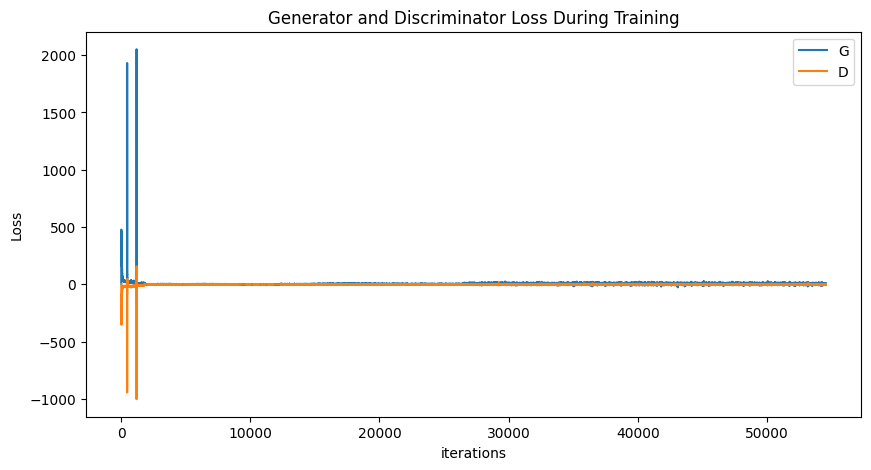

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Hyperparameters and global variables
dataset_dir = "/kaggle/input/shoe-vs-sandal-vs-boot-dataset-15k-images/Shoe vs Sandal vs Boot Dataset"
start_train_img_size = 4
lr = 1e-3
batch_sizes = [256,128,64,32,16]
channels_img = 3
z_dim = 512
w_dim = 512
in_channels = 512
lambda_gp = 10
progressive_epochs = [30] * len(batch_sizes)
gen_save_path = "/kaggle/working/stylegan_gen.pth"
disc_save_path = "/kaggle/working/stylegan_disc.pth"
training_plot_save_path = "/kaggle/working/train_plot.png"
animation_save_path = "/kaggle/working/animation.mp4"

# check_loader() 

# Define models and optimizers
gen_net = Generator(z_dim, w_dim, in_channels, channels_img).to(device)
disc_net = Discriminator(in_channels, channels_img).to(device)
gen_optimizer = optim.Adam([{"params": [param for name, param in gen_net.named_parameters() if "map" not in name]},
                     {"params": gen_net.map.parameters(), "lr": 1e-5}], lr=lr, betas=(0.0, 0.99))
disc_optimizer = optim.Adam(disc_net.parameters(), lr=lr, betas=(0.0, 0.99))

# Lists to keep track of progress
G_losses = []
D_losses = []
iters = 0

# Monitor Progress
progress = list()
fixed_noise = torch.randn(100, z_dim, device=device)
fixed_labels = torch.Tensor([[i]*10 for i in range(10)]).view(100,).int().to(device)

# Training loop
gen_net.train()
disc_net.train()
step = int(math.log2(start_train_img_size / 4))
for num_epochs in progressive_epochs[step:]:
    alpha = 1e-7
    
    loader, dataset = get_loader(4*2**step)
    print("Curent image size: " + str(4*2**step))

    for epoch in range(num_epochs):
        # print(f"Epoch [{epoch + 1}/{num_epochs}")

        loop = tqdm(loader, leave=True)

        for batch_idx, (real_images, labels) in enumerate(loop):
            real_images = real_images.to(device)
            current_batch_size = real_images.shape[0]
            noise = torch.randn(current_batch_size, z_dim).to(device)
            labels = labels.to(device).to(torch.float32)
#             print(labels.dtype)
#             print(real_images.shape, labels.shape)
            
            fake = gen_net(noise, labels, alpha, step)
            real_output = disc_net(real_images, labels, alpha, step)
            fake_output = disc_net(fake.detach(), labels, alpha, step)

            grad_penalty = gradient_penalty(disc_net, labels, real_images, fake, alpha, step, device)
            disc_loss = (-(torch.mean(real_output)-torch.mean(fake_output)) + lambda_gp*grad_penalty + (0.001)*torch.mean(real_output**2))

            disc_net.zero_grad()
            disc_loss.backward()
            disc_optimizer.step()

            gen_fake = disc_net(fake, labels, alpha, step)
            gen_loss = -torch.mean(gen_fake)

            gen_net.zero_grad()
            gen_loss.backward()
            gen_optimizer.step()

            alpha += current_batch_size/(progressive_epochs[step]*0.5*len(dataset))
            alpha = min(alpha,1)

            loop.set_postfix(grad_penalty = grad_penalty.item(), disc_loss = disc_loss.item())
        
            # Training Update
            if batch_idx % 50 == 0:
                print(f"[{epoch}/{num_epochs}][{batch_idx}/{len(loader)}]\tLoss_D: {disc_loss.item()}\tLoss_G: {gen_loss.item()}")

            # Tracking loss
            G_losses.append(gen_loss.item())
            D_losses.append(disc_loss.item())

#             # Tracking Generator Progress
#             if (iters%10 == 0) or ((epoch == num_epochs-1) and (batch_idx == len(loader)-1)):
#                 with torch.no_grad():
#                     fake = gen_net(fixed_noise, fixed_labels).detach().cpu()
#                 progress.append(torch_utils.make_grid(fake, padding=2, nrow=10, normalize=True))

            iters += 1

#     generate_examples(gen_net, step)
    step += 1

# Save generator
torch.save(gen_net, gen_save_path)
torch.save(disc_net, disc_save_path)

# Plot Training Graph
fig1 = plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses, label="G")
plt.plot(D_losses, label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.savefig(training_plot_save_path)
plt.show()

# Progress Animation
fig2 = plt.figure(figsize=(8, 8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i, (1, 2, 0)), animated=True)] for i in progress]
anim = animation.ArtistAnimation(fig2, ims, interval=1000, repeat_delay=1000, blit=True)
writervideo = animation.FFMpegWriter(fps=5)
anim.save(animation_save_path, writer=writervideo)
plt.close()